In [ ]:
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import pandas as pd
import numpy as np
import time
import math
import warnings
warnings.filterwarnings('ignore')

# Algorithms

## Base

In [ ]:
class BaseOptimizer(ABC):
    """
    Lớp trừu tượng cơ sở cho các thuật toán tối ưu hóa.
    """

    def __init__(self, objective_function, search_space, problem_type='minimize', max_iterations=100, seed=None):
        self.objective_function = objective_function
        self.search_space = search_space
        self.problem_type = problem_type
        self.max_iterations = max_iterations
        self.seed = seed
        self.rng = np.random.default_rng(self.seed)
        if self.problem_type not in ['minimize', 'maximize']:
            raise ValueError("problem_type must be either 'minimize' or 'maximize'")
        if 'type' not in self.search_space:
            raise ValueError("search_space dictionary must contain a 'type' key.")
        self.space_type = self.search_space['type']
        if self.space_type == 'continuous':
            self.lower_bounds = np.array(self.search_space['bounds'])[:, 0]
            self.upper_bounds = np.array(self.search_space['bounds'])[:, 1]
        self.best_solution_ = None
        self.best_fitness_ = float('inf') if self.problem_type == 'minimize' else float('-inf')
        self.history = []
        self.execution_time_ = 0

    def _is_better(self, fitness1, fitness2):
        """So sánh hai giá trị fitness."""
        if self.problem_type == 'minimize':
            return fitness1 < fitness2
        return fitness1 > fitness2

    def _update_best_solution(self, solution, fitness):
        """Kiểm tra và cập nhật giải pháp toàn cục tốt nhất."""
        if self._is_better(fitness, self.best_fitness_):
            self.best_fitness_ = fitness
            self.best_solution_ = solution.copy()
            return True
        return False

    def _create_random_solution(self):
        """
        Tạo một giải pháp ngẫu nhiên.
        """
        if self.space_type == 'continuous':
            bounds = np.array(self.search_space['bounds'])
            return self.rng.uniform(bounds[:, 0], bounds[:, 1], size=bounds.shape[0])
        elif self.space_type == 'binary':
            length = self.search_space['length']
            return self.rng.integers(0, 2, size=length)
        elif self.space_type == 'permutation':
            length = self.search_space['length']
            return self.rng.permutation(length)
        else:
            raise ValueError(f"Unsupported search space type: {self.space_type}")

    def _create_initial_population(self, population_size):
        """
        Tạo một quần thể ban đầu gồm các giải pháp ngẫu nhiên.
        """
        population = [self._create_random_solution() for _ in range(population_size)]
        return np.array(population)

    def _ensure_bounds(self, solution):
        """
        Đảm bảo một giải pháp nằm trong không gian tìm kiếm.
        """
        if self.space_type == 'continuous':
            return np.clip(solution, self.lower_bounds, self.upper_bounds)
        return solution

    @abstractmethod
    def solve(self):
        pass

    def run(self):
        """Hàm bao bọc để chạy thuật toán và đo lường hiệu suất."""
        start_time = time.time()
        self.solve()
        end_time = time.time()
        self.execution_time_ = end_time - start_time
        results = {
            'best_solution': self.best_solution_,
            'best_fitness': self.best_fitness_,
            'convergence_history': self.history,
            'execution_time': self.execution_time_,
            'seed': self.seed
        }
        print(f"Algorithm (seed={self.seed}) finished in {self.execution_time_:.4f} seconds.")
        print(f"Best fitness: {self.best_fitness_}")
        return results

## Ant Colony Optimization

In [ ]:
class AntColonyOptimizer(BaseOptimizer):
    """
    Triển khai Tối ưu hóa Bầy kiến (ACO) hỗ trợ cả:
    1. Permutation problems (TSP) - ACO truyền thống
    2. Continuous problems - ACOR (Ant Colony Optimization for Continuous domains)
    """
    def __init__(self, objective_function, search_space, problem_type='minimize',
                 max_iterations=100, seed=None, population_size=25,
                 alpha=1.0, beta=2.0, rho=0.5, q=100, elitism_weight=1.0,
                 local_rho=0.1, tau0=None, use_mmas=True,
                 archive_size=50, q_acor=0.01, xi=0.85):
        super().__init__(objective_function, search_space, problem_type, max_iterations, seed)

        self.n_ants = population_size
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q = q
        self.elitism_weight = elitism_weight
        self.local_rho = local_rho
        self.use_mmas = use_mmas
        self.initial_tau = tau0
        self.archive_size = archive_size
        self.q_acor = q_acor
        self.xi = xi

        # Khởi tạo theo loại không gian
        if self.space_type == 'permutation':
            self._init_permutation()
        elif self.space_type == 'continuous':
            self._init_continuous()
        else:
            raise TypeError(f"AntColonyOptimizer chỉ hỗ trợ 'permutation' và 'continuous', không hỗ trợ '{self.space_type}'.")

    def _init_permutation(self):
        """Khởi tạo cho bài toán permutation (TSP)."""
        if 'distance_matrix' not in self.search_space:
            raise ValueError("search_space phải chứa 'distance_matrix' cho permutation problem.")

        self.distance_matrix = np.array(self.search_space['distance_matrix'])
        self.n_cities = self.distance_matrix.shape[0]
        self.tau_max = None
        self.tau_min = None

        # Pre-compute heuristic matrix
        self.heuristic_matrix = 1.0 / (self.distance_matrix + 1e-10)
        np.fill_diagonal(self.heuristic_matrix, 0)

    def _init_continuous(self):
        """Khởi tạo cho bài toán continuous (ACOR)."""
        bounds = np.array(self.search_space['bounds'])
        self.n_dims = bounds.shape[0]

        # Solution archive: lưu trữ các giải pháp tốt nhất
        self.archive = []  # [(solution, fitness), ...]
        self.weights = None  # Trọng số cho mỗi giải pháp trong archive

        # Pre-compute constants
        self.two_pi_sqrt = np.sqrt(2 * np.pi)

    # ============ PHƯƠNG THỨC CHO PERMUTATION (TSP) ============

    def _update_mmas_bounds(self):
        """Cập nhật giới hạn pheromone cho MMAS."""
        if self.best_fitness_ is not None and self.best_fitness_ > 0:
            self.tau_max = 1.0 / (self.rho * self.best_fitness_)
            self.tau_min = max(self.tau_max / (2 * self.n_cities), 1e-10)

    def _update_pheromones(self, pheromone_matrix, all_tours=None):
        """Cập nhật pheromone cho permutation problems."""
        # Vectorized evaporation
        pheromone_matrix *= (1 - self.rho)

        if self.use_mmas:
            if self.best_solution_ is not None:
                deposit_amount = self.elitism_weight / self.best_fitness_
                best_tour = self.best_solution_

                # Vectorized deposit for best tour
                idx_from = best_tour[:-1]
                idx_to = best_tour[1:]
                pheromone_matrix[idx_from, idx_to] += deposit_amount
                pheromone_matrix[idx_to, idx_from] += deposit_amount

                # Close the tour
                pheromone_matrix[best_tour[-1], best_tour[0]] += deposit_amount
                pheromone_matrix[best_tour[0], best_tour[-1]] += deposit_amount
        else:
            if all_tours is None:
                raise ValueError("all_tours là bắt buộc khi use_mmas=False.")

            # Batch process all tours
            for tour, tour_length in all_tours:
                deposit_amount = self.q / tour_length
                idx_from = tour[:-1]
                idx_to = tour[1:]
                pheromone_matrix[idx_from, idx_to] += deposit_amount
                pheromone_matrix[idx_to, idx_from] += deposit_amount
                pheromone_matrix[tour[-1], tour[0]] += deposit_amount
                pheromone_matrix[tour[0], tour[-1]] += deposit_amount

            # Elitism bonus
            if self.best_solution_ is not None:
                bonus_deposit = self.elitism_weight * self.q / self.best_fitness_
                best_tour = self.best_solution_
                idx_from = best_tour[:-1]
                idx_to = best_tour[1:]
                pheromone_matrix[idx_from, idx_to] += bonus_deposit
                pheromone_matrix[idx_to, idx_from] += bonus_deposit
                pheromone_matrix[best_tour[-1], best_tour[0]] += bonus_deposit
                pheromone_matrix[best_tour[0], best_tour[-1]] += bonus_deposit

        if self.use_mmas:
            np.clip(pheromone_matrix, self.tau_min, self.tau_max, out=pheromone_matrix)

        return pheromone_matrix

    def _construct_tour(self, pheromone_matrix):
        """Xây dựng tour cho permutation problems."""
        start_city = self.rng.integers(0, self.n_cities)
        tour = np.empty(self.n_cities, dtype=np.int32)
        tour[0] = start_city

        # Use boolean array for visited tracking
        visited = np.zeros(self.n_cities, dtype=bool)
        visited[start_city] = True
        current_city = start_city

        tau0_local = self.tau_min if self.use_mmas and self.tau_min is not None else 1e-4
        one_minus_local_rho = 1 - self.local_rho

        for step in range(1, self.n_cities):
            # Get unvisited cities using boolean indexing
            unvisited_mask = ~visited
            unvisited_cities = np.where(unvisited_mask)[0]

            # Vectorized probability calculation
            pheromone_levels = pheromone_matrix[current_city, unvisited_cities] ** self.alpha
            heuristic_values = self.heuristic_matrix[current_city, unvisited_cities] ** self.beta
            probabilities = pheromone_levels * heuristic_values

            prob_sum = np.sum(probabilities)
            if prob_sum == 0:
                next_city = self.rng.choice(unvisited_cities)
            else:
                probabilities /= prob_sum
                next_city = self.rng.choice(unvisited_cities, p=probabilities)

            # Local pheromone update
            edge_pheromone = pheromone_matrix[current_city, next_city]
            new_pheromone = one_minus_local_rho * edge_pheromone + self.local_rho * tau0_local
            pheromone_matrix[current_city, next_city] = new_pheromone
            pheromone_matrix[next_city, current_city] = new_pheromone

            tour[step] = next_city
            visited[next_city] = True
            current_city = next_city

        # Final edge local update
        edge_pheromone = pheromone_matrix[tour[-1], tour[0]]
        new_pheromone = one_minus_local_rho * edge_pheromone + self.local_rho * tau0_local
        pheromone_matrix[tour[-1], tour[0]] = new_pheromone
        pheromone_matrix[tour[0], tour[-1]] = new_pheromone

        return tour

    def _solve_permutation(self):
        """Giải quyết bài toán permutation (TSP)."""
        # Initialize with random tour
        initial_tour = self.rng.permutation(self.n_cities)
        initial_fitness = self.objective_function(initial_tour)
        self._update_best_solution(initial_tour, initial_fitness)
        self.history.append(self.best_fitness_)

        # Initialize pheromone matrix
        if self.use_mmas:
            self._update_mmas_bounds()
            pheromone_matrix = np.full((self.n_cities, self.n_cities), self.tau_max)
        else:
            tau0 = self.initial_tau if self.initial_tau is not None else 1.0 / (self.n_cities * initial_fitness)
            pheromone_matrix = np.full((self.n_cities, self.n_cities), tau0)

        for _ in range(self.max_iterations):
            all_tours = []

            # Construct tours for all ants
            for _ in range(self.n_ants):
                tour = self._construct_tour(pheromone_matrix)
                tour_length = self.objective_function(tour)
                all_tours.append((tour, tour_length))

            # Find best tour in iteration
            best_tour_in_iter, best_len_in_iter = min(all_tours, key=lambda x: x[1])
            if self._update_best_solution(np.array(best_tour_in_iter), best_len_in_iter):
                if self.use_mmas:
                    self._update_mmas_bounds()

            pheromone_matrix = self._update_pheromones(pheromone_matrix, all_tours=all_tours)
            self.history.append(self.best_fitness_)

    # ============ PHƯƠNG THỨC CHO CONTINUOUS (ACOR) ============

    def _calculate_weights(self):
        """Tính trọng số cho các giải pháp trong archive dựa trên rank."""
        k = len(self.archive)
        q_k = self.q_acor * k
        two_q_k_sq = 2 * q_k * q_k

        # Vectorized weight calculation
        ranks = np.arange(k)
        weights = np.exp(-(ranks ** 2) / two_q_k_sq) / (q_k * self.two_pi_sqrt)

        # Normalize weights
        weights /= np.sum(weights)
        return weights

    def _construct_solution_continuous(self):
        """Xây dựng một giải pháp mới từ archive sử dụng Gaussian kernel."""
        solution = np.empty(self.n_dims)

        # Pre-extract all solutions as array for vectorized operations
        archive_solutions = np.array([sol for sol, _ in self.archive])

        for d in range(self.n_dims):
            # Chọn một giải pháp từ archive dựa trên weights
            selected_idx = self.rng.choice(len(self.archive), p=self.weights)
            selected_value = archive_solutions[selected_idx, d]

            # Vectorized distance calculation
            distances = np.abs(archive_solutions[:, d] - selected_value)
            sigma = self.xi * np.mean(distances) if len(distances) > 0 else 1.0

            # Sinh giá trị mới từ Gaussian distribution
            solution[d] = self.rng.normal(selected_value, sigma)

        # Đảm bảo solution nằm trong bounds
        solution = self._ensure_bounds(solution)
        return solution

    def _update_archive(self, new_solution, new_fitness):
        """Cập nhật solution archive."""
        # Thêm solution mới
        self.archive.append((new_solution.copy(), new_fitness))

        # Sắp xếp archive theo fitness (tốt nhất trước)
        if self.problem_type == 'minimize':
            self.archive.sort(key=lambda x: x[1])
        else:
            self.archive.sort(key=lambda x: x[1], reverse=True)

        # Giữ chỉ archive_size solutions tốt nhất
        if len(self.archive) > self.archive_size:
            self.archive = self.archive[:self.archive_size]

        # Cập nhật weights
        self.weights = self._calculate_weights()

    def _solve_continuous(self):
        """Giải quyết bài toán continuous sử dụng ACOR."""
        # Khởi tạo archive với random solutions
        for _ in range(self.archive_size):
            solution = self._create_random_solution()
            fitness = self.objective_function(solution)
            self.archive.append((solution, fitness))
            self._update_best_solution(solution, fitness)

        # Sắp xếp archive
        if self.problem_type == 'minimize':
            self.archive.sort(key=lambda x: x[1])
        else:
            self.archive.sort(key=lambda x: x[1], reverse=True)

        # Tính weights ban đầu
        self.weights = self._calculate_weights()
        self.history.append(self.best_fitness_)

        # Vòng lặp chính
        for iteration in range(self.max_iterations):
            worst_fitness = self.archive[-1][1]

            # Mỗi ant tạo một solution mới
            for _ in range(self.n_ants):
                new_solution = self._construct_solution_continuous()
                new_fitness = self.objective_function(new_solution)

                # Cập nhật archive nếu solution tốt hơn worst solution trong archive
                if self._is_better(new_fitness, worst_fitness):
                    self._update_archive(new_solution, new_fitness)
                    worst_fitness = self.archive[-1][1]  # Update worst fitness

                # Cập nhật best solution
                self._update_best_solution(new_solution, new_fitness)

            self.history.append(self.best_fitness_)

    # ============ PHƯƠNG THỨC CHÍNH ============

    def solve(self):
        """Giải quyết bài toán dựa trên loại không gian tìm kiếm."""
        if self.space_type == 'permutation':
            self._solve_permutation()
        elif self.space_type == 'continuous':
            self._solve_continuous()
        else:
            raise ValueError(f"Unsupported search space type: {self.space_type}")

## Particle Swarm Optimization

In [ ]:
class ParticleSwarmOptimizer(BaseOptimizer):
    """
    Triển khai thuật toán Tối ưu hóa Bầy đàn Hạt (Particle Swarm Optimization).
    """
    def __init__(self, objective_function, search_space, problem_type='minimize',
                 max_iterations=100, seed=None, population_size=30,
                 w_max=0.9, w_min=0.4, c1_start=2.5, c1_end=0.5,
                 c2_start=0.5, c2_end=2.5,
                 v_clamp_factor=0.2,
                 stagnation_threshold=1e-8,
                 stagnation_counter_max=50,
                 reinit_fraction=0.3,
                 use_constriction=True,
                 verbose=False):
        """
        Khởi tạo PSO Optimizer cải tiến.

        Args:
            c1_start, c1_end: Hệ số nhận thức thay đổi theo thời gian (bắt đầu cao, giảm dần)
            c2_start, c2_end: Hệ số xã hội thay đổi theo thời gian (bắt đầu thấp, tăng dần)
            v_clamp_factor: Hệ số giới hạn vận tốc (giảm từ 0.5 xuống 0.2)
            stagnation_counter_max: Số iterations không cải thiện trước khi kích hoạt diversity
            use_constriction: Sử dụng constriction factor (Clerc & Kennedy)
        """
        super().__init__(objective_function, search_space, problem_type, max_iterations, seed)

        if self.space_type not in ['continuous', 'permutation']:
            raise TypeError("ParticleSwarmOptimizer hỗ trợ không gian 'continuous' và 'permutation'.")

        self.population_size = population_size
        self.w_max = w_max
        self.w_min = w_min
        self.c1_start = c1_start
        self.c1_end = c1_end
        self.c2_start = c2_start
        self.c2_end = c2_end
        self.v_clamp_factor = v_clamp_factor
        self.stagnation_threshold = stagnation_threshold
        self.stagnation_counter_max = stagnation_counter_max
        self.reinit_fraction = reinit_fraction
        self.use_constriction = use_constriction
        self.verbose = verbose

        # Tính constriction factor
        if self.use_constriction:
            phi = self.c1_start + self.c2_start
            if phi > 4:
                self.chi = 2.0 / abs(2.0 - phi - np.sqrt(phi**2 - 4*phi))
            else:
                self.chi = 1.0
        else:
            self.chi = 1.0

        # Thiết lập bounds và v_max dựa trên loại không gian
        if self.space_type == 'continuous':
            domain_range = self.upper_bounds - self.lower_bounds
            self.v_max = self.v_clamp_factor * domain_range
            self.absolute_stagnation_threshold = self.stagnation_threshold * np.mean(domain_range)
        elif self.space_type == 'permutation':
            self.n_cities = self.search_space['length']
            self.lower_bounds = np.zeros(self.n_cities)
            self.upper_bounds = np.ones(self.n_cities)
            domain_range = self.upper_bounds - self.lower_bounds
            self.v_max = self.v_clamp_factor * domain_range
            self.absolute_stagnation_threshold = self.stagnation_threshold * np.mean(domain_range)

    def _decode_to_permutation(self, continuous_vector):
        """Chuyển đổi vector liên tục thành permutation."""
        return np.argsort(continuous_vector)

    def _evaluate_solution(self, position):
        """Đánh giá solution."""
        if self.space_type == 'permutation':
            permutation = self._decode_to_permutation(position)
            return self.objective_function(permutation)
        else:
            return self.objective_function(position)

    def solve(self):
        # 1. Khởi tạo
        if self.space_type == 'permutation':
            positions = self.rng.uniform(self.lower_bounds, self.upper_bounds,
                                        size=(self.population_size, self.n_cities))
        else:
            positions = self._create_initial_population(self.population_size)

        # Khởi tạo vận tốc nhỏ hơn để tránh overshoot
        initial_v_range = 0.05 * self.v_max
        velocities = self.rng.uniform(-initial_v_range, initial_v_range,
                                      size=(self.population_size, len(self.lower_bounds)))

        pbest_positions = positions.copy()
        pbest_fitnesses = np.array([self._evaluate_solution(p) for p in pbest_positions])

        best_idx = np.argmin(pbest_fitnesses) if self.problem_type == 'minimize' else np.argmax(pbest_fitnesses)

        if self.space_type == 'permutation':
            self.best_solution_ = self._decode_to_permutation(pbest_positions[best_idx])
            self.best_solution_encoded_ = pbest_positions[best_idx].copy()
        else:
            self.best_solution_ = pbest_positions[best_idx].copy()

        self.best_fitness_ = pbest_fitnesses[best_idx]
        self.history.append(self.best_fitness_)

        # Tracking stagnation
        stagnation_counter = 0
        last_best_fitness = self.best_fitness_

        # 2. Vòng lặp chính
        for i in range(self.max_iterations):
            # Time-varying inertia weight (linear decrease)
            w = self.w_max - (self.w_max - self.w_min) * (i / self.max_iterations)

            # Time-Varying Acceleration Coefficients (TVAC)
            c1 = self.c1_start - (self.c1_start - self.c1_end) * (i / self.max_iterations)
            c2 = self.c2_start + (self.c2_end - self.c2_start) * (i / self.max_iterations)

            # Adaptive velocity clamping (giảm dần theo thời gian)
            adaptive_v_clamp = self.v_clamp_factor * (1 - 0.5 * i / self.max_iterations)
            current_v_max = adaptive_v_clamp * (self.upper_bounds - self.lower_bounds)

            r1 = self.rng.random((self.population_size, len(self.lower_bounds)))
            r2 = self.rng.random((self.population_size, len(self.lower_bounds)))

            cognitive_component = c1 * r1 * (pbest_positions - positions)

            if self.space_type == 'permutation':
                best_position_encoded = self.best_solution_encoded_
            else:
                best_position_encoded = self.best_solution_

            social_component = c2 * r2 * (best_position_encoded - positions)

            # Cập nhật vận tốc với constriction factor
            velocities = self.chi * (w * velocities + cognitive_component + social_component)

            # Adaptive velocity clamping
            velocities = np.clip(velocities, -current_v_max, current_v_max)

            # Cập nhật vị trí
            positions = positions + velocities
            positions = self._ensure_bounds(positions)

            # Đánh giá fitness
            current_fitnesses = np.array([self._evaluate_solution(p) for p in positions])

            # Cập nhật personal best
            improvement_mask = current_fitnesses < pbest_fitnesses if self.problem_type == 'minimize' else current_fitnesses > pbest_fitnesses
            pbest_positions[improvement_mask] = positions[improvement_mask]
            pbest_fitnesses[improvement_mask] = current_fitnesses[improvement_mask]

            # Cập nhật global best
            best_current_idx = np.argmin(current_fitnesses) if self.problem_type == 'minimize' else np.argmax(current_fitnesses)

            improved = False
            if self._is_better(current_fitnesses[best_current_idx], self.best_fitness_):
                if self.space_type == 'permutation':
                    self.best_solution_ = self._decode_to_permutation(positions[best_current_idx])
                    self.best_solution_encoded_ = positions[best_current_idx].copy()
                else:
                    self.best_solution_ = positions[best_current_idx].copy()
                self.best_fitness_ = current_fitnesses[best_current_idx]
                improved = True

            self.history.append(self.best_fitness_)

            # Stagnation detection
            fitness_improvement = abs(self.best_fitness_ - last_best_fitness)
            if fitness_improvement < self.absolute_stagnation_threshold:
                stagnation_counter += 1
            else:
                stagnation_counter = 0
            last_best_fitness = self.best_fitness_

            # Enhanced diversity maintenance
            if stagnation_counter >= self.stagnation_counter_max:
                if self.verbose:
                    print(f"Iter {i}: Stagnation detected! Reinitializing {self.reinit_fraction*100}% worst particles")

                n_reinit = max(2, int(self.reinit_fraction * self.population_size))

                # Chọn các hạt kém nhất để tái khởi tạo
                sorted_indices = np.argsort(current_fitnesses)
                worst_indices = sorted_indices[-n_reinit:] if self.problem_type == 'minimize' else sorted_indices[:n_reinit]

                # Tái khởi tạo vị trí ngẫu nhiên
                if self.space_type == 'permutation':
                    new_positions = self.rng.uniform(self.lower_bounds, self.upper_bounds,
                                                    size=(n_reinit, self.n_cities))
                else:
                    new_positions = self._create_initial_population(n_reinit)

                # Tái khởi tạo vận tốc với biên độ lớn hơn để tăng exploration
                reinit_v_range = 0.15 * self.v_max
                new_velocities = self.rng.uniform(-reinit_v_range, reinit_v_range,
                                                size=(n_reinit, len(self.lower_bounds)))

                # Cập nhật
                positions[worst_indices] = new_positions
                velocities[worst_indices] = new_velocities

                # Reset pbest cho các hạt được tái khởi tạo
                pbest_positions[worst_indices] = new_positions
                pbest_fitnesses[worst_indices] = np.array([self._evaluate_solution(p) for p in new_positions])

                # Reset counter
                stagnation_counter = 0

            # Thêm một số nhiễu ngẫu nhiên vào vận tốc mỗi vài iterations
            if i % 50 == 0 and i > 0:
                mutation_strength = 0.01 * (1 - i / self.max_iterations)
                noise = self.rng.normal(0, mutation_strength, velocities.shape)
                velocities = velocities + noise * (self.upper_bounds - self.lower_bounds)

## Artificial Bee Colony

In [ ]:
class ArtificialBeeColonyOptimizer(BaseOptimizer):
    """
    Triển khai thuật toán Bầy ong Nhân tạo (Artificial Bee Colony - ABC).
    Hỗ trợ cả không gian liên tục (continuous) và hoán vị (permutation - TSP).
    """
    def __init__(self, objective_function, search_space, problem_type='minimize',
                 max_iterations=100, seed=None, population_size=30, limit=10):
        """
        Khởi tạo ABC Optimizer.

        Args:
            population_size (int): Số lượng ong thợ (cũng bằng số lượng ong quan sát và số lượng nguồn thức ăn).
            limit (int): Số lần thử tối đa trước khi một nguồn thức ăn bị từ bỏ.
        """
        super().__init__(objective_function, search_space, problem_type, max_iterations, seed)

        if self.space_type not in ['continuous', 'permutation']:
            raise TypeError("ArtificialBeeColonyOptimizer only supports 'continuous' and 'permutation' search spaces.")

        self.population_size = population_size
        self.limit = limit

    def _calculate_fitness(self, f_obj):
        """
        Chuyển đổi giá trị hàm mục tiêu thành giá trị fitness để tính xác suất.
        Giá trị fitness càng cao thì càng tốt.
        """
        if self.problem_type == 'minimize':
            return np.where(f_obj >= 0, 1 / (1 + f_obj), 1 + np.abs(f_obj))
        else: # maximize
            return f_obj

    def _generate_neighbor_continuous(self, source, partner_source):
        """
        Tạo nguồn thức ăn mới cho không gian liên tục.
        """
        new_source = source.copy()
        dim_to_change = self.rng.integers(0, new_source.shape[0])
        phi = self.rng.uniform(-1, 1)
        new_source[dim_to_change] += phi * (new_source[dim_to_change] - partner_source[dim_to_change])
        new_source = self._ensure_bounds(new_source)
        return new_source

    def _generate_neighbor_permutation(self, source):
        """
        Tạo nguồn thức ăn mới cho không gian hoán vị (TSP).
        Sử dụng các toán tử: swap, insert, hoặc inversion.
        """
        new_source = source.copy()
        operator = self.rng.choice(['swap', 'insert', 'inversion'])

        n = len(new_source)

        if operator == 'swap':
            # Hoán đổi 2 vị trí ngẫu nhiên
            i, j = self.rng.choice(n, size=2, replace=False)
            new_source[i], new_source[j] = new_source[j], new_source[i]

        elif operator == 'insert':
            # Lấy một phần tử và chèn vào vị trí khác
            i = self.rng.integers(0, n)
            j = self.rng.integers(0, n)
            element = new_source[i]
            new_source = np.delete(new_source, i)
            new_source = np.insert(new_source, j, element)

        elif operator == 'inversion':
            # Đảo ngược một đoạn con
            i, j = sorted(self.rng.choice(n, size=2, replace=False))
            new_source[i:j+1] = new_source[i:j+1][::-1]

        return new_source

    def solve(self):
        """
        Triển khai vòng lặp chính của thuật toán ABC.
        """
        # 1. Khởi tạo
        food_sources = self._create_initial_population(self.population_size)
        obj_values = np.array([self.objective_function(fs) for fs in food_sources])
        trials = np.zeros(self.population_size)

        best_idx = np.argmin(obj_values) if self.problem_type == 'minimize' else np.argmax(obj_values)
        self._update_best_solution(food_sources[best_idx], obj_values[best_idx])
        self.history.append(self.best_fitness_)

        # 2. Bắt đầu vòng lặp
        for _ in range(self.max_iterations):

            # --- PHA ONG THỢ (EMPLOYED BEE PHASE) ---
            for i in range(self.population_size):
                # Tạo nguồn thức ăn mới dựa trên loại không gian
                if self.space_type == 'continuous':
                    partner_idx = self.rng.choice([j for j in range(self.population_size) if j != i])
                    partner_source = food_sources[partner_idx]
                    new_source = self._generate_neighbor_continuous(food_sources[i], partner_source)
                else:  # permutation
                    new_source = self._generate_neighbor_permutation(food_sources[i])

                new_obj_value = self.objective_function(new_source)

                if self._is_better(new_obj_value, obj_values[i]):
                    food_sources[i] = new_source
                    obj_values[i] = new_obj_value
                    trials[i] = 0
                else:
                    trials[i] += 1

            # --- PHA ONG QUAN SÁT (ONLOOKER BEE PHASE) ---
            fitness_values = self._calculate_fitness(obj_values)

            # Xử lý trường hợp tổng fitness bằng 0 để tránh lỗi chia cho 0
            sum_fitness = np.sum(fitness_values)
            if sum_fitness == 0:
                probabilities = np.ones(self.population_size) / self.population_size
            else:
                probabilities = fitness_values / sum_fitness

            # Mỗi ong quan sát sẽ chọn một nguồn thức ăn dựa trên xác suất
            n_onlookers = self.population_size
            for _ in range(n_onlookers):
                chosen_idx = self.rng.choice(self.population_size, p=probabilities)

                # Tạo nguồn thức ăn mới
                if self.space_type == 'continuous':
                    partner_idx = self.rng.choice([j for j in range(self.population_size) if j != chosen_idx])
                    partner_source = food_sources[partner_idx]
                    new_source = self._generate_neighbor_continuous(food_sources[chosen_idx], partner_source)
                else:  # permutation
                    new_source = self._generate_neighbor_permutation(food_sources[chosen_idx])

                new_obj_value = self.objective_function(new_source)

                # Lựa chọn tham lam: nếu nguồn mới tốt hơn, nó sẽ thay thế nguồn cũ
                if self._is_better(new_obj_value, obj_values[chosen_idx]):
                    food_sources[chosen_idx] = new_source
                    obj_values[chosen_idx] = new_obj_value
                    trials[chosen_idx] = 0
                else:
                    trials[chosen_idx] += 1

            # --- PHA ONG TRINH SÁT (SCOUT BEE PHASE) ---
            exhausted_indices = np.where(trials > self.limit)[0]
            for i in exhausted_indices:
                food_sources[i] = self._create_random_solution()
                obj_values[i] = self.objective_function(food_sources[i])
                trials[i] = 0

            # Cập nhật giải pháp tốt nhất toàn cục
            current_best_idx = np.argmin(obj_values) if self.problem_type == 'minimize' else np.argmax(obj_values)
            self._update_best_solution(food_sources[current_best_idx], obj_values[current_best_idx])

            # Ghi lại lịch sử hội tụ
            self.history.append(self.best_fitness_)

## Firefly Algorithm

In [ ]:
class FireflyAlgorithmOptimizer(BaseOptimizer):
    """
    Triển khai cải tiến của Thuật toán Đom đóm (Firefly Algorithm).
    Hỗ trợ cả không gian liên tục (continuous) và bài toán hoán vị (permutation/TSP).
    """
    def __init__(self, objective_function, search_space, problem_type='minimize',
                 max_iterations=100, seed=None, population_size=30,
                 alpha=0.2, beta_0=1.0, gamma=1.0, k_best=None,
                 alpha_damp=0.97):
        """
        Khởi tạo FA Optimizer với các tham số tối ưu.

        Args:
            alpha (float): Giá trị ban đầu của tham số điều khiển bước di chuyển ngẫu nhiên (0.2 tốt hơn 0.5).
            beta_0 (float): Sự hấp dẫn cơ bản tại khoảng cách r=0.
            gamma (float): Hệ số hấp thụ ánh sáng (1.0 tốt hơn 0.01 cho exploration).
            k_best (int): Số lượng đom đóm sáng nhất để so sánh (None = so sánh với tất cả).
            alpha_damp (float): Tỷ lệ giảm dần của alpha (0.97 cho convergence tốt hơn).
        """
        super().__init__(objective_function, search_space, problem_type, max_iterations, seed)

        if self.space_type not in ['continuous', 'permutation']:
            raise TypeError("FireflyAlgorithmOptimizer only supports 'continuous' and 'permutation' search space.")

        self.population_size = population_size
        self.alpha_initial = alpha
        self.beta_0 = beta_0
        self.gamma = gamma
        self.alpha_damp = alpha_damp

        # k_best = None nghĩa là so sánh với tất cả (tốt hơn cho hàm phức tạp)
        if k_best is None:
            self.k_best = self.population_size
        else:
            if not (1 <= k_best <= self.population_size):
                raise ValueError(f"k_best ({k_best}) phải nằm trong khoảng [1, population_size].")
            self.k_best = k_best

    def _move_firefly_continuous(self, firefly_i, firefly_j, intensity_i, intensity_j, alpha_current):
        """
        Di chuyển đom đóm trong không gian liên tục với công thức cải tiến.
        """
        if not self._is_better(intensity_j, intensity_i):
            return firefly_i

        # Tính khoảng cách chuẩn hóa
        r = np.linalg.norm(firefly_i - firefly_j)

        # Beta giảm theo khoảng cách
        beta = self.beta_0 * np.exp(-self.gamma * r * r)

        # Random term với Levy flight để tăng khả năng exploration
        dim = len(firefly_i)
        levy = self._levy_flight(dim)
        random_term = alpha_current * levy * (self.upper_bounds - self.lower_bounds)

        # Di chuyển về phía đom đóm sáng hơn + random term
        new_firefly = firefly_i + beta * (firefly_j - firefly_i) + random_term

        return self._ensure_bounds(new_firefly)

    def _levy_flight(self, dim):
        """
        Tạo Levy flight để cải thiện exploration.
        Levy flight có bước nhảy lớn đôi khi, giúp thoát khỏi local minima.
        """
        beta = 1.5
        sigma = (math.gamma(1 + beta) * np.sin(np.pi * beta / 2) /
                (math.gamma((1 + beta) / 2) * beta * 2**((beta - 1) / 2)))**(1 / beta)

        u = self.rng.normal(0, sigma, dim)
        v = self.rng.normal(0, 1, dim)
        step = u / np.abs(v)**(1 / beta)

        return step

    def _move_firefly_permutation(self, firefly_i, firefly_j, intensity_i, intensity_j, alpha_current):
        """
        Di chuyển đom đóm trong không gian hoán vị (TSP).
        Sử dụng toán tử crossover và mutation thích hợp cho permutation.
        """
        if not self._is_better(intensity_j, intensity_i):
            return firefly_i.copy()

        # Tính khoảng cách (số vị trí khác nhau)
        diff_positions = np.sum(firefly_i != firefly_j)
        r_sq = diff_positions
        beta = self.beta_0 * np.exp(-self.gamma * r_sq)

        # Di chuyển về phía firefly_j dựa trên beta
        new_firefly = firefly_i.copy()

        # Order Crossover (OX) với tỷ lệ beta
        if self.rng.random() < beta:
            # Chọn một đoạn từ firefly_j
            length = len(firefly_i)
            cut1 = self.rng.integers(0, length)
            cut2 = self.rng.integers(cut1 + 1, length + 1)

            # Giữ đoạn từ firefly_j
            segment = firefly_j[cut1:cut2]

            # Điền phần còn lại từ firefly_i (giữ thứ tự)
            remaining = [x for x in firefly_i if x not in segment]
            new_firefly = np.concatenate([remaining[:cut1], segment, remaining[cut1:]])

        # Swap mutation
        n_swaps = int(alpha_current * len(firefly_i) * 0.5)
        for _ in range(n_swaps):
            if self.rng.random() < alpha_current:
                idx1, idx2 = self.rng.choice(len(firefly_i), size=2, replace=False)
                new_firefly[idx1], new_firefly[idx2] = new_firefly[idx2], new_firefly[idx1]

        return new_firefly

    def solve(self):
        """
        Thực hiện thuật toán Firefly với cải tiến.
        """
        # Khởi tạo quần thể
        population = self._create_initial_population(self.population_size)
        fitness = np.array([self.objective_function(ind) for ind in population])

        # Cập nhật best solution ban đầu
        best_idx = np.argmin(fitness) if self.problem_type == 'minimize' else np.argmax(fitness)
        self._update_best_solution(population[best_idx], fitness[best_idx])
        self.history.append(self.best_fitness_)

        alpha_current = self.alpha_initial

        for iteration in range(self.max_iterations):
            # Sắp xếp quần thể theo fitness
            sorted_indices = np.argsort(fitness)
            if self.problem_type == 'maximize':
                sorted_indices = sorted_indices[::-1]

            # Di chuyển các đom đóm
            new_population = population.copy()

            for i in range(self.population_size):
                # Chỉ so sánh với k_best đom đóm tốt nhất
                for j in sorted_indices[:self.k_best]:
                    if i == j:
                        continue

                    # Di chuyển đom đóm i về phía đom đóm j nếu j sáng hơn
                    if self.space_type == 'continuous':
                        new_firefly = self._move_firefly_continuous(
                            population[i], population[j],
                            fitness[i], fitness[j], alpha_current
                        )
                    else:  # permutation
                        new_firefly = self._move_firefly_permutation(
                            population[i], population[j],
                            fitness[i], fitness[j], alpha_current
                        )

                    # Đánh giá giải pháp mới
                    new_fitness = self.objective_function(new_firefly)

                    # Cập nhật nếu tốt hơn
                    if self._is_better(new_fitness, fitness[i]):
                        new_population[i] = new_firefly
                        fitness[i] = new_fitness
                        break  # Chỉ cập nhật một lần mỗi vòng lặp

            population = new_population

            # Cập nhật best solution
            best_idx = np.argmin(fitness) if self.problem_type == 'minimize' else np.argmax(fitness)
            self._update_best_solution(population[best_idx], fitness[best_idx])
            self.history.append(self.best_fitness_)

            # Giảm alpha theo thời gian
            alpha_current *= self.alpha_damp

            # Đảm bảo best solution luôn được giữ lại
            worst_idx = np.argmax(fitness) if self.problem_type == 'minimize' else np.argmin(fitness)
            if not np.array_equal(population[worst_idx], self.best_solution_):
                population[worst_idx] = self.best_solution_.copy()
                fitness[worst_idx] = self.best_fitness_

## Cuckoo Search

In [ ]:
class CuckooSearchOptimizer(BaseOptimizer):
    """
    Triển khai thuật toán Tìm kiếm Cúc cu (Cuckoo Search) sử dụng Lévy Flights.
    Hỗ trợ cả không gian tìm kiếm 'continuous' và 'permutation'.
    """
    def __init__(self, objective_function, search_space, problem_type='minimize',
                 max_iterations=100, seed=None, population_size=25,
                 p_a=0.25, alpha=1.0, beta=1.5,
                 # Thêm tham số cho bài toán permutation
                 step_size_min=1, step_size_max=4):
        """
        Khởi tạo CS Optimizer.

        Args:
            population_size (int): Số lượng tổ (nests) hoặc cúc cu.
            p_a (float): Xác suất phát hiện (discovery rate), tỷ lệ các tổ tồi bị từ bỏ.
            alpha (float): Hệ số kích thước bước đi (chủ yếu cho continuous).
            beta (float): Số mũ của Lévy (chủ yếu cho continuous).
            step_size_min (int): Số lượng đột biến tối thiểu trong một "chuyến bay Lévy" cho permutation.
            step_size_max (int): Số lượng đột biến tối đa trong một "chuyến bay Lévy" cho permutation.
        """
        super().__init__(objective_function, search_space, problem_type, max_iterations, seed)

        self.population_size = population_size
        self.p_a = p_a
        self.alpha = alpha
        self.beta = beta
        self.step_size_min = step_size_min
        self.step_size_max = step_size_max

        # Tính sigma chỉ khi là bài toán continuous
        if self.space_type == 'continuous':
            try:
                self.sigma = (math.gamma(1 + self.beta) * np.sin(np.pi * self.beta / 2) /
                              (math.gamma((1 + self.beta) / 2) * self.beta * 2**((self.beta - 1) / 2)))**(1 / self.beta)
            except ImportError:
                raise ImportError("`math.gamma` is required for the accurate Mantegna algorithm.")

    def _generate_cuckoo(self, current_nest):
        """
        Tạo ra một cúc cu mới (giải pháp mới) bằng cách sử dụng Lévy flights.
        Logic sẽ khác nhau tùy thuộc vào loại không gian tìm kiếm.
        """
        if self.space_type == 'continuous':
            # Lấy mẫu u, v từ phân phối chuẩn để tính bước nhảy Lévy
            u = self.rng.normal(0, self.sigma, size=self.lower_bounds.shape[0])
            v = self.rng.normal(0, 1, size=self.lower_bounds.shape[0])
            v = np.where(v == 0, 1e-10, v) # Tránh chia cho 0
            levy_step = u / (np.abs(v)**(1 / self.beta))

            # Tạo cúc cu mới
            step_size = self.alpha * levy_step * (current_nest - self.best_solution_)
            new_cuckoo = current_nest + step_size
            return self._ensure_bounds(new_cuckoo)

        elif self.space_type == 'permutation':
            new_cuckoo = current_nest.copy()
            # Mô phỏng "chuyến bay Lévy" bằng một số lượng ngẫu nhiên các phép đảo ngược
            num_inversions = self.rng.integers(self.step_size_min, self.step_size_max + 1)

            for _ in range(num_inversions):
                # Chọn hai điểm ngẫu nhiên để đảo ngược đoạn giữa
                i, j = self.rng.choice(len(new_cuckoo), 2, replace=False)
                if i > j: i, j = j, i # Đảm bảo i < j
                new_cuckoo[i:j+1] = new_cuckoo[i:j+1][::-1]
            return new_cuckoo

        else:
            # Fallback cho các loại không gian khác (nếu có)
            return self._create_random_solution()

    def solve(self):
        """
        Triển khai vòng lặp chính của thuật toán Cuckoo Search.
        """
        # 1. Khởi tạo
        nests = self._create_initial_population(self.population_size)
        fitnesses = np.array([self.objective_function(nest) for nest in nests])

        best_idx = np.argmin(fitnesses) if self.problem_type == 'minimize' else np.argmax(fitnesses)
        self._update_best_solution(nests[best_idx], fitnesses[best_idx])
        self.history.append(self.best_fitness_)

        # 2. Bắt đầu vòng lặp
        for _ in range(self.max_iterations):
            # --- PHA 1: TẠO CÚC CU MỚI BẰNG LÉVY FLIGHTS ---
            # Trong phiên bản gốc, mỗi cúc cu được tạo ra và so sánh với một tổ ngẫu nhiên.
            # Ta sẽ đơn giản hóa bằng cách tạo cúc cu mới cho mỗi tổ hiện tại.
            for i in range(self.population_size):
                # Tạo một cúc cu mới dựa trên tổ thứ i
                new_cuckoo = self._generate_cuckoo(nests[i])
                new_fitness = self.objective_function(new_cuckoo)

                # So sánh và thay thế nếu cúc cu mới tốt hơn
                if self._is_better(new_fitness, fitnesses[i]):
                    nests[i] = new_cuckoo
                    fitnesses[i] = new_fitness

            # --- PHA 2: TỪ BỎ MỘT PHẦN CÁC TỔ TỒI NHẤT ---
            sorted_indices = np.argsort(fitnesses)
            if self.problem_type == 'minimize':
                # Các chỉ số của tổ tệ nhất nằm ở cuối mảng đã sắp xếp
                worst_indices = sorted_indices[int((1 - self.p_a) * self.population_size):]
            else: # maximize
                # Các chỉ số của tổ tệ nhất nằm ở đầu mảng đã sắp xếp
                worst_indices = sorted_indices[:int(self.p_a * self.population_size)]

            for idx in worst_indices:
                if self.space_type == 'permutation':
                    # Tạo tổ mới bằng cách đột biến nhẹ giải pháp tốt nhất toàn cục
                    new_nest = self.best_solution_.copy()
                    # Áp dụng một phép đột biến nhỏ (1 lần đảo ngược)
                    p1, p2 = self.rng.choice(len(new_nest), 2, replace=False)
                    if p1 > p2: p1, p2 = p2, p1
                    new_nest[p1:p2+1] = new_nest[p1:p2+1][::-1]
                    nests[idx] = new_nest
                else: # continuous hoặc các loại khác
                    # Thay thế bằng một giải pháp hoàn toàn ngẫu nhiên
                    nests[idx] = self._create_random_solution()

                fitnesses[idx] = self.objective_function(nests[idx])

            # Cập nhật giải pháp tốt nhất toàn cục sau cả hai pha
            current_best_idx = np.argmin(fitnesses) if self.problem_type == 'minimize' else np.argmax(fitnesses)
            self._update_best_solution(nests[current_best_idx], fitnesses[current_best_idx])

            self.history.append(self.best_fitness_)

## Hill Climbing

In [ ]:
class HillClimbingOptimizer(BaseOptimizer):
    """
    Triển khai thuật toán Leo đồi (Steepest Ascent).
    """
    def __init__(self, objective_function, search_space, problem_type='minimize',
                 max_iterations=1000, seed=None, n_neighbors=20, step_size=0.1,
                 use_restarts=True,
                 stagnation_limit=50):
        """
        Khởi tạo Hill Climbing Optimizer.

        Args:
            n_neighbors (int): Số lượng hàng xóm được tạo ra ở mỗi bước.
            step_size (float): Kích thước bước để tạo hàng xóm (cho bài toán continuous).
            use_restarts (bool): Bật/tắt cơ chế khởi động lại ngẫu nhiên.
            stagnation_limit (int): Số vòng lặp không có sự cải thiện trước khi
                                   kích hoạt một lần khởi động lại ngẫu nhiên.
        """
        super().__init__(objective_function, search_space, problem_type, max_iterations, seed)

        self.n_neighbors = n_neighbors
        self.step_size = step_size
        self.use_restarts = use_restarts
        self.stagnation_limit = stagnation_limit

    def _create_neighbor_solution(self, current_solution):
        """Tạo một giải pháp hàng xóm dựa trên loại không gian tìm kiếm."""
        neighbor = current_solution.copy()

        if self.space_type == 'continuous':
            change = self.rng.uniform(-self.step_size, self.step_size, size=neighbor.shape)
            neighbor += change
            return self._ensure_bounds(neighbor)
        elif self.space_type == 'permutation':
            i, j = self.rng.choice(len(neighbor), 2, replace=False)
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            return neighbor
        elif self.space_type == 'binary':
            idx_to_flip = self.rng.integers(0, len(neighbor))
            neighbor[idx_to_flip] = 1 - neighbor[idx_to_flip]
            return neighbor
        else:
            raise ValueError(f"Unsupported space type for neighbor creation: {self.space_type}")

    def solve(self):
        """
        Triển khai vòng lặp chính của thuật toán Hill Climbing
        với cơ chế khởi động lại ngẫu nhiên.
        """
        # 1. Khởi tạo
        current_solution = self._create_random_solution()
        current_fitness = self.objective_function(current_solution)

        self._update_best_solution(current_solution, current_fitness)
        self.history.append(self.best_fitness_)

        # Biến đếm để theo dõi sự trì trệ
        stagnation_counter = 0

        # 2. Bắt đầu vòng lặp (chạy đến hết max_iterations)
        for i in range(1, self.max_iterations):
            # Tạo và đánh giá các hàng xóm
            neighbors = [(sol, self.objective_function(sol))
                         for sol in [self._create_neighbor_solution(current_solution)
                                     for _ in range(self.n_neighbors)]]

            # Tìm hàng xóm tốt nhất
            best_neighbor, best_neighbor_fitness = min(neighbors, key=lambda x: x[1]) if self.problem_type == 'minimize' else max(neighbors, key=lambda x: x[1])

            # So sánh và quyết định di chuyển
            if self._is_better(best_neighbor_fitness, current_fitness):
                # Di chuyển đến vị trí tốt hơn
                current_solution = best_neighbor
                current_fitness = best_neighbor_fitness
                self._update_best_solution(current_solution, current_fitness)
                stagnation_counter = 0 # Reset counter vì đã có cải thiện
            else:
                # Tăng counter nếu không có cải thiện
                stagnation_counter += 1

            if self.use_restarts and stagnation_counter >= self.stagnation_limit:
                # Nhảy đến một điểm ngẫu nhiên mới trong không gian tìm kiếm
                current_solution = self._create_random_solution()
                current_fitness = self.objective_function(current_solution)
                # Cập nhật global best nếu điểm ngẫu nhiên mới này tốt hơn
                self._update_best_solution(current_solution, current_fitness)
                # Reset counter sau khi nhảy
                stagnation_counter = 0

            # Nếu không dùng restart, thuật toán sẽ dừng ngay khi bị kẹt
            elif not self.use_restarts and stagnation_counter > 0:
                # Điền vào phần còn lại của lịch sử để đồ thị có cùng độ dài và dừng sớm
                remaining_iters = self.max_iterations - len(self.history)
                if remaining_iters > 0:
                    self.history.extend([self.best_fitness_] * remaining_iters)
                break

            # Ghi lại lịch sử hội tụ của global best ở mỗi bước
            self.history.append(self.best_fitness_)

## Simulated Annealing

In [ ]:
class SimulatedAnnealingOptimizer(BaseOptimizer):
    """
    Triển khai thuật toán Tôi luyện Mô phỏng (Simulated Annealing)
    """
    def __init__(self, objective_function, search_space, problem_type='minimize',
                 max_iterations=1000, seed=None, initial_temp=1000.0,
                 cooling_rate=0.99, min_temp=1e-5, step_size=0.1,
                 cooling_schedule='geometric', # 'geometric', 'fast'
                 use_reheating=True,
                 stagnation_limit=100,
                 reheat_fraction=0.2,
                 n_neighbors=10,  # Số lượng neighbor được tạo ra mỗi vòng lặp
                 neighbor_selection='best'):  # 'best', 'random', 'probabilistic'
        """
        Khởi tạo SA Optimizer.

        Args:
            initial_temp (float): Nhiệt độ bắt đầu.
            cooling_rate (float): Yếu tố điều khiển tốc độ nguội.
                                  - 'geometric': Tỷ lệ nhân (ví dụ: 0.99).
                                  - 'fast': Tham số beta (ví dụ: 0.1).
            min_temp (float): Nhiệt độ tối thiểu để dừng thuật toán.
            step_size (float): Kích thước bước để tạo hàng xóm.
            cooling_schedule (str): Lịch trình nguội để sử dụng ('geometric' hoặc 'fast').
            use_reheating (bool): Bật/tắt cơ chế tái nung khi bị kẹt.
            stagnation_limit (int): Số vòng lặp không có cải thiện global best trước khi tái nung.
            reheat_fraction (float): Tỷ lệ của nhiệt độ ban đầu sẽ được đặt lại khi tái nung (ví dụ: 0.2).
            n_neighbors (int): Số lượng neighbor được tạo ra mỗi vòng lặp.
            neighbor_selection (str): Chiến lược chọn neighbor:
                                     - 'best': Chọn neighbor tốt nhất
                                     - 'random': Chọn ngẫu nhiên một neighbor
                                     - 'probabilistic': Chọn theo xác suất dựa trên fitness
        """
        super().__init__(objective_function, search_space, problem_type, max_iterations, seed)

        self.initial_temp = initial_temp
        self.cooling_rate = cooling_rate
        self.min_temp = min_temp
        self.step_size = step_size
        self.cooling_schedule = cooling_schedule
        self.use_reheating = use_reheating
        self.stagnation_limit = stagnation_limit
        self.reheat_fraction = reheat_fraction
        self.n_neighbors = max(1, n_neighbors)  # Đảm bảo ít nhất 1 neighbor
        self.neighbor_selection = neighbor_selection

    def _create_neighbor_solution(self, current_solution):
        neighbor = current_solution.copy()
        if self.space_type == 'continuous':
            change = self.rng.uniform(-self.step_size, self.step_size, size=neighbor.shape)
            neighbor += change
            return self._ensure_bounds(neighbor)
        elif self.space_type == 'permutation':
            i, j = self.rng.choice(len(neighbor), 2, replace=False)
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            return neighbor
        elif self.space_type == 'binary':
            idx_to_flip = self.rng.integers(0, len(neighbor))
            neighbor[idx_to_flip] = 1 - neighbor[idx_to_flip]
            return neighbor
        else:
            raise ValueError(f"Unsupported space type for neighbor creation: {self.space_type}")

    def _select_neighbor(self, neighbors, fitnesses):
        """
        Chọn neighbor dựa trên chiến lược được chỉ định.

        Args:
            neighbors (list): Danh sách các neighbor solutions
            fitnesses (list): Danh sách các fitness values tương ứng

        Returns:
            tuple: (selected_neighbor, selected_fitness)
        """
        if self.neighbor_selection == 'best':
            # Chọn neighbor tốt nhất
            if self.problem_type == 'minimize':
                best_idx = np.argmin(fitnesses)
            else:
                best_idx = np.argmax(fitnesses)
            return neighbors[best_idx], fitnesses[best_idx]

        elif self.neighbor_selection == 'random':
            # Chọn ngẫu nhiên một neighbor
            idx = self.rng.integers(0, len(neighbors))
            return neighbors[idx], fitnesses[idx]

        elif self.neighbor_selection == 'probabilistic':
            # Chọn theo xác suất dựa trên fitness
            fitnesses_array = np.array(fitnesses)

            if self.problem_type == 'minimize':
                # Đối với minimize, fitness nhỏ hơn có xác suất cao hơn
                if np.max(fitnesses_array) == np.min(fitnesses_array):
                    probabilities = np.ones(len(fitnesses)) / len(fitnesses)
                else:
                    inverted = np.max(fitnesses_array) - fitnesses_array
                    probabilities = inverted / np.sum(inverted)
            else:
                # Đối với maximize, fitness lớn hơn có xác suất cao hơn
                if np.sum(fitnesses_array) == 0:
                    probabilities = np.ones(len(fitnesses)) / len(fitnesses)
                else:
                    probabilities = fitnesses_array / np.sum(fitnesses_array)

            idx = self.rng.choice(len(neighbors), p=probabilities)
            return neighbors[idx], fitnesses[idx]

        else:
            raise ValueError(f"Unknown neighbor selection strategy: {self.neighbor_selection}")

    def solve(self):
        """
        Triển khai vòng lặp chính của Simulated Annealing với các cơ chế nâng cao.
        """
        current_temp = self.initial_temp
        current_solution = self._create_random_solution()
        current_fitness = self.objective_function(current_solution)

        self._update_best_solution(current_solution, current_fitness)
        self.history.append(self.best_fitness_)

        # Biến để theo dõi lần cải thiện cuối cùng của global best
        last_improvement_iter = 0

        for i in range(1, self.max_iterations):
            if current_temp <= self.min_temp:
                remaining_iters = self.max_iterations - len(self.history)
                if remaining_iters > 0:
                    self.history.extend([self.best_fitness_] * remaining_iters)
                break

            # Tạo n neighbors
            neighbors = []
            neighbor_fitnesses = []

            for _ in range(self.n_neighbors):
                neighbor_solution = self._create_neighbor_solution(current_solution)
                neighbor_fitness = self.objective_function(neighbor_solution)
                neighbors.append(neighbor_solution)
                neighbor_fitnesses.append(neighbor_fitness)

            # Chọn neighbor dựa trên chiến lược
            neighbor_solution, neighbor_fitness = self._select_neighbor(neighbors, neighbor_fitnesses)

            # Tính delta energy
            if self.problem_type == 'minimize':
                delta_e = neighbor_fitness - current_fitness
            else:
                delta_e = current_fitness - neighbor_fitness

            # Quyết định chấp nhận neighbor
            if delta_e < 0 or self.rng.random() < np.exp(-delta_e / current_temp):
                current_solution = neighbor_solution
                current_fitness = neighbor_fitness

                # Cập nhật global best và kiểm tra xem có cải thiện không
                if self._update_best_solution(current_solution, current_fitness):
                    last_improvement_iter = i

            # --- Cơ chế tái nung (Reheating) ---
            if self.use_reheating and (i - last_improvement_iter) > self.stagnation_limit:
                current_temp = self.initial_temp * self.reheat_fraction
                last_improvement_iter = i  # Reset counter
            else:
                # --- Lịch trình nguội linh hoạt ---
                if self.cooling_schedule == 'geometric':
                    current_temp *= self.cooling_rate
                elif self.cooling_schedule == 'fast':
                    # cooling_rate ở đây đóng vai trò là beta trong công thức T0/(1+beta*k)
                    current_temp = self.initial_temp / (1 + self.cooling_rate * i)
                else:
                    raise ValueError(f"Lịch trình nguội không xác định: {self.cooling_schedule}")

            self.history.append(self.best_fitness_)

## Genetic Algorithm

In [ ]:
class GeneticAlgorithmOptimizer(BaseOptimizer):
    """
    Triển khai Thuật toán Di truyền (Genetic Algorithm).
    """
    def __init__(self, objective_function, search_space, problem_type='minimize',
                 max_iterations=100, seed=None, population_size=50, # Sử dụng số chẵn để đơn giản hóa
                 crossover_rate=0.8, mutation_rate=0.1,
                 tournament_size_ratio=0.1, elitism_size=2):

        super().__init__(objective_function, search_space, problem_type, max_iterations, seed)

        self.population_size = population_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elitism_size = elitism_size

        # Kích thước giải đấu được tính bằng một phần của kích thước quần thể
        # Đảm bảo kích thước tối thiểu là 2 để có sự cạnh tranh
        calculated_size = int(population_size * tournament_size_ratio)
        self.tournament_size = max(2, calculated_size)

        # Đảm bảo số lượng cá thể cần tạo mới là số chẵn
        if (self.population_size - self.elitism_size) % 2 != 0:
            raise ValueError("Size của quần thể trừ đi size của Elitism phải là một số chẵn.")

    def _tournament_selection(self, population, fitnesses, num_parents):
        selected_parents = []
        for _ in range(num_parents):
            # Lựa chọn ngẫu nhiên các cá thể tham gia giải đấu
            tournament_indices = self.rng.choice(len(population), self.tournament_size, replace=False)
            tournament_fitnesses = fitnesses[tournament_indices]

            # Tìm cá thể chiến thắng
            if self.problem_type == 'minimize':
                winner_idx_in_tournament = np.argmin(tournament_fitnesses)
            else:
                winner_idx_in_tournament = np.argmax(tournament_fitnesses)

            winner_index = tournament_indices[winner_idx_in_tournament]
            selected_parents.append(population[winner_index])

        return np.array(selected_parents)

    def _crossover(self, parent1, parent2):
        child1, child2 = parent1.copy(), parent2.copy()
        if self.rng.random() < self.crossover_rate:
            if self.space_type == 'continuous':
                # Simulated Binary Crossover (SBX) or Blend Crossover (BLX-alpha)
                alpha = self.rng.random()
                child1 = alpha * parent1 + (1 - alpha) * parent2
                child2 = (1 - alpha) * parent1 + alpha * parent2
            elif self.space_type == 'binary':
                # Single-point crossover
                crossover_point = self.rng.integers(1, len(parent1))
                child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
                child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
            elif self.space_type == 'permutation':
                size = len(parent1)

                def perform_ox1(p1, p2):
                    child = -np.ones(size, dtype=int)

                    # 1. Chọn một đoạn ngẫu nhiên từ cha mẹ 1
                    start, end = sorted(self.rng.choice(range(size + 1), 2, replace=False))
                    child[start:end] = p1[start:end]

                    # 2. Lấy các gen sẽ được điền từ cha mẹ 2
                    genes_from_p1 = set(p1[start:end])
                    genes_to_add = [gene for gene in p2 if gene not in genes_from_p1]

                    # 3. Điền các gen còn thiếu vào con
                    current_pos = end
                    for gene in genes_to_add:
                        if current_pos == size:
                            current_pos = 0 # Quay vòng lại đầu
                        child[current_pos] = gene
                        current_pos += 1

                    # Đảm bảo rằng cá thể con là một hoán vị hợp lệ
                    assert len(set(child)) == size, "Lỗi lai ghép OX1: Con không phải là một hoán vị hợp lệ."
                    return child

                child1 = perform_ox1(parent1, parent2)
                child2 = perform_ox1(parent2, parent1)

        return child1, child2

    def _mutate(self, solution):
        mutated_solution = solution.copy()
        # Đối với continuous và binary, đột biến có thể xảy ra ở mỗi gen
        for i in range(len(solution)):
            if self.rng.random() < self.mutation_rate:
                if self.space_type == 'continuous':
                    mutation_value = self.rng.normal(0, 0.1) * (self.upper_bounds[i] - self.lower_bounds[i])
                    mutated_solution[i] += mutation_value
                elif self.space_type == 'binary':
                    mutated_solution[i] = 1 - mutated_solution[i]

        # Đối với permutation, thường chỉ thực hiện một lần đột biến (swap) trên toàn bộ cá thể
        if self.space_type == 'permutation' and self.rng.random() < self.mutation_rate:
            i, j = self.rng.choice(len(solution), 2, replace=False)
            mutated_solution[i], mutated_solution[j] = mutated_solution[j], mutated_solution[i]

        return self._ensure_bounds(mutated_solution)

    def solve(self):
        """
        Triển khai vòng lặp chính của GA với Elitism.
        """
        population = self._create_initial_population(self.population_size)
        fitnesses = np.array([self.objective_function(ind) for ind in population])

        best_idx_initial = np.argmin(fitnesses) if self.problem_type == 'minimize' else np.argmax(fitnesses)
        self._update_best_solution(population[best_idx_initial], fitnesses[best_idx_initial])
        self.history.append(self.best_fitness_)

        for _ in range(self.max_iterations):
            next_population = []

            sorted_indices = np.argsort(fitnesses)
            if self.problem_type == 'maximize':
                sorted_indices = sorted_indices[::-1]

            # Elitism: Giữ lại những cá thể tốt nhất
            for i in range(self.elitism_size):
                elite_idx = sorted_indices[i]
                next_population.append(population[elite_idx])

            num_offspring_to_generate = self.population_size - self.elitism_size
            parents = self._tournament_selection(population, fitnesses, num_parents=num_offspring_to_generate)

            # Lai ghép và đột biến
            for i in range(0, num_offspring_to_generate, 2):
                parent1, parent2 = parents[i], parents[i+1]
                child1, child2 = self._crossover(parent1, parent2)
                child1 = self._mutate(child1)
                child2 = self._mutate(child2)
                next_population.extend([child1, child2])

            population = np.array(next_population)
            fitnesses = np.array([self.objective_function(ind) for ind in population])

            current_best_idx = np.argmin(fitnesses) if self.problem_type == 'minimize' else np.argmax(fitnesses)
            self._update_best_solution(population[current_best_idx], fitnesses[current_best_idx])

            self.history.append(self.best_fitness_)

# Problems

Class Problem tự tạo data

In [ ]:
class Problem:
    """
    Lớp đóng gói thông tin chi tiết về một bài toán tối ưu hóa.

    Attributes:
        name (str): Tên định dạng của bài toán.
        objective_function (callable): Hàm mục tiêu đã được chuẩn hóa (chỉ nhận 1 tham số).
        search_space (dict): Từ điển chứa thông tin không gian tìm kiếm.
        problem_type (str): 'minimize' hoặc 'maximize'.
    """

    def __init__(self, problem_name: str, n_dims: int, seed: int = None):
        """
        Khởi tạo một bài toán cụ thể.

        Args:
            problem_name (str): Tên của bài toán ('sphere', 'rastrigin', 'rosenbrock', 'ackley', 'tsp').
            n_dims (int): Số chiều cho các hàm liên tục, hoặc số thành phố cho TSP.
            seed (int, optional): Seed để tạo các thành phố cho TSP, đảm bảo tính nhất quán.
        """
        self.problem_name_raw = problem_name.lower()
        self.n_dims = n_dims
        self.rng = np.random.default_rng(seed)

        # Mặc định cho tất cả các bài toán benchmark này
        self.problem_type = 'minimize'

        # Sử dụng if/elif để gọi phương thức setup tương ứng
        if self.problem_name_raw == 'sphere':
            self._setup_sphere()
        elif self.problem_name_raw == 'rastrigin':
            self._setup_rastrigin()
        elif self.problem_name_raw == 'rosenbrock':
            self._setup_rosenbrock()
        elif self.problem_name_raw == 'ackley':
            self._setup_ackley()
        elif self.problem_name_raw == 'tsp':
            self._setup_tsp()
        else:
            raise ValueError(f"Problem '{problem_name}' is not supported.")

    def __repr__(self):
        return f"<Problem name='{self.name}', type='{self.problem_type}'>"

    # --- Các hàm mục tiêu tĩnh ---
    @staticmethod
    def _sphere_func(solution):
        return np.sum(solution**2)

    @staticmethod
    def _rastrigin_func(solution):
        A = 10
        n = len(solution)
        return A * n + np.sum(solution**2 - A * np.cos(2 * np.pi * solution))

    @staticmethod
    def _rosenbrock_func(solution):
        # Tổng quát hóa cho N chiều
        return np.sum(100 * (solution[1:] - solution[:-1]**2)**2 + (1 - solution[:-1])**2)

    @staticmethod
    def _ackley_func(solution):
        a, b, n = 20, 0.2, len(solution)
        sum1 = np.sum(solution**2)
        sum2 = np.sum(np.cos(2 * np.pi * solution))
        term1 = -a * np.exp(-b * np.sqrt(sum1 / n))
        term2 = -np.exp(sum2 / n)
        return term1 + term2 + a + np.e

    @staticmethod
    def _tsp_func_full(tour, dist_matrix):
        # Hàm này nhận cả tour và ma trận khoảng cách
        tour = np.array(tour, dtype=int)
        total_distance = np.sum(dist_matrix[tour[:-1], tour[1:]])
        total_distance += dist_matrix[tour[-1], tour[0]]
        return total_distance

    # --- Các phương thức setup ---
    def _setup_sphere(self):
        self.name = f"Sphere Function ({self.n_dims}D)"
        self.objective_function = self._sphere_func
        self.search_space = {
            'type': 'continuous',
            'bounds': [(-5.12, 5.12)] * self.n_dims
        }

    def _setup_rastrigin(self):
        self.name = f"Rastrigin Function ({self.n_dims}D)"
        self.objective_function = self._rastrigin_func
        self.search_space = {
            'type': 'continuous',
            'bounds': [(-5.12, 5.12)] * self.n_dims
        }

    def _setup_rosenbrock(self):
        self.name = f"Rosenbrock Function ({self.n_dims}D)"
        self.objective_function = self._rosenbrock_func
        self.search_space = {
            'type': 'continuous',
            'bounds': [(-5, 10)] * self.n_dims
        }

    def _setup_ackley(self):
        self.name = f"Ackley Function ({self.n_dims}D)"
        self.objective_function = self._ackley_func
        self.search_space = {
            'type': 'continuous',
            'bounds': [(-32.768, 32.768)] * self.n_dims
        }

    def _setup_tsp(self):
        self.name = f"TSP ({self.n_dims} Cities)"

        # 1. Tạo dữ liệu cho bài toán TSP
        cities_coords = self.rng.uniform(0, 100, size=(self.n_dims, 2))
        distance_matrix = np.linalg.norm(cities_coords[:, np.newaxis, :] - cities_coords, axis=2)

        # 2. "Bọc" hàm mục tiêu để nó chỉ nhận một tham số
        self.objective_function = lambda tour: self._tsp_func_full(tour, distance_matrix)

        # 3. Tạo không gian tìm kiếm, bao gồm cả ma trận khoảng cách cho ACO
        self.search_space = {
            'type': 'permutation',
            'length': self.n_dims,
            'distance_matrix': distance_matrix, # ACO sẽ cần cái này
            'cities_coords': cities_coords
        }

Class Problem nhận dataset

In [ ]:
class ProblemDS:
    """
    Lớp đóng gói thông tin chi tiết về một bài toán tối ưu hóa.

    Attributes:
        name (str): Tên định dạng của bài toán.
        objective_function (callable): Hàm mục tiêu đã được chuẩn hóa (chỉ nhận 1 tham số).
        search_space (dict): Từ điển chứa thông tin không gian tìm kiếm.
        problem_type (str): 'minimize' hoặc 'maximize'.
    """

    def __init__(self, problem_name: str, n_dims: int, seed: int = None, dataset=None):
        """
        Khởi tạo một bài toán cụ thể.

        Args:
            problem_name (str): Tên của bài toán ('sphere', 'rastrigin', 'rosenbrock', 'ackley', 'tsp').
            n_dims (int): Số chiều cho các hàm liên tục, hoặc số thành phố cho TSP.
            seed (int, optional): Seed để tạo các thành phố cho TSP, đảm bảo tính nhất quán.
        """
        self.problem_name_raw = problem_name.lower()
        self.n_dims = n_dims
        self.rng = np.random.default_rng(seed)

        # Mặc định cho tất cả các bài toán benchmark này
        self.problem_type = 'minimize'

        # Sử dụng if/elif để gọi phương thức setup tương ứng
        if self.problem_name_raw == 'sphere':
            self._setup_sphere(dataset)
        elif self.problem_name_raw == 'rastrigin':
            self._setup_rastrigin(dataset)
        elif self.problem_name_raw == 'rosenbrock':
            self._setup_rosenbrock(dataset)
        elif self.problem_name_raw == 'ackley':
            self._setup_ackley(dataset)
        elif self.problem_name_raw == 'tsp':
            self._setup_tsp(dataset)
        else:
            raise ValueError(f"Problem '{problem_name}' is not supported.")

    def __repr__(self):
        return f"<Problem name='{self.name}', type='{self.problem_type}'>"

    # --- Các hàm mục tiêu tĩnh ---
    @staticmethod
    def _sphere_func(solution):
        return np.sum(solution**2)

    @staticmethod
    def _rastrigin_func(solution):
        A = 10
        n = len(solution)
        return A * n + np.sum(solution**2 - A * np.cos(2 * np.pi * solution))

    @staticmethod
    def _rosenbrock_func(solution):
        # Tổng quát hóa cho N chiều
        return np.sum(100 * (solution[1:] - solution[:-1]**2)**2 + (1 - solution[:-1])**2)

    @staticmethod
    def _ackley_func(solution):
        a, b, n = 20, 0.2, len(solution)
        sum1 = np.sum(solution**2)
        sum2 = np.sum(np.cos(2 * np.pi * solution))
        term1 = -a * np.exp(-b * np.sqrt(sum1 / n))
        term2 = -np.exp(sum2 / n)
        return term1 + term2 + a + np.e

    @staticmethod
    def _tsp_func_full(tour, dist_matrix):
        # Hàm này nhận cả tour và ma trận khoảng cách
        tour = np.array(tour, dtype=int)
        total_distance = np.sum(dist_matrix[tour[:-1], tour[1:]])
        total_distance += dist_matrix[tour[-1], tour[0]]
        return total_distance

    # --- Các phương thức setup ---
    def _setup_sphere(self, dataset=None):
        self.name = f"Sphere Function ({self.n_dims}D)"
        self.objective_function = self._sphere_func
        self.search_space = {
            'type': 'continuous',
            'bounds': [(-5.12, 5.12)] * self.n_dims
        }

    def _setup_rastrigin(self, dataset=None):
        self.name = f"Rastrigin Function ({self.n_dims}D)"
        self.objective_function = self._rastrigin_func
        self.search_space = {
            'type': 'continuous',
            'bounds': [(-5.12, 5.12)] * self.n_dims
        }

    def _setup_rosenbrock(self, dataset=None):
        self.name = f"Rosenbrock Function ({self.n_dims}D)"
        self.objective_function = self._rosenbrock_func
        self.search_space = {
            'type': 'continuous',
            'bounds': [(-5, 10)] * self.n_dims
        }

    def _setup_ackley(self, dataset=None):
        self.name = f"Ackley Function ({self.n_dims}D)"
        self.objective_function = self._ackley_func
        self.search_space = {
            'type': 'continuous',
            'bounds': [(-32.768, 32.768)] * self.n_dims
        }

    def _setup_tsp(self, cities_coords=None):
        if cities_coords is None:
            self.name = f"TSP ({self.n_dims} Cities)"
        else:
            self.name = f"TSP ({len(cities_coords)} Cities)"

        # 1. Tạo dữ liệu cho bài toán TSP
        if cities_coords is None:
            cities_coords = self.rng.uniform(0, 100, size=(self.n_dims, 2))
        distance_matrix = np.linalg.norm(cities_coords[:, np.newaxis, :] - cities_coords, axis=2)

        # 2. "Bọc" hàm mục tiêu để nó chỉ nhận một tham số
        self.objective_function = lambda tour: self._tsp_func_full(tour, distance_matrix)

        # 3. Tạo không gian tìm kiếm, bao gồm cả ma trận khoảng cách cho ACO
        self.search_space = {
            'type': 'permutation',
            'length': self.n_dims,
            'distance_matrix': distance_matrix, # ACO sẽ cần cái này
            'cities_coords': cities_coords
        }

# Comparison

## Travelling Salesman Problem

In [ ]:
# =============================================================================
# CẤU HÌNH THỬ NGHIỆM
# =============================================================================

CITY_SIZES = [20, 30]
N_RUNS = 10
MAX_ITERATIONS = 1000
SEED_BASE = 42
ALL_ALGORITHMS = ['ACO', 'PSO', 'ABC', 'FA', 'CS', 'HC', 'SA', 'GA']
# Palette màu cho các thuật toán
colors = {
    'ACO': '#FF6347',  # Tomato
    'PSO': '#4682B4',  # SteelBlue
    'ABC': '#32CD32',  # LimeGreen
    'FA': '#FFA500',   # Orange
    'CS': '#9370DB',   # MediumPurple
    'HC': '#00CED1',   # DarkTurquoise
    'SA': '#DAA520',   # GoldenRod
    'GA': '#6A5ACD'    # SlateBlue
}

# =============================================================================
# HÀM CHẠY THỬ NGHIỆM
# =============================================================================

def run_experiment(problem, algorithm_name, seed):
    """Chạy một thử nghiệm với thuật toán và bài toán cụ thể."""

    if algorithm_name == 'ACO':
        optimizer = AntColonyOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            population_size=25,
            alpha=1.0,
            beta=2.0,
            rho=0.5,
            q=100,
            elitism_weight=1.0,
            local_rho=0.1,
            use_mmas=True
        )

    elif algorithm_name == 'PSO':
        optimizer = ParticleSwarmOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            population_size=50,
            w_max=0.9,
            w_min=0.4,
            c1_start=2.5,
            c1_end=0.5,
            c2_start=0.5,
            c2_end=2.5,
            v_clamp_factor=0.7,
            stagnation_threshold=1e-5,
            reinit_fraction=0.2
        )

    elif algorithm_name == 'ABC':
        optimizer = ArtificialBeeColonyOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            population_size=50,
            limit=200
        )

    elif algorithm_name == 'FA':
        optimizer = FireflyAlgorithmOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            population_size=50,
            alpha=0.5,
            beta_0=1.0,
            gamma=0.01,
            k_best=15,
            alpha_damp=0.99
        )

    elif algorithm_name == 'CS':
        optimizer = CuckooSearchOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            population_size=50,
            p_a=0.25,
            alpha=1.0,
            beta=1.5,
            step_size_min=1,
            step_size_max=4
        )

    elif algorithm_name == 'HC':
        optimizer = HillClimbingOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            n_neighbors=20,
            step_size=0.1,
            use_restarts=True,
            stagnation_limit=50
        )

    elif algorithm_name == 'SA':
        optimizer = SimulatedAnnealingOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            initial_temp=1000.0,
            cooling_rate=0.95,
            min_temp=1e-5,
            step_size=0.1,
            cooling_schedule='fast',
            use_reheating=True,
            stagnation_limit=100,
            reheat_fraction=0.2,
            n_neighbors=10,
            neighbor_selection='best'
        )

    elif algorithm_name == 'GA':
        optimizer = GeneticAlgorithmOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            population_size=50,
            crossover_rate=0.8,
            mutation_rate=0.1,
            tournament_size_ratio=0.1,
            elitism_size=2
        )

    else:
        raise ValueError(f"Unknown algorithm: {algorithm_name}")

    results = optimizer.run()
    return results

In [ ]:
# =============================================================================
# CHẠY TẤT CẢ CÁC THỬ NGHIỆM - CHỈ VỚI 20 VÀ 30 CITIES
# =============================================================================

all_results = {}

print("=" * 80)
print("BẮT ĐẦU THỬ NGHIỆM CÁC THUẬT TOÁN VỚI BÀI TOÁN TSP")
print("=" * 80)

for n_cities in CITY_SIZES:
    print(f"\n{'='*80}")
    print(f"CITIES: {n_cities}")
    print(f"{'='*80}")

    algorithms_to_run = ALL_ALGORITHMS
    print(f"Chạy TẤT CẢ {len(algorithms_to_run)} thuật toán")

    all_results[n_cities] = {}

    for algorithm_name in algorithms_to_run:
        print(f"\n{'-'*80}")
        print(f"Thuật toán: {algorithm_name}")
        print(f"{'-'*80}")

        algorithm_results = []

        for run_idx in range(N_RUNS):
            seed = SEED_BASE + run_idx

            # Tạo bài toán TSP với seed cụ thể
            problem = Problem('tsp', n_dims=n_cities, seed=seed)

            print(f"  Run {run_idx + 1}/{N_RUNS} (seed={seed})...", end=" ")

            try:
                results = run_experiment(problem, algorithm_name, seed)
                algorithm_results.append(results)
                print(f"✓ Best: {results['best_fitness']:.2f}, Time: {results['execution_time']:.3f}s")
            except Exception as e:
                print(f"✗ Error: {str(e)}")
                continue

        all_results[n_cities][algorithm_name] = algorithm_results

        # Thống kê tóm tắt
        if algorithm_results:
            best_fitnesses = [r['best_fitness'] for r in algorithm_results]
            exec_times = [r['execution_time'] for r in algorithm_results]
            print(f"\n  Tóm tắt {algorithm_name}:")
            print(f"    Best fitness - Min: {np.min(best_fitnesses):.2f}, "
                  f"Mean: {np.mean(best_fitnesses):.2f}, "
                  f"Max: {np.max(best_fitnesses):.2f}, "
                  f"Std: {np.std(best_fitnesses):.2f}")
            print(f"    Execution time - Mean: {np.mean(exec_times):.3f}s, "
                  f"Std: {np.std(exec_times):.3f}s")

print(f"\n{'='*80}")
print("HOÀN THÀNH TẤT CẢ CÁC THỬ NGHIỆM!")
print(f"{'='*80}\n")

BẮT ĐẦU THỬ NGHIỆM CÁC THUẬT TOÁN VỚI BÀI TOÁN TSP

CITIES: 20
Chạy TẤT CẢ 8 thuật toán

--------------------------------------------------------------------------------
Thuật toán: ACO
--------------------------------------------------------------------------------
  Run 1/10 (seed=42)... Algorithm (seed=42) finished in 24.4630 seconds.
Best fitness: 341.5783254897751
✓ Best: 341.58, Time: 24.463s
  Run 2/10 (seed=43)... Algorithm (seed=43) finished in 24.5321 seconds.
Best fitness: 427.7735791191248
✓ Best: 427.77, Time: 24.532s
  Run 3/10 (seed=44)... Algorithm (seed=44) finished in 24.2552 seconds.
Best fitness: 386.2153855513455
✓ Best: 386.22, Time: 24.255s
  Run 4/10 (seed=45)... Algorithm (seed=45) finished in 23.9206 seconds.
Best fitness: 360.4493896501143
✓ Best: 360.45, Time: 23.921s
  Run 5/10 (seed=46)... Algorithm (seed=46) finished in 23.9969 seconds.
Best fitness: 395.4884628620169
✓ Best: 395.49, Time: 23.997s
  Run 6/10 (seed=47)... Algorithm (seed=47) finished in 23

✓ Đã lưu: tsp_convergence_curves_detailed.png


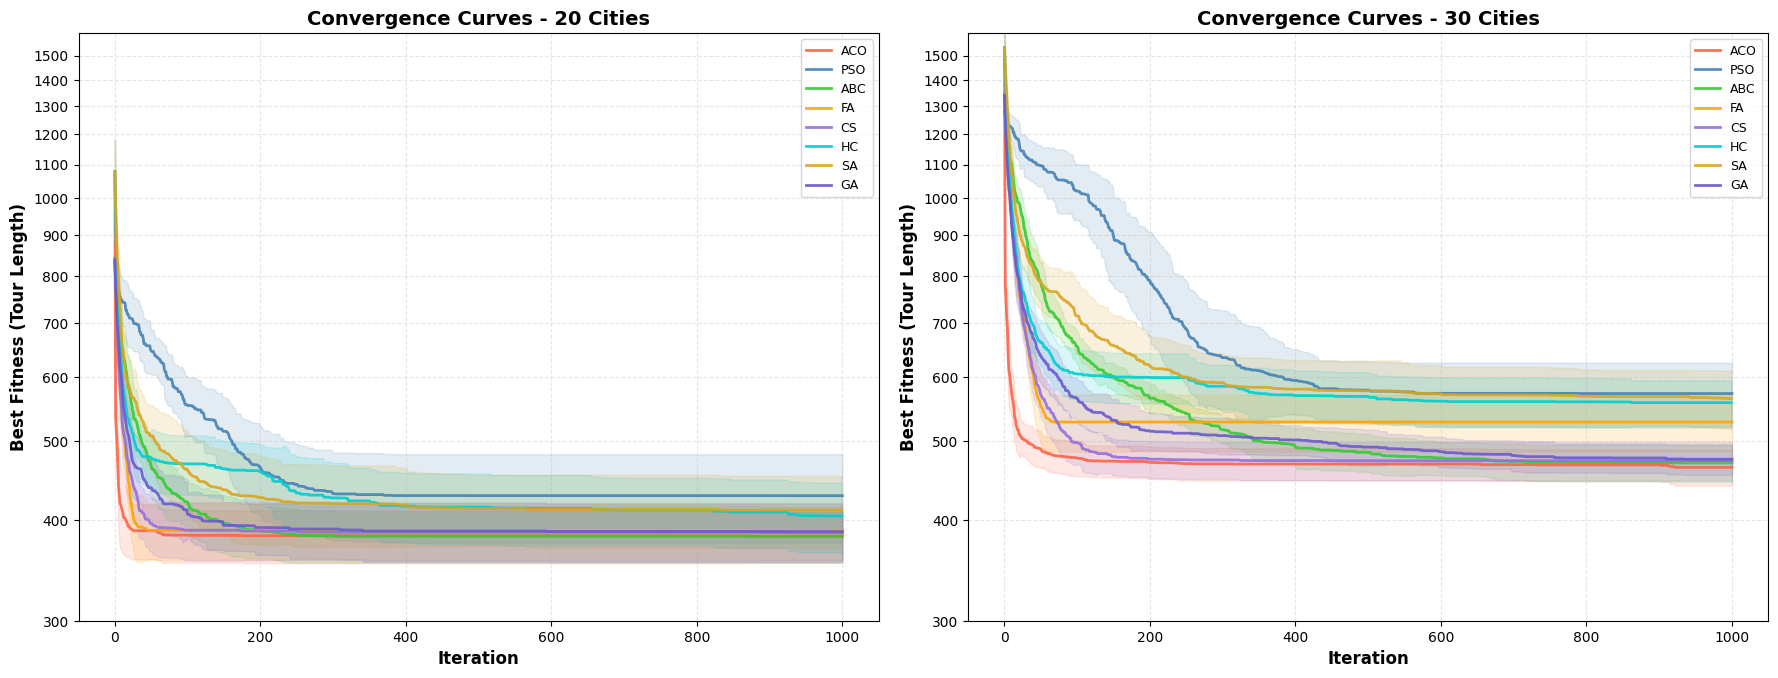

In [ ]:
#======================================================================
# 1. BIỂU ĐỒ CONVERGENCE CURVES (Đường hội tụ)
#======================================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
axes = axes.flatten()

for idx, n_cities in enumerate(CITY_SIZES):
    ax = axes[idx]

    # Tìm y_min và y_max thực tế để đặt giới hạn trục
    min_val_overall = float('inf')
    max_val_overall = float('-inf')

    for algorithm_name, results_list in all_results[n_cities].items():
        if results_list:
            histories = [r['convergence_history'] for r in results_list]
            if not histories: continue

            mean_history = np.mean(histories, axis=0)
            std_history = np.std(histories, axis=0)

            # Cập nhật min/max
            min_val_overall = min(min_val_overall, np.min(mean_history - std_history))
            max_val_overall = max(max_val_overall, np.max(mean_history + std_history))

            iterations = np.arange(len(mean_history))

            ax.plot(iterations, mean_history,
                   label=algorithm_name,
                   color=colors[algorithm_name],
                   linewidth=2, alpha=0.9)

            ax.fill_between(iterations,
                           mean_history - std_history,
                           mean_history + std_history,
                           color=colors[algorithm_name],
                           alpha=0.15)

    ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax.set_ylabel('Best Fitness (Tour Length)', fontsize=12, fontweight='bold')
    ax.set_title(f'Convergence Curves - {n_cities} Cities',
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, which='both', alpha=0.3, linestyle='--')
    ax.set_yscale('log')

    y_ticks = [300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
    ax.set_yticks(y_ticks)

    # 2. Sử dụng lại ScalarFormatter để đảm bảo các số được hiển thị bình thường
    formatter = mticker.ScalarFormatter()
    formatter.set_scientific(False)
    ax.yaxis.set_major_formatter(formatter)

    # 3. (Tùy chọn) Đặt giới hạn cho trục Y để zoom vào vùng dữ liệu chính
    ax.set_ylim(bottom=300, top=max(y_ticks) + 100)
    # =================================================================

plt.tight_layout(pad=1.5)
plt.savefig('tsp_convergence_curves_detailed.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu: tsp_convergence_curves_detailed.png")
plt.show()

✓ Đã lưu: tsp_boxplots.png


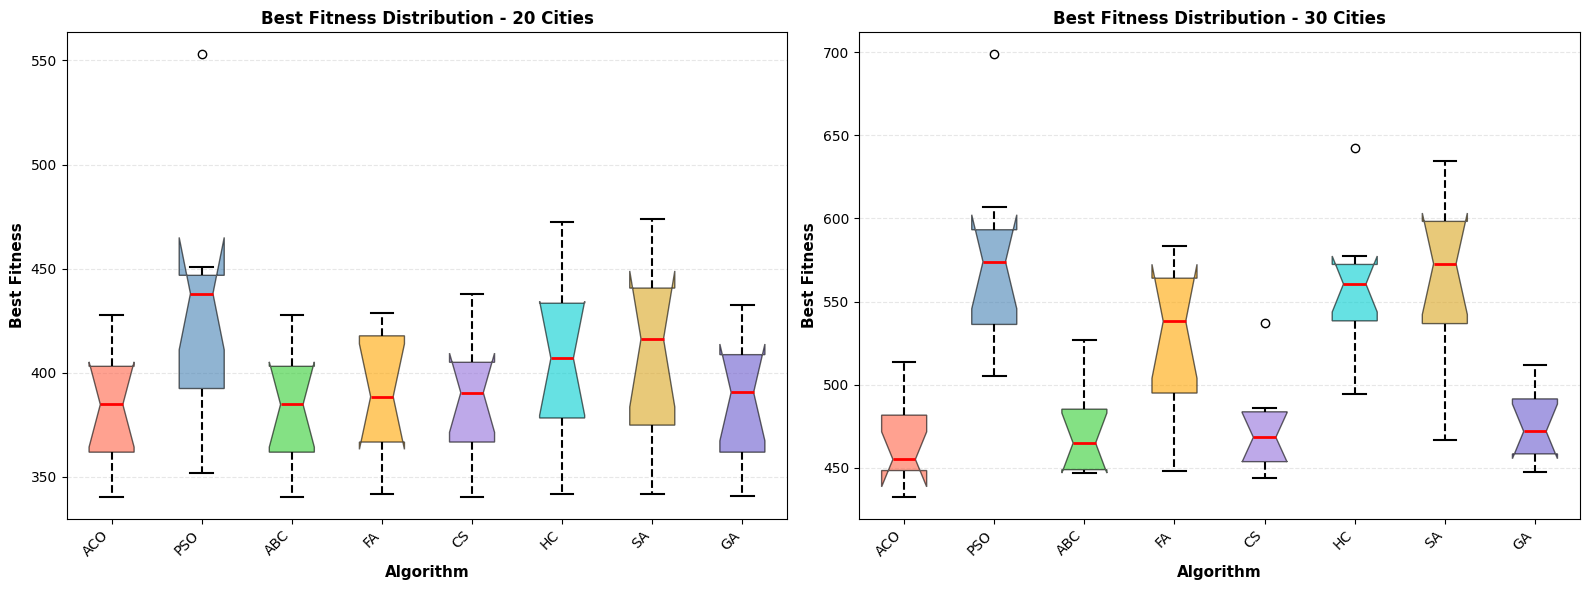

In [ ]:
# =============================================================================
# 2. BOX PLOTS - Phân bố Best Fitness
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes = axes.flatten()

for idx, n_cities in enumerate(CITY_SIZES):
    ax = axes[idx]

    data_to_plot = []
    labels = []
    colors_list = []

    for algorithm_name in ALL_ALGORITHMS:
        if algorithm_name in all_results[n_cities]:
            results_list = all_results[n_cities][algorithm_name]
            if results_list:
                best_fitnesses = [r['best_fitness'] for r in results_list]
                data_to_plot.append(best_fitnesses)
                labels.append(algorithm_name)
                colors_list.append(colors[algorithm_name])

    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True,
                    notch=True, showfliers=True)

    # Tô màu cho các box
    for patch, color in zip(bp['boxes'], colors_list):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    # Tùy chỉnh whiskers và caps
    for whisker in bp['whiskers']:
        whisker.set(linewidth=1.5, linestyle='--')
    for cap in bp['caps']:
        cap.set(linewidth=1.5)
    for median in bp['medians']:
        median.set(color='red', linewidth=2)

    ax.set_xlabel('Algorithm', fontsize=11, fontweight='bold')
    ax.set_ylabel('Best Fitness', fontsize=11, fontweight='bold')
    ax.set_title(f'Best Fitness Distribution - {n_cities} Cities',
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('tsp_boxplots.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu: tsp_boxplots.png")
plt.show()

✓ Đã lưu: tsp_mean_comparison.png


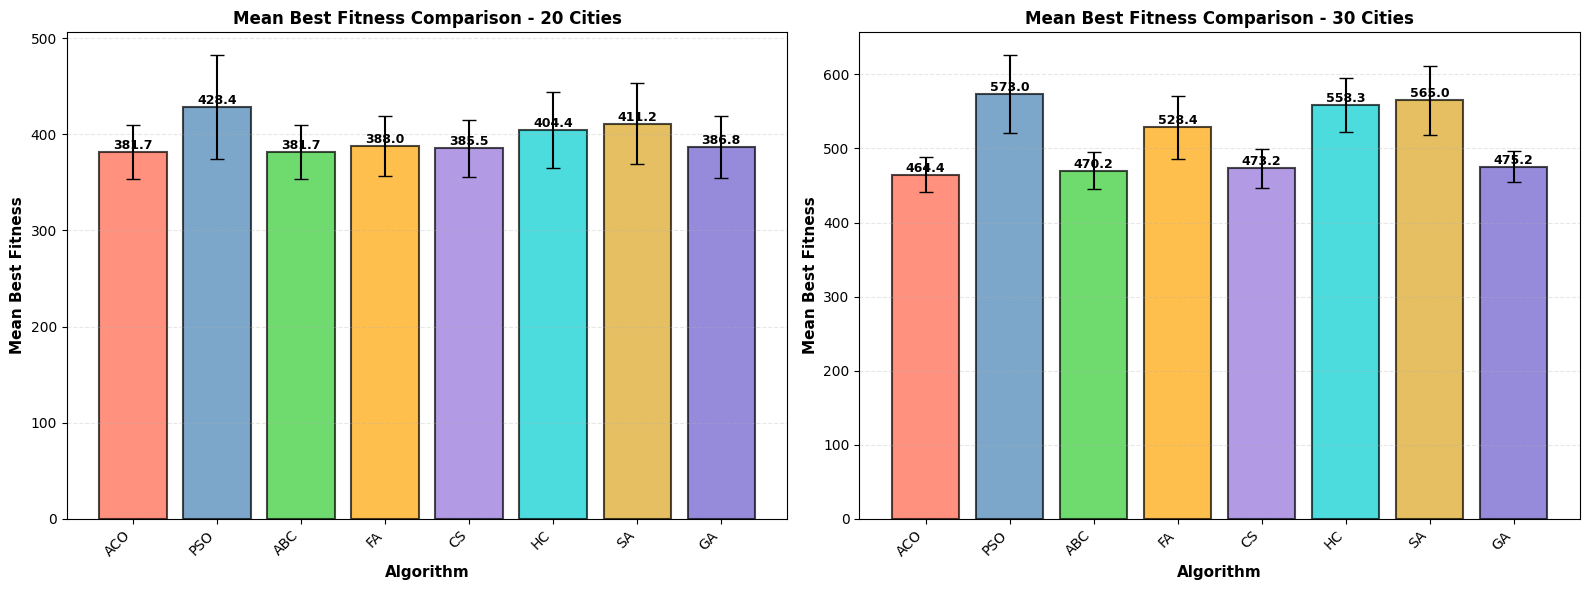

In [ ]:
# =============================================================================
# 3. BAR CHARTS - So sánh Mean Best Fitness
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes = axes.flatten()

for idx, n_cities in enumerate(CITY_SIZES):
    ax = axes[idx]

    algorithms = []
    means = []
    stds = []
    colors_list = []

    for algorithm_name in ALL_ALGORITHMS:
        if algorithm_name in all_results[n_cities]:
            results_list = all_results[n_cities][algorithm_name]
            if results_list:
                best_fitnesses = [r['best_fitness'] for r in results_list]
                algorithms.append(algorithm_name)
                means.append(np.mean(best_fitnesses))
                stds.append(np.std(best_fitnesses))
                colors_list.append(colors[algorithm_name])

    bars = ax.bar(algorithms, means, yerr=stds, capsize=5,
                  color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

    # Thêm giá trị trên các cột
    for bar, mean_val in zip(bars, means):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{mean_val:.1f}',
               ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xlabel('Algorithm', fontsize=11, fontweight='bold')
    ax.set_ylabel('Mean Best Fitness', fontsize=11, fontweight='bold')
    ax.set_title(f'Mean Best Fitness Comparison - {n_cities} Cities',
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('tsp_mean_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu: tsp_mean_comparison.png")
plt.show()

✓ Đã lưu: tsp_execution_time.png


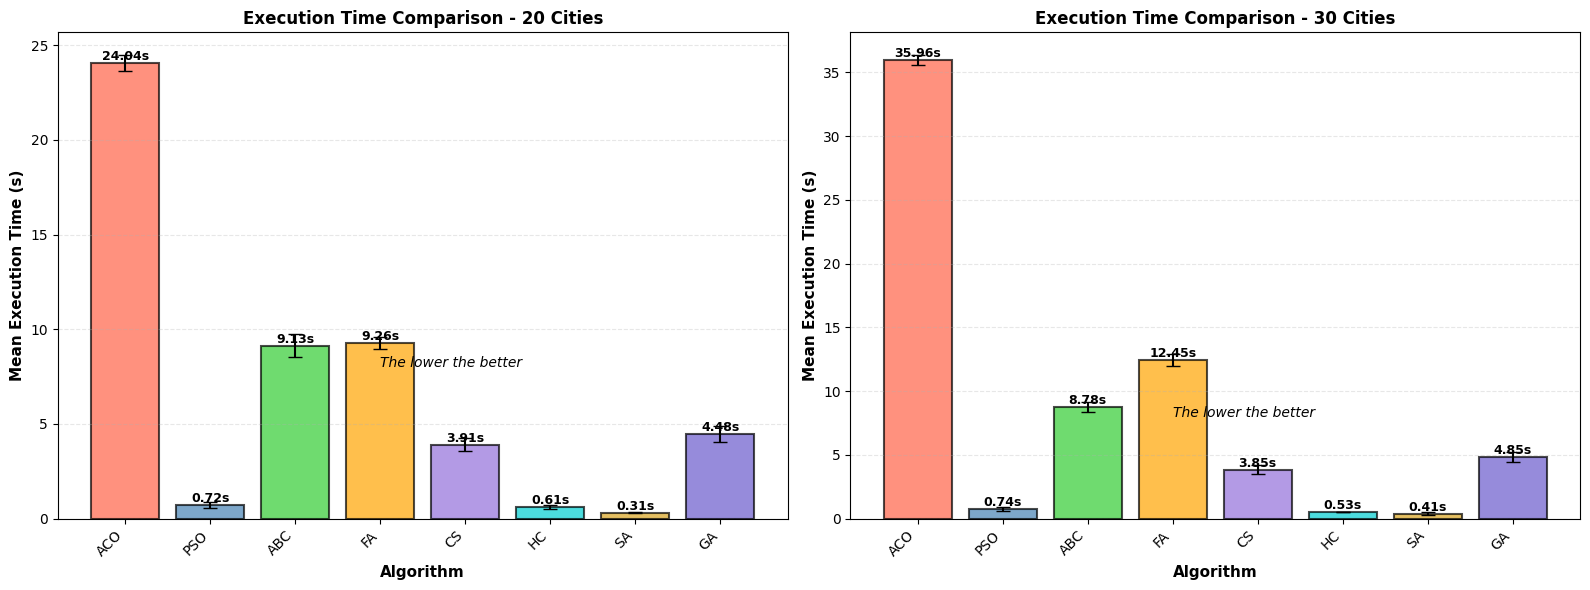

In [ ]:
# =============================================================================
# 4. EXECUTION TIME COMPARISON
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes = axes.flatten()

for idx, n_cities in enumerate(CITY_SIZES):
    ax = axes[idx]

    algorithms = []
    mean_times = []
    std_times = []
    colors_list = []

    for algorithm_name in ALL_ALGORITHMS:
        if algorithm_name in all_results[n_cities]:
            results_list = all_results[n_cities][algorithm_name]
            if results_list:
                exec_times = [r['execution_time'] for r in results_list]
                algorithms.append(algorithm_name)
                mean_times.append(np.mean(exec_times))
                std_times.append(np.std(exec_times))
                colors_list.append(colors[algorithm_name])

    bars = ax.bar(algorithms, mean_times, yerr=std_times, capsize=5,
                  color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

    # Thêm giá trị
    for bar, time_val in zip(bars, mean_times):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{time_val:.2f}s',
               ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xlabel('Algorithm', fontsize=11, fontweight='bold')
    ax.set_ylabel('Mean Execution Time (s)', fontsize=11, fontweight='bold')
    ax.set_title(f'Execution Time Comparison - {n_cities} Cities',
                fontsize=12, fontweight='bold')
    ax.text(3, 8, "The lower the better", style="italic")
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('tsp_execution_time.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu: tsp_execution_time.png")
plt.show()

✓ Đã lưu: tsp_scalability.png


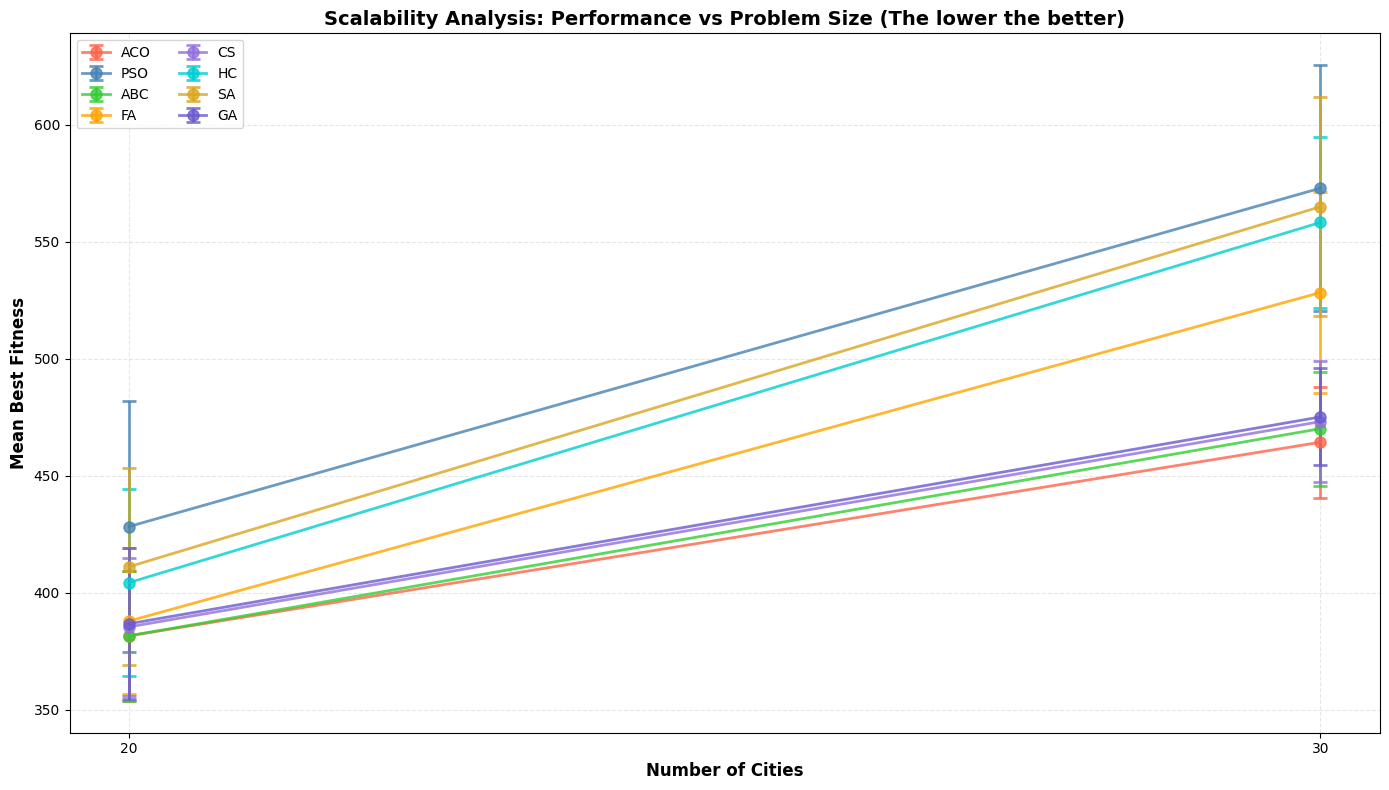

In [ ]:
# =============================================================================
# 5. COMBINED PLOT - Best Fitness vs Cities Size
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

for algorithm_name in ALL_ALGORITHMS:
    mean_fitnesses = []
    std_fitnesses = []
    cities_with_data = []

    for n_cities in CITY_SIZES:
        if algorithm_name in all_results[n_cities]:
            results_list = all_results[n_cities][algorithm_name]
            if results_list:
                best_fitnesses = [r['best_fitness'] for r in results_list]
                mean_fitnesses.append(np.mean(best_fitnesses))
                std_fitnesses.append(np.std(best_fitnesses))
                cities_with_data.append(n_cities)

    if mean_fitnesses:
        ax.errorbar(cities_with_data, mean_fitnesses, yerr=std_fitnesses,
                   label=algorithm_name, marker='o', markersize=8,
                   linewidth=2, capsize=5, capthick=2,
                   color=colors[algorithm_name], alpha=0.8)

ax.set_xlabel('Number of Cities', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Best Fitness', fontsize=12, fontweight='bold')
ax.set_title('Scalability Analysis: Performance vs Problem Size (The lower the better)',
            fontsize=14, fontweight='bold')
# ax.text(3, 8, "The lower the better", style="italic")
ax.legend(loc='upper left', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xticks(CITY_SIZES)

plt.tight_layout()
plt.savefig('tsp_scalability.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu: tsp_scalability.png")
plt.show()

## Continuous Problem

In [ ]:
# =============================================================================
# CẤU HÌNH THỬ NGHIỆM - CONTINUOUS PROBLEMS
# =============================================================================

CONTINUOUS_PROBLEMS = ['sphere', 'rastrigin', 'rosenbrock', 'ackley']
DIMENSIONS = [10]
N_RUNS = 10
MAX_ITERATIONS = 1000
SEED_BASE = 42
CONTINUOUS_ALGORITHMS = ['ACO', 'PSO', 'ABC', 'FA', 'CS', 'HC', 'SA', 'GA']

colors_cont = {
    'ACO': '#FF6347',  # Tomato
    'PSO': '#4682B4',  # SteelBlue
    'ABC': '#32CD32',  # LimeGreen
    'FA': '#FFA500',   # Orange
    'CS': '#9370DB',   # MediumPurple
    'HC': '#00CED1',   # DarkTurquoise
    'SA': '#e74c3c',   # Red
    'GA': '#34495e'    # Dark Blue
}

# =============================================================================
# HÀM CHẠY THỬ NGHIỆM CHO CONTINUOUS PROBLEMS
# =============================================================================

def run_continuous_experiment(problem, algorithm_name, seed):
    """Chạy một thử nghiệm với thuật toán và bài toán liên tục cụ thể."""

    if algorithm_name == 'ACO':
        optimizer = AntColonyOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            population_size=50,
            archive_size=50,
            q_acor=0.01,
            xi=0.85
        )

    elif algorithm_name == 'PSO':
        optimizer = ParticleSwarmOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=1000,
            seed=seed,
            population_size=50,
            w_max=0.9,
            w_min=0.4,
            c1_start=2.5,
            c1_end=0.5,
            c2_start=0.5,
            c2_end=2.5,
            v_clamp_factor=0.2,
            stagnation_threshold=1e-8,
            stagnation_counter_max=50,
            reinit_fraction=0.3,
            use_constriction=True,
            verbose=False
        )

    elif algorithm_name == 'ABC':
        optimizer = ArtificialBeeColonyOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            population_size=50,
            limit=100
        )

    elif algorithm_name == 'FA':
        optimizer = FireflyAlgorithmOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            population_size=50,
            alpha=0.5,
            beta_0=1.0,
            gamma=0.01,
            k_best=15,
            alpha_damp=0.97
        )

    elif algorithm_name == 'CS':
        optimizer = CuckooSearchOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            population_size=50,
            p_a=0.25,
            alpha=1.0,
            beta=1.5
        )

    elif algorithm_name == 'HC':
        optimizer = HillClimbingOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            n_neighbors=20,
            step_size=0.1,
            use_restarts=True,
            stagnation_limit=50
        )

    elif algorithm_name == 'SA':
        optimizer = SimulatedAnnealingOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            initial_temp=1000.0,
            cooling_rate=0.95,
            min_temp=1e-5,
            step_size=0.5,
            cooling_schedule='fast',
            use_reheating=True,
            stagnation_limit=100,
            reheat_fraction=0.2,
            n_neighbors=10,
            neighbor_selection='best'
        )

    elif algorithm_name == 'GA':
        optimizer = GeneticAlgorithmOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            population_size=50,
            crossover_rate=0.8,
            mutation_rate=0.1,
            tournament_size_ratio=0.2,
            elitism_size=2
        )

    else:
        raise ValueError(f"Unknown algorithm: {algorithm_name}")

    results = optimizer.run()
    return results

In [ ]:
# =============================================================================
# CHẠY TẤT CẢ CÁC THỬ NGHIỆM
# =============================================================================

continuous_results = {}

print("=" * 80)
print("BẮT ĐẦU THỬ NGHIỆM CÁC THUẬT TOÁN VỚI BÀI TOÁN LIÊN TỤC")
print("=" * 80)

for problem_name in CONTINUOUS_PROBLEMS:
    continuous_results[problem_name] = {}

    for n_dims in DIMENSIONS:
        print(f"\n{'='*80}")
        print(f"PROBLEM: {problem_name.upper()} | DIMENSIONS: {n_dims}")
        print(f"{'='*80}")

        continuous_results[problem_name][n_dims] = {}

        for algorithm_name in CONTINUOUS_ALGORITHMS:
            print(f"\n{'-'*80}")
            print(f"Thuật toán: {algorithm_name}")
            print(f"{'-'*80}")

            algorithm_results = []

            for run_idx in range(N_RUNS):
                seed = SEED_BASE + run_idx

                # Tạo bài toán với seed cụ thể
                problem = Problem(problem_name, n_dims=n_dims, seed=seed)

                print(f"  Run {run_idx + 1}/{N_RUNS} (seed={seed})...", end=" ")

                try:
                    results = run_continuous_experiment(problem, algorithm_name, seed)
                    algorithm_results.append(results)
                    print(f"✓ Best: {results['best_fitness']:.6e}, Time: {results['execution_time']:.3f}s")
                except Exception as e:
                    print(f"✗ Error: {str(e)}")
                    continue

            continuous_results[problem_name][n_dims][algorithm_name] = algorithm_results

            # Thống kê tóm tắt
            if algorithm_results:
                best_fitnesses = [r['best_fitness'] for r in algorithm_results]
                exec_times = [r['execution_time'] for r in algorithm_results]
                print(f"\n  Tóm tắt {algorithm_name}:")
                print(f"    Best fitness - Min: {np.min(best_fitnesses):.6e}, "
                      f"Mean: {np.mean(best_fitnesses):.6e}, "
                      f"Max: {np.max(best_fitnesses):.6e}, "
                      f"Std: {np.std(best_fitnesses):.6e}")
                print(f"    Execution time - Mean: {np.mean(exec_times):.3f}s, "
                      f"Std: {np.std(exec_times):.3f}s")

print(f"\n{'='*80}")
print("HOÀN THÀNH TẤT CẢ CÁC THỬ NGHIỆM!")
print(f"{'='*80}\n")

BẮT ĐẦU THỬ NGHIỆM CÁC THUẬT TOÁN VỚI BÀI TOÁN LIÊN TỤC

PROBLEM: SPHERE | DIMENSIONS: 10

--------------------------------------------------------------------------------
Thuật toán: ACO
--------------------------------------------------------------------------------
  Run 1/10 (seed=42)... Algorithm (seed=42) finished in 24.5594 seconds.
Best fitness: 0.0
✓ Best: 0.000000e+00, Time: 24.559s
  Run 2/10 (seed=43)... Algorithm (seed=43) finished in 24.8700 seconds.
Best fitness: 0.0
✓ Best: 0.000000e+00, Time: 24.870s
  Run 3/10 (seed=44)... Algorithm (seed=44) finished in 24.5615 seconds.
Best fitness: 0.0
✓ Best: 0.000000e+00, Time: 24.562s
  Run 4/10 (seed=45)... Algorithm (seed=45) finished in 24.7532 seconds.
Best fitness: 0.0
✓ Best: 0.000000e+00, Time: 24.753s
  Run 5/10 (seed=46)... Algorithm (seed=46) finished in 24.8482 seconds.
Best fitness: 0.0
✓ Best: 0.000000e+00, Time: 24.848s
  Run 6/10 (seed=47)... Algorithm (seed=47) finished in 24.7138 seconds.
Best fitness: 0.0
✓ Bes

✓ Đã lưu: continuous_sphere_convergence_10D.png


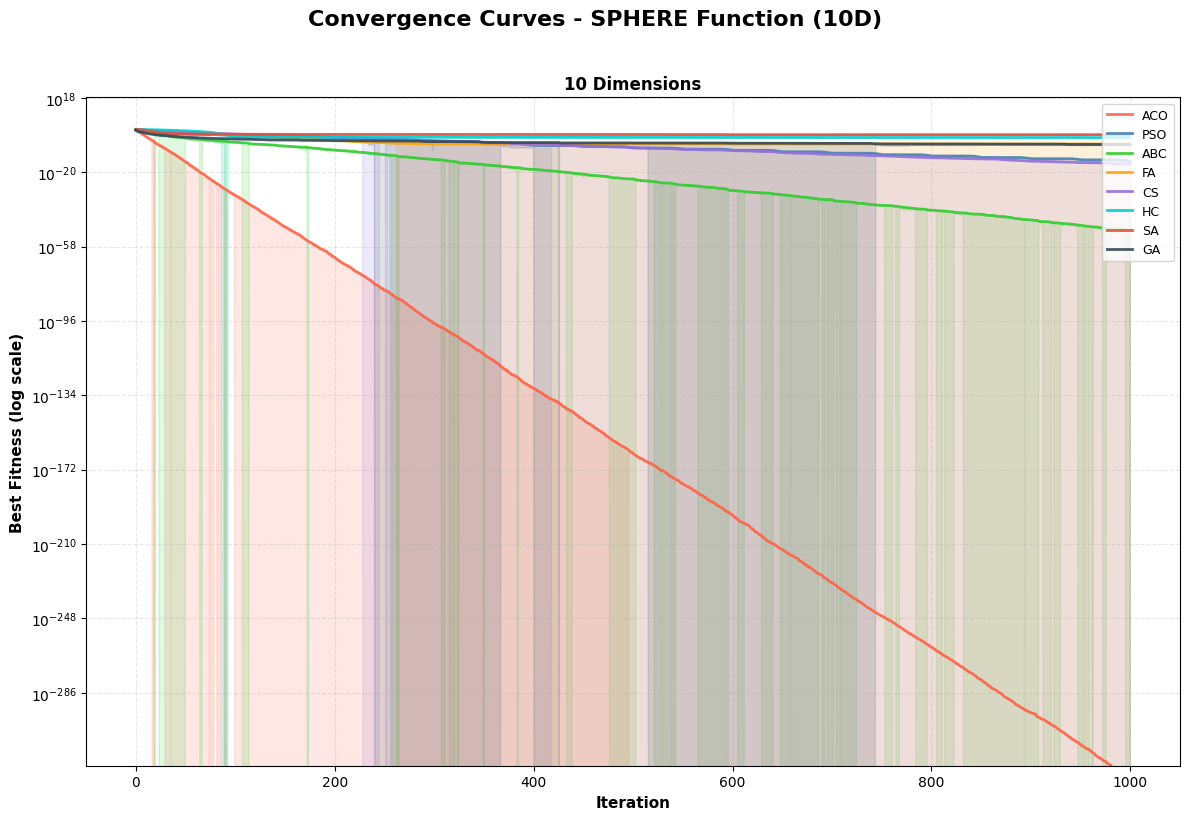

✓ Đã lưu: continuous_rastrigin_convergence_10D.png


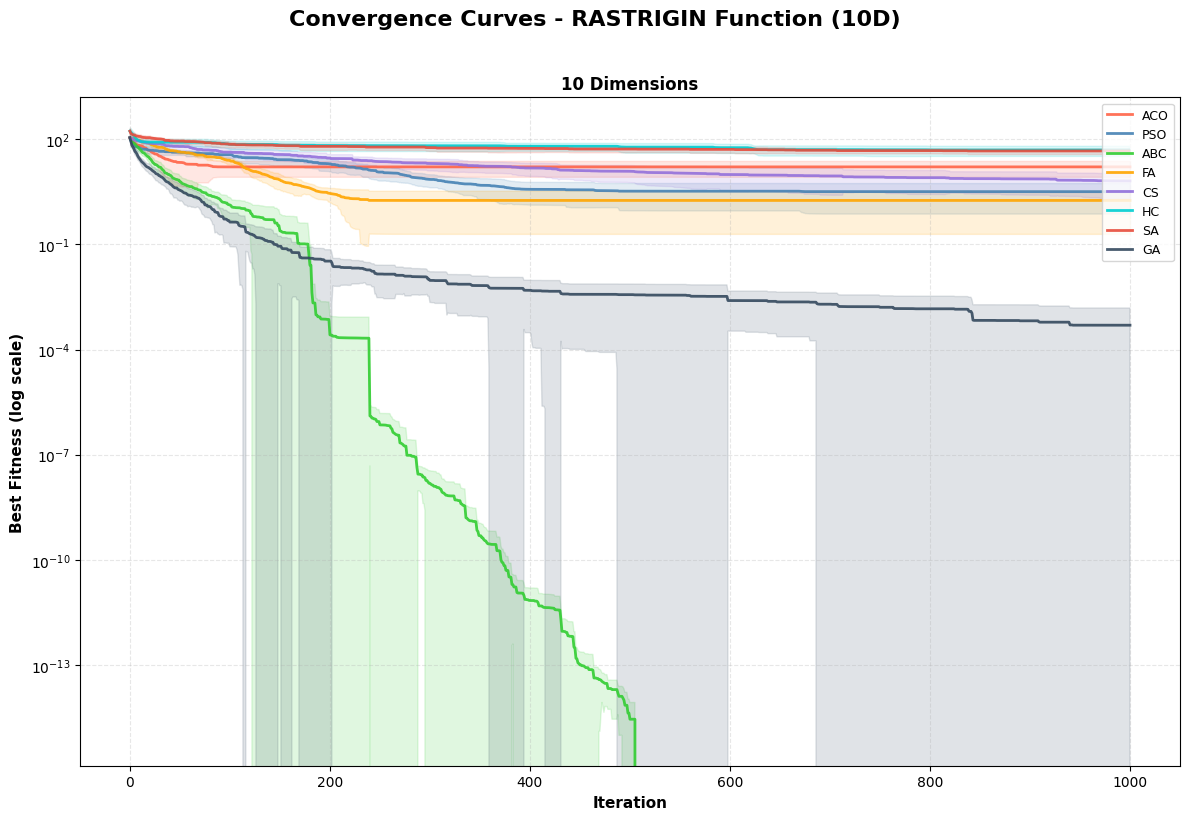

✓ Đã lưu: continuous_rosenbrock_convergence_10D.png


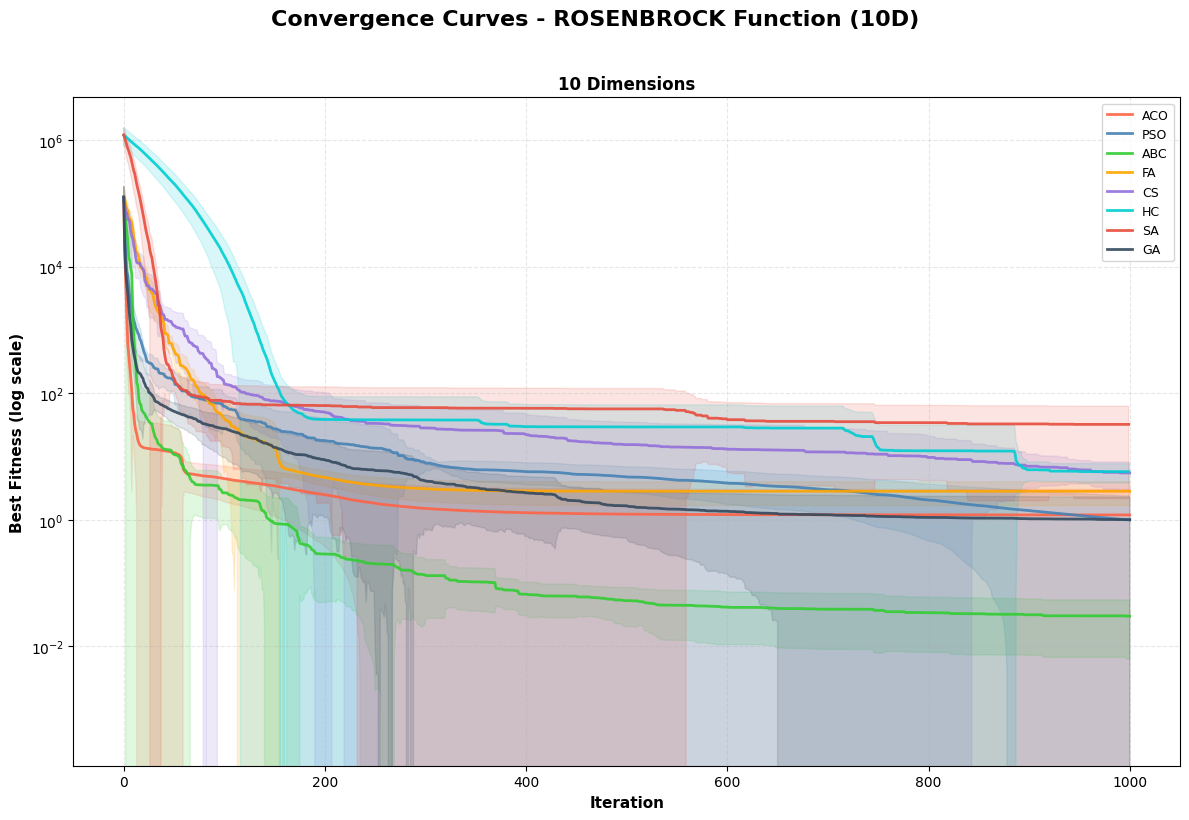

✓ Đã lưu: continuous_ackley_convergence_10D.png


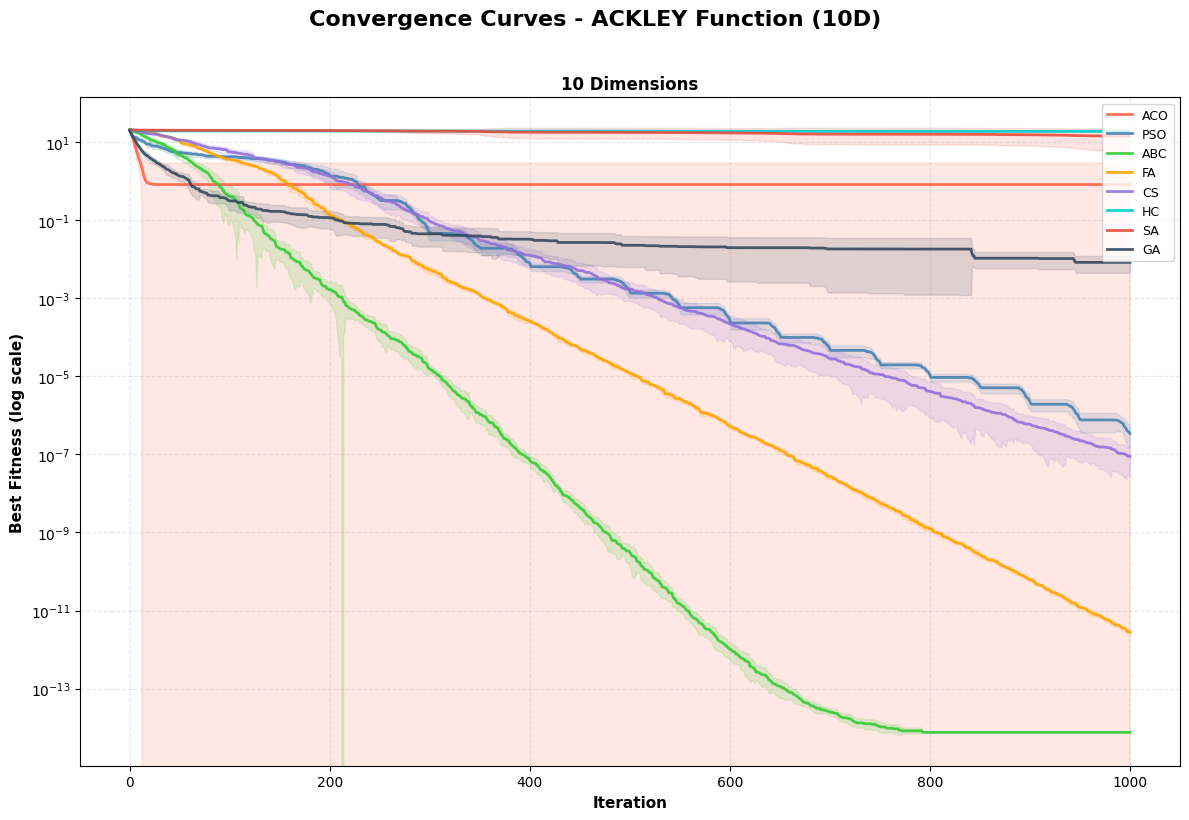

In [ ]:
# =============================================================================
# 1. CONVERGENCE CURVES - MỖI BÀI TOÁN MỘT FIGURE
# =============================================================================

for problem_name in CONTINUOUS_PROBLEMS:
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    fig.suptitle(f'Convergence Curves - {problem_name.upper()} Function (10D)',
                 fontsize=16, fontweight='bold', y=1.02)

    for algorithm_name in CONTINUOUS_ALGORITHMS:
        results_list = continuous_results[problem_name][10].get(algorithm_name, [])
        if results_list:
            histories = [r['convergence_history'] for r in results_list]
            if not histories: continue

            mean_history = np.mean(histories, axis=0)
            std_history = np.std(histories, axis=0)
            iterations = np.arange(len(mean_history))

            ax.plot(iterations, mean_history,
                   label=algorithm_name,
                   color=colors_cont[algorithm_name],
                   linewidth=2, alpha=0.9)

            ax.fill_between(iterations,
                           mean_history - std_history,
                           mean_history + std_history,
                           color=colors_cont[algorithm_name],
                           alpha=0.15)

    ax.set_xlabel('Iteration', fontsize=11, fontweight='bold')
    ax.set_ylabel('Best Fitness (log scale)', fontsize=11, fontweight='bold')
    ax.set_title('10 Dimensions', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, which='both', alpha=0.3, linestyle='--')
    ax.set_yscale('log')

    plt.tight_layout()
    plt.savefig(f'continuous_{problem_name}_convergence_10D.png', dpi=300, bbox_inches='tight')
    print(f"✓ Đã lưu: continuous_{problem_name}_convergence_10D.png")
    plt.show()

✓ Đã lưu: continuous_sphere_boxplots_10D.png


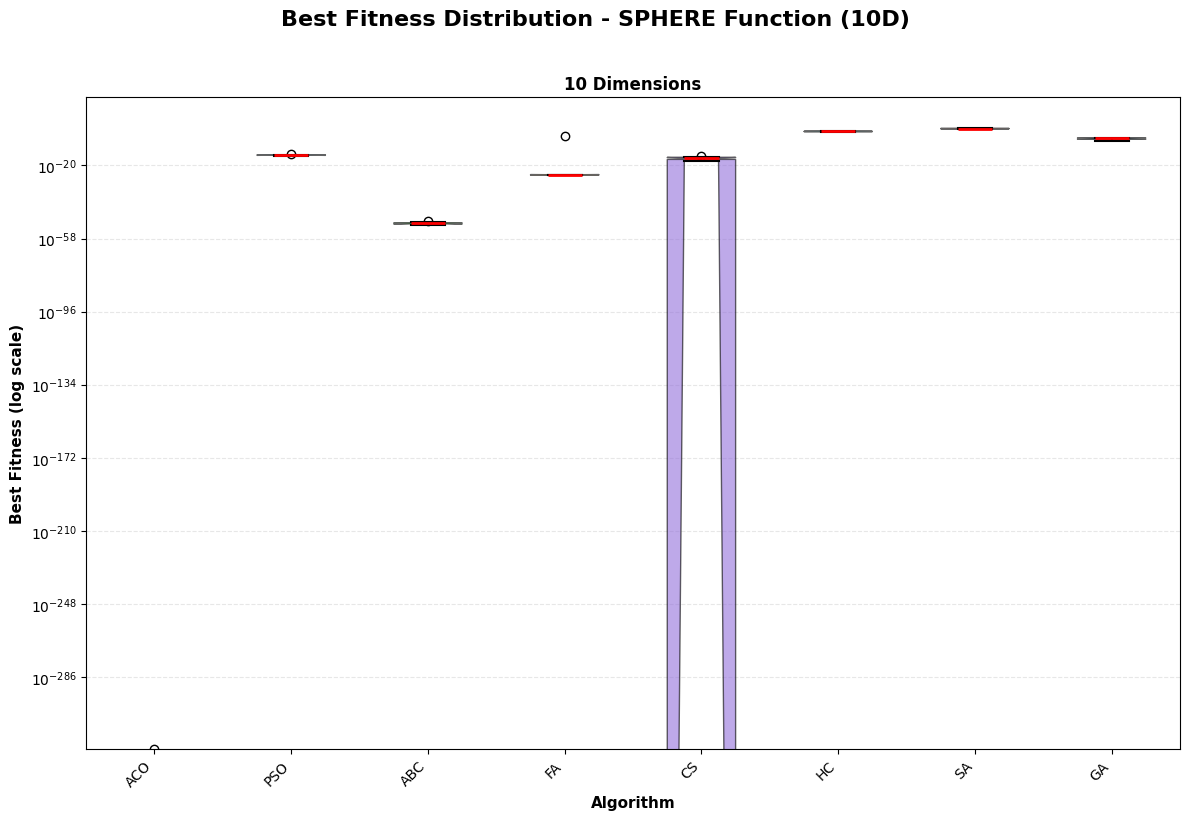

✓ Đã lưu: continuous_rastrigin_boxplots_10D.png


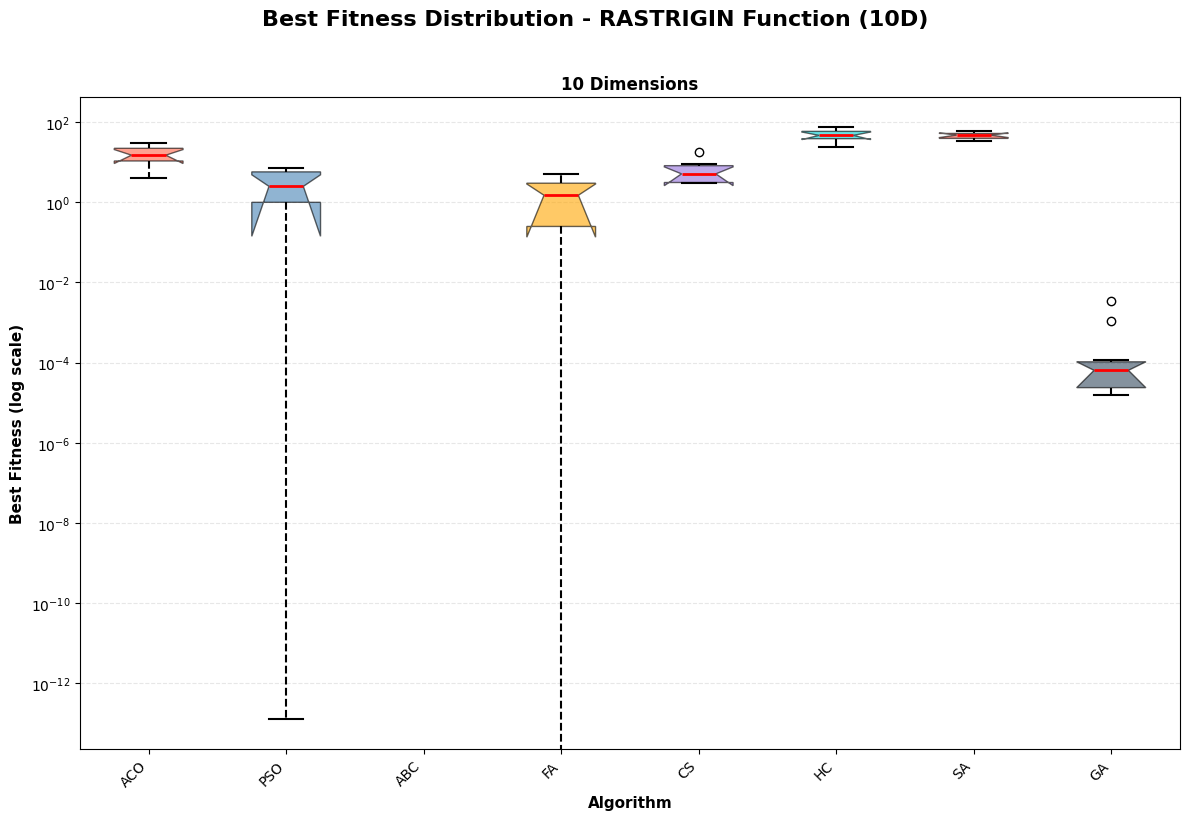

✓ Đã lưu: continuous_rosenbrock_boxplots_10D.png


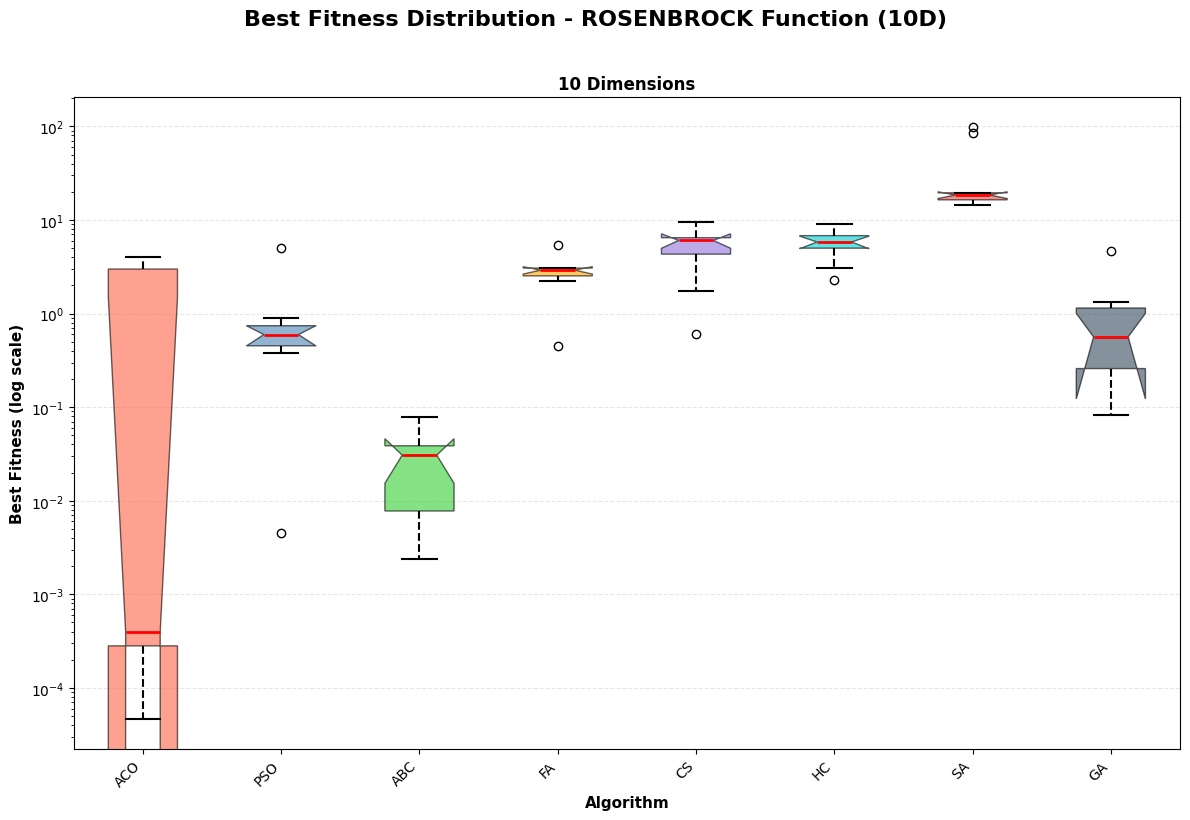

✓ Đã lưu: continuous_ackley_boxplots_10D.png


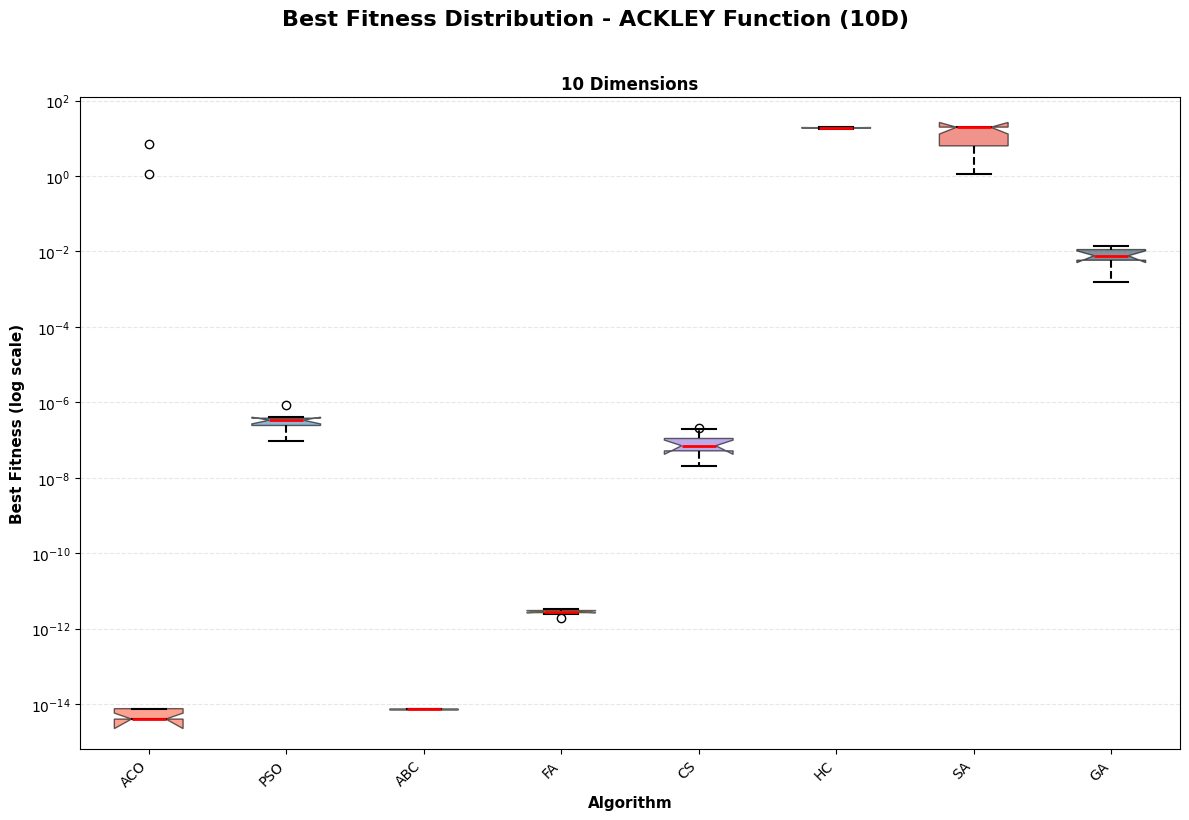

In [ ]:
# =============================================================================
# 2. BOX PLOTS - PHÂN BỐ BEST FITNESS
# =============================================================================

for problem_name in CONTINUOUS_PROBLEMS:
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    fig.suptitle(f'Best Fitness Distribution - {problem_name.upper()} Function (10D)',
                 fontsize=16, fontweight='bold', y=1.02)

    data_to_plot = []
    labels = []
    colors_list = []

    for algorithm_name in CONTINUOUS_ALGORITHMS:
        results_list = continuous_results[problem_name][10].get(algorithm_name, [])
        if results_list:
            best_fitnesses = [r['best_fitness'] for r in results_list]
            data_to_plot.append(best_fitnesses)
            labels.append(algorithm_name)
            colors_list.append(colors_cont[algorithm_name])

    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True,
                   notch=True, showfliers=True)

    for patch, color in zip(bp['boxes'], colors_list):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    for whisker in bp['whiskers']:
        whisker.set(linewidth=1.5, linestyle='--')
    for cap in bp['caps']:
        cap.set(linewidth=1.5)
    for median in bp['medians']:
        median.set(color='red', linewidth=2)

    ax.set_xlabel('Algorithm', fontsize=11, fontweight='bold')
    ax.set_ylabel('Best Fitness (log scale)', fontsize=11, fontweight='bold')
    ax.set_title('10 Dimensions', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax.set_yscale('log')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(f'continuous_{problem_name}_boxplots_10D.png', dpi=300, bbox_inches='tight')
    print(f"✓ Đã lưu: continuous_{problem_name}_boxplots_10D.png")
    plt.show()

✓ Đã lưu: continuous_sphere_mean_comparison_10D.png


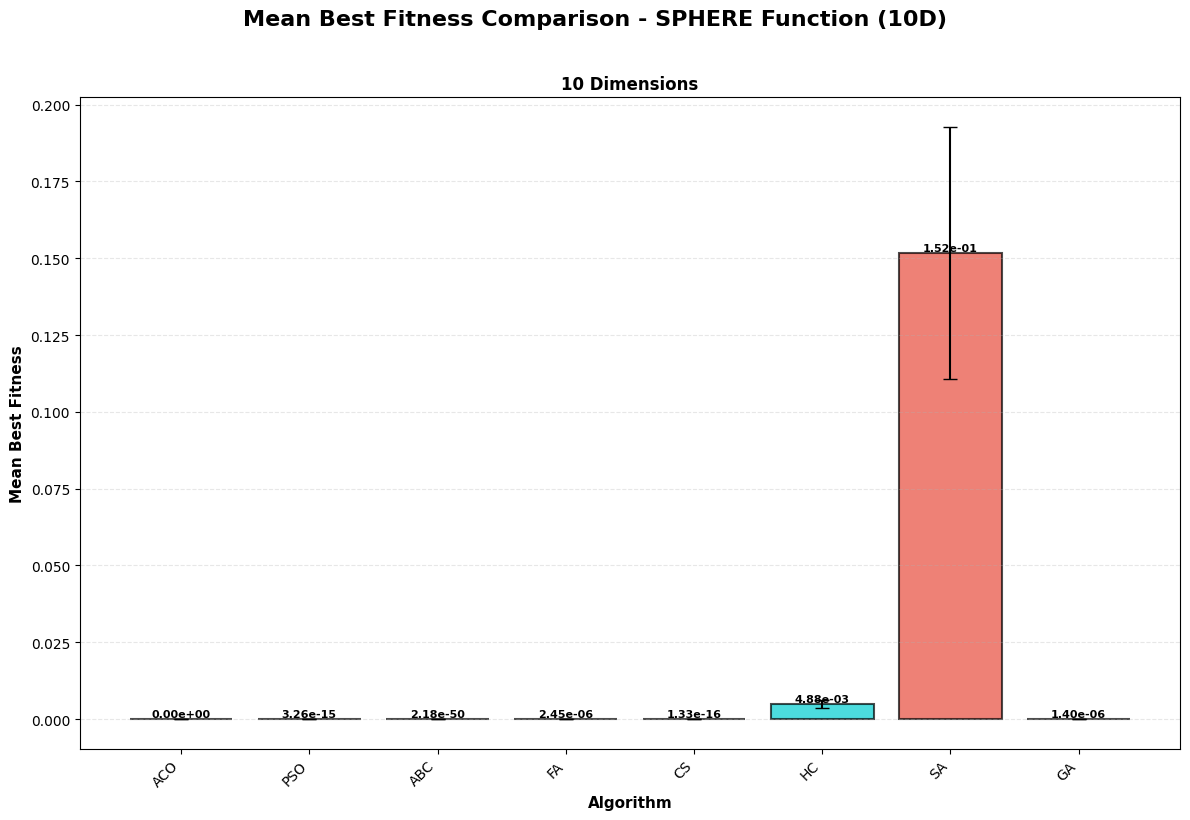

✓ Đã lưu: continuous_rastrigin_mean_comparison_10D.png


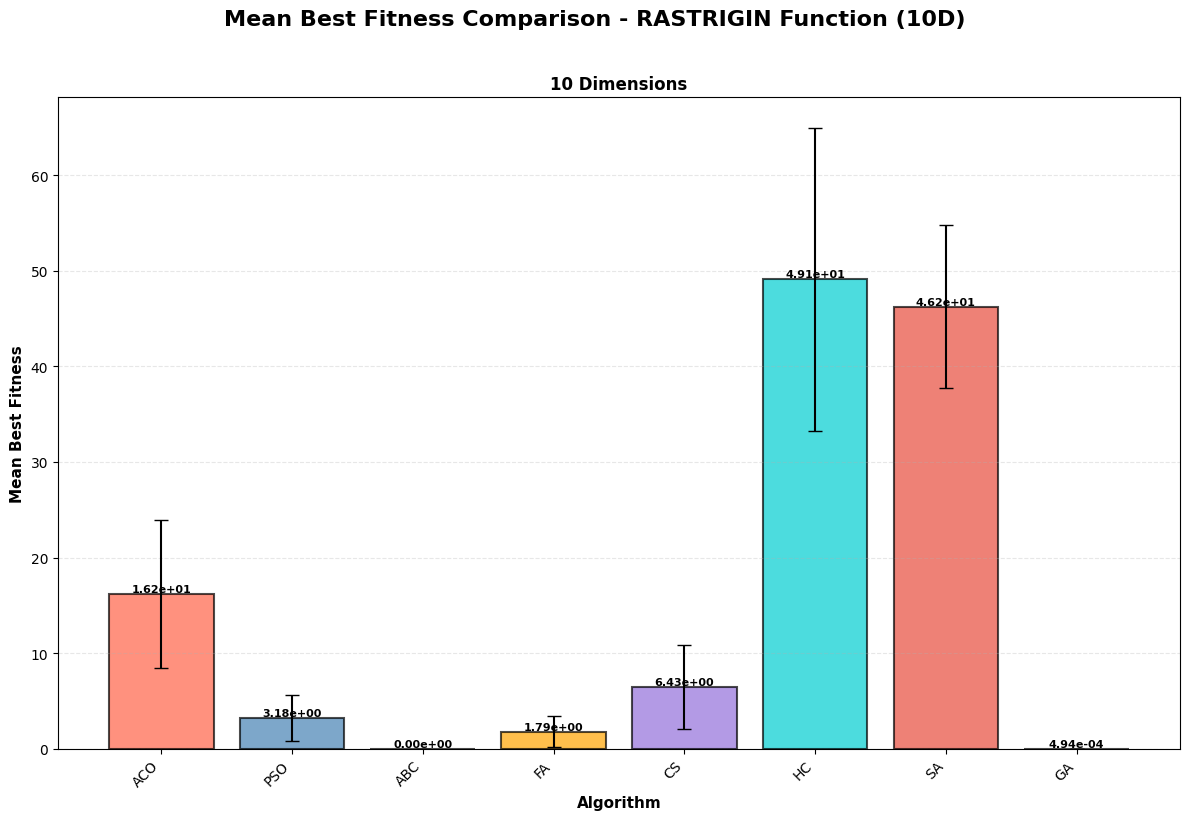

✓ Đã lưu: continuous_rosenbrock_mean_comparison_10D.png


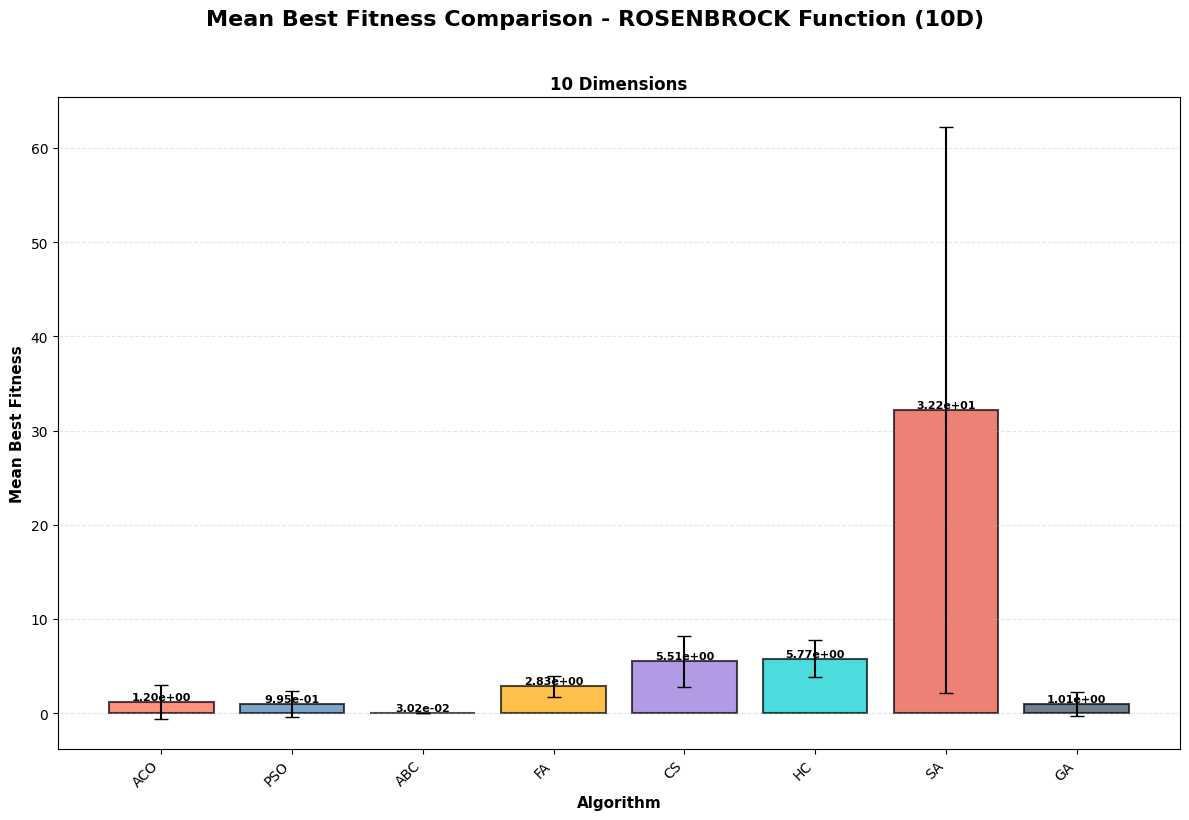

✓ Đã lưu: continuous_ackley_mean_comparison_10D.png


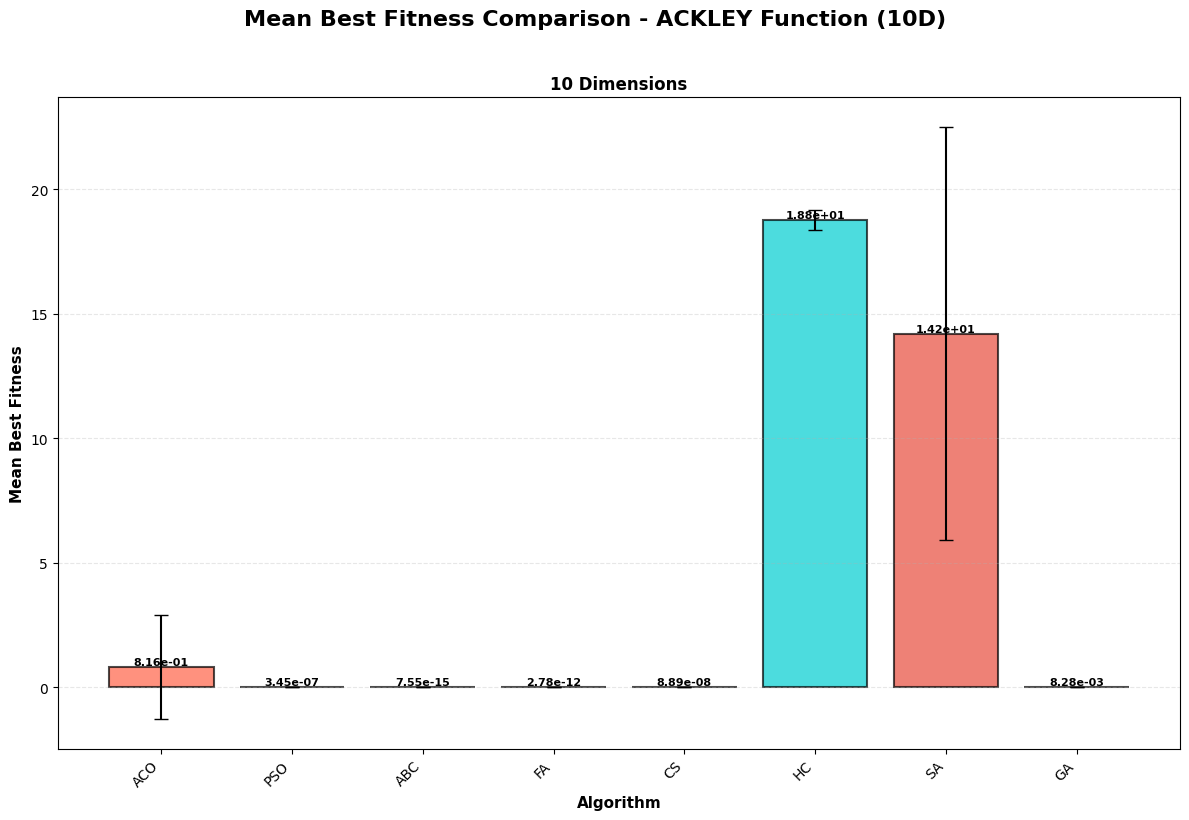

In [ ]:
# =============================================================================
# 3. BAR CHARTS - SO SÁNH MEAN BEST FITNESS
# =============================================================================

for problem_name in CONTINUOUS_PROBLEMS:
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    fig.suptitle(f'Mean Best Fitness Comparison - {problem_name.upper()} Function (10D)',
                 fontsize=16, fontweight='bold', y=1.02)

    algorithms = []
    means = []
    stds = []
    colors_list = []

    for algorithm_name in CONTINUOUS_ALGORITHMS:
        results_list = continuous_results[problem_name][10].get(algorithm_name, [])
        if results_list:
            best_fitnesses = [r['best_fitness'] for r in results_list]
            algorithms.append(algorithm_name)
            means.append(np.mean(best_fitnesses))
            stds.append(np.std(best_fitnesses))
            colors_list.append(colors_cont[algorithm_name])

    bars = ax.bar(algorithms, means, yerr=stds, capsize=5,
                 color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

    for bar, mean_val in zip(bars, means):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{mean_val:.2e}',
               ha='center', va='bottom', fontsize=8, fontweight='bold')

    ax.set_xlabel('Algorithm', fontsize=11, fontweight='bold')
    ax.set_ylabel('Mean Best Fitness', fontsize=11, fontweight='bold')
    ax.set_title('10 Dimensions', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(f'continuous_{problem_name}_mean_comparison_10D.png', dpi=300, bbox_inches='tight')
    print(f"✓ Đã lưu: continuous_{problem_name}_mean_comparison_10D.png")
    plt.show()

✓ Đã lưu: continuous_sphere_execution_time_10D.png


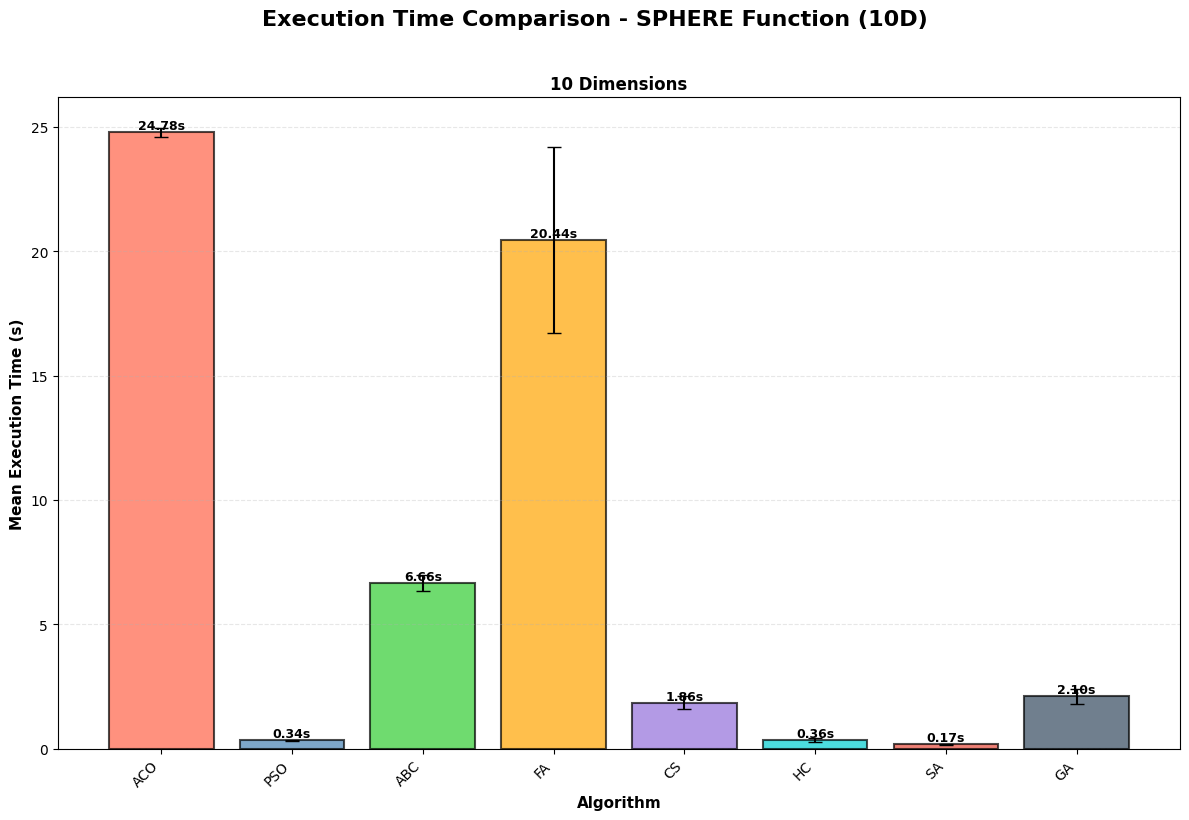

✓ Đã lưu: continuous_rastrigin_execution_time_10D.png


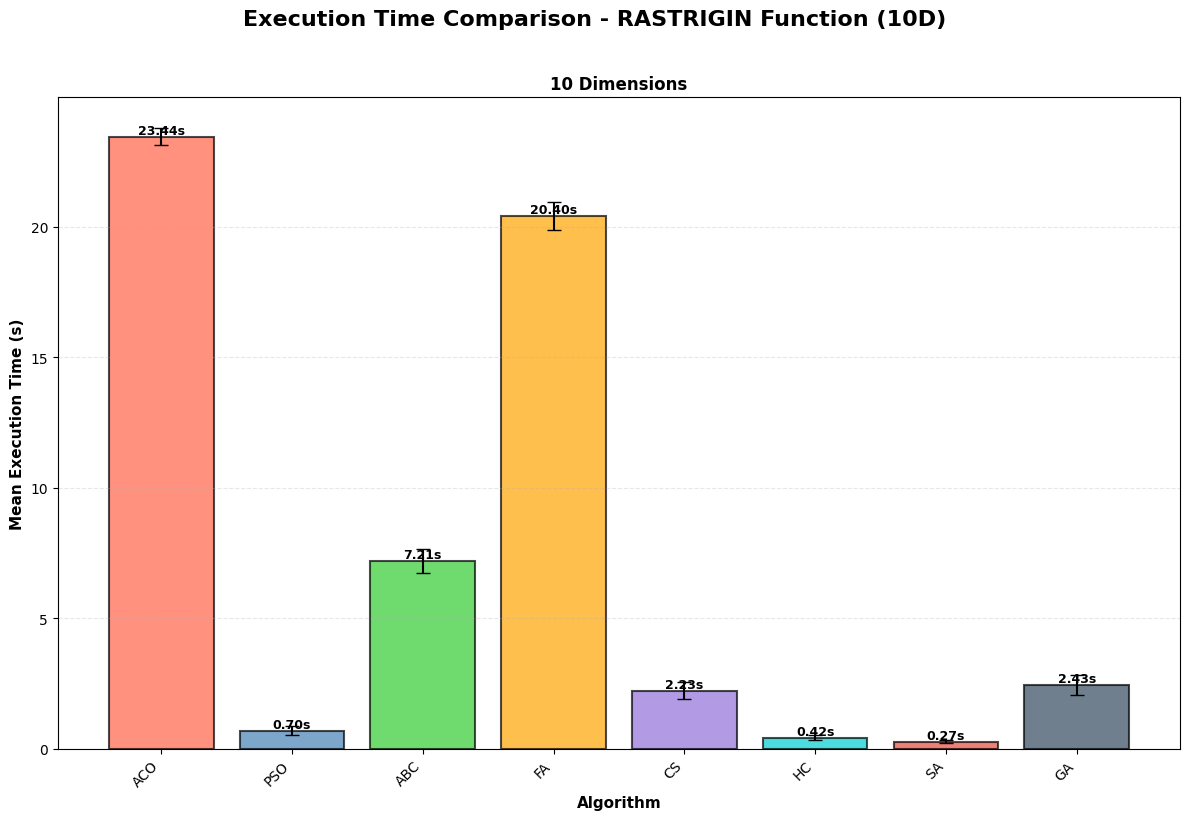

✓ Đã lưu: continuous_rosenbrock_execution_time_10D.png


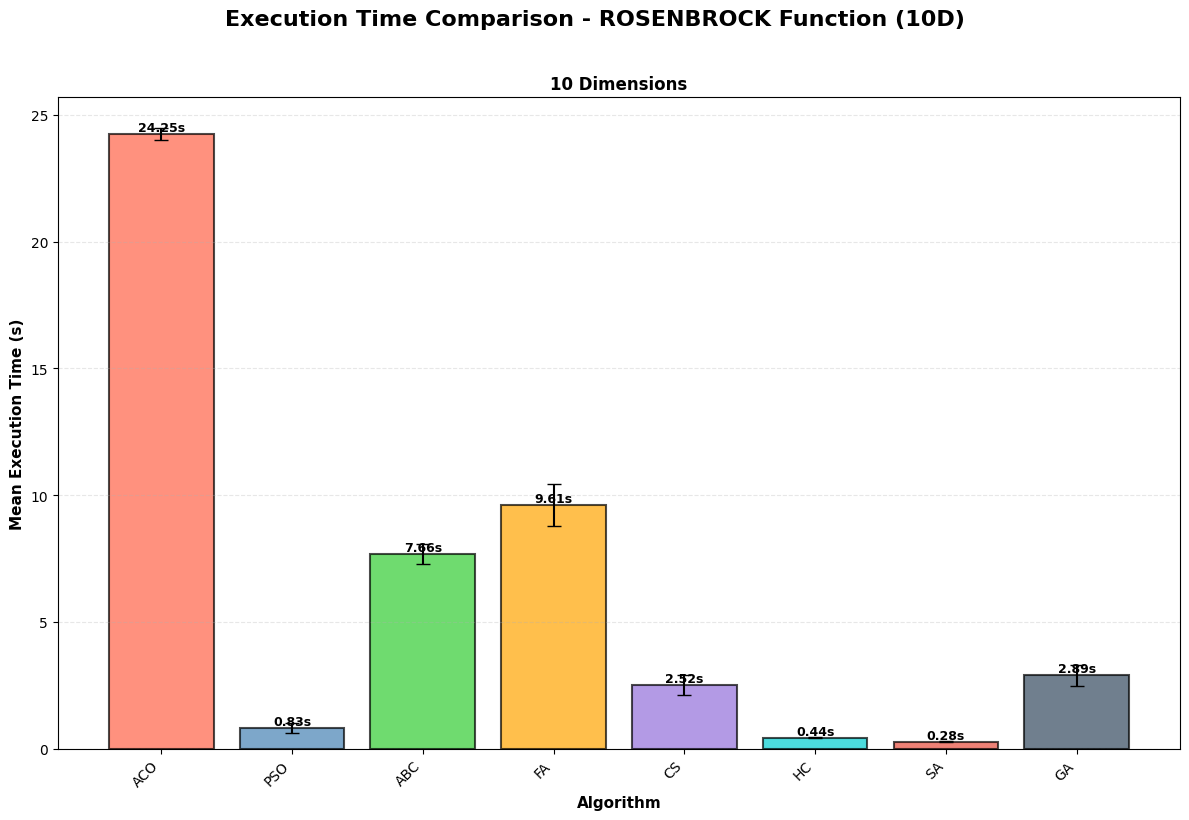

✓ Đã lưu: continuous_ackley_execution_time_10D.png


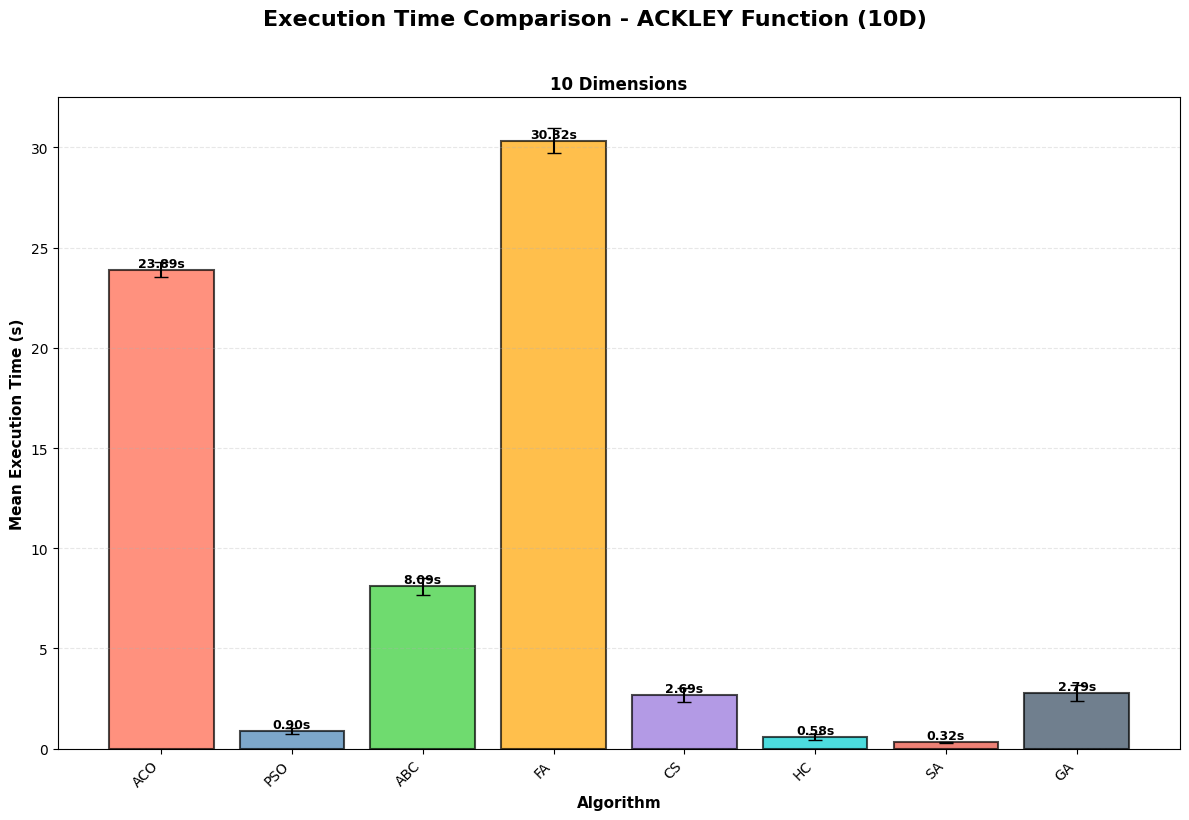

In [ ]:
# =============================================================================
# 4. EXECUTION TIME COMPARISON
# =============================================================================

for problem_name in CONTINUOUS_PROBLEMS:
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    fig.suptitle(f'Execution Time Comparison - {problem_name.upper()} Function (10D)',
                 fontsize=16, fontweight='bold', y=1.02)

    algorithms = []
    mean_times = []
    std_times = []
    colors_list = []

    for algorithm_name in CONTINUOUS_ALGORITHMS:
        results_list = continuous_results[problem_name][10].get(algorithm_name, [])
        if results_list:
            exec_times = [r['execution_time'] for r in results_list]
            algorithms.append(algorithm_name)
            mean_times.append(np.mean(exec_times))
            std_times.append(np.std(exec_times))
            colors_list.append(colors_cont[algorithm_name])

    bars = ax.bar(algorithms, mean_times, yerr=std_times, capsize=5,
                 color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

    for bar, time_val in zip(bars, mean_times):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{time_val:.2f}s',
               ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xlabel('Algorithm', fontsize=11, fontweight='bold')
    ax.set_ylabel('Mean Execution Time (s)', fontsize=11, fontweight='bold')
    ax.set_title('10 Dimensions', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(f'continuous_{problem_name}_execution_time_10D.png', dpi=300, bbox_inches='tight')
    print(f"✓ Đã lưu: continuous_{problem_name}_execution_time_10D.png")
    plt.show()

✓ Đã lưu: continuous_ranking_heatmap_10D.png


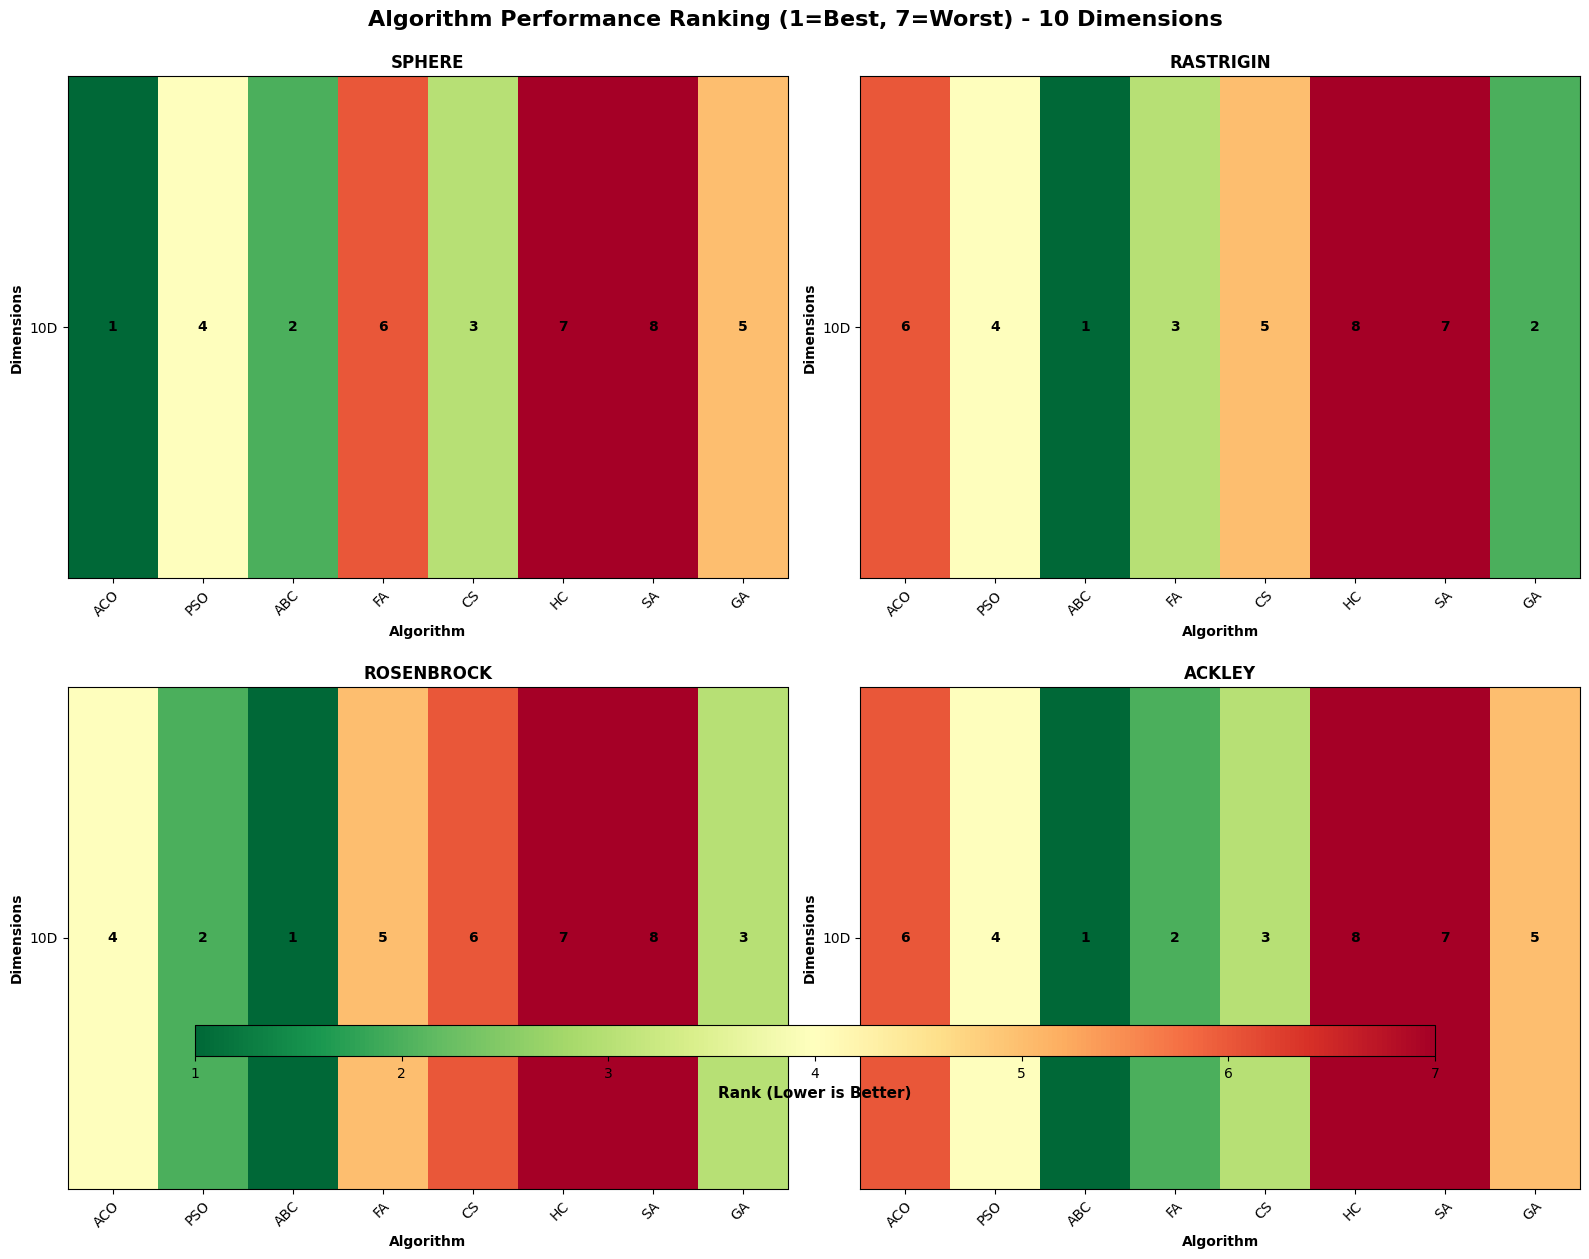

In [ ]:
# =============================================================================
# 5. HEATMAP - ALGORITHM RANKING BY PROBLEM
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Algorithm Performance Ranking (1=Best, 7=Worst) - 10 Dimensions',
             fontsize=16, fontweight='bold', y=0.995)
axes = axes.flatten()

for idx, problem_name in enumerate(CONTINUOUS_PROBLEMS):
    ax = axes[idx]

    ranking_matrix = []

    # Chỉ sử dụng 10D
    n_dims = 10
    rankings = {}
    for algorithm_name in CONTINUOUS_ALGORITHMS:
        results_list = continuous_results[problem_name][n_dims].get(algorithm_name, [])
        if results_list:
            best_fitnesses = [r['best_fitness'] for r in results_list]
            rankings[algorithm_name] = np.mean(best_fitnesses)

    # Sắp xếp và gán rank
    sorted_algs = sorted(rankings.items(), key=lambda x: x[1])
    rank_dict = {alg: rank+1 for rank, (alg, _) in enumerate(sorted_algs)}

    row = [rank_dict.get(alg, np.nan) for alg in CONTINUOUS_ALGORITHMS]
    ranking_matrix.append(row)

    ranking_matrix = np.array(ranking_matrix)

    im = ax.imshow(ranking_matrix, cmap='RdYlGn_r', aspect='auto', vmin=1, vmax=7)

    ax.set_xticks(np.arange(len(CONTINUOUS_ALGORITHMS)))
    ax.set_yticks([0])  # Chỉ có 1 dòng cho 10D
    ax.set_xticklabels(CONTINUOUS_ALGORITHMS)
    ax.set_yticklabels(['10D'])

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for j in range(len(CONTINUOUS_ALGORITHMS)):
        if not np.isnan(ranking_matrix[0, j]):
            text = ax.text(j, 0, int(ranking_matrix[0, j]),
                         ha="center", va="center", color="black", fontweight='bold')

    ax.set_title(f'{problem_name.upper()}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Algorithm', fontsize=10, fontweight='bold')
    ax.set_ylabel('Dimensions', fontsize=10, fontweight='bold')

cbar = fig.colorbar(im, ax=axes, orientation='horizontal',
                    fraction=0.05, pad=0.08, aspect=40)
cbar.set_label('Rank (Lower is Better)', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('continuous_ranking_heatmap_10D.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu: continuous_ranking_heatmap_10D.png")
plt.show()

✓ Đã lưu: continuous_sphere_violin_10D.png


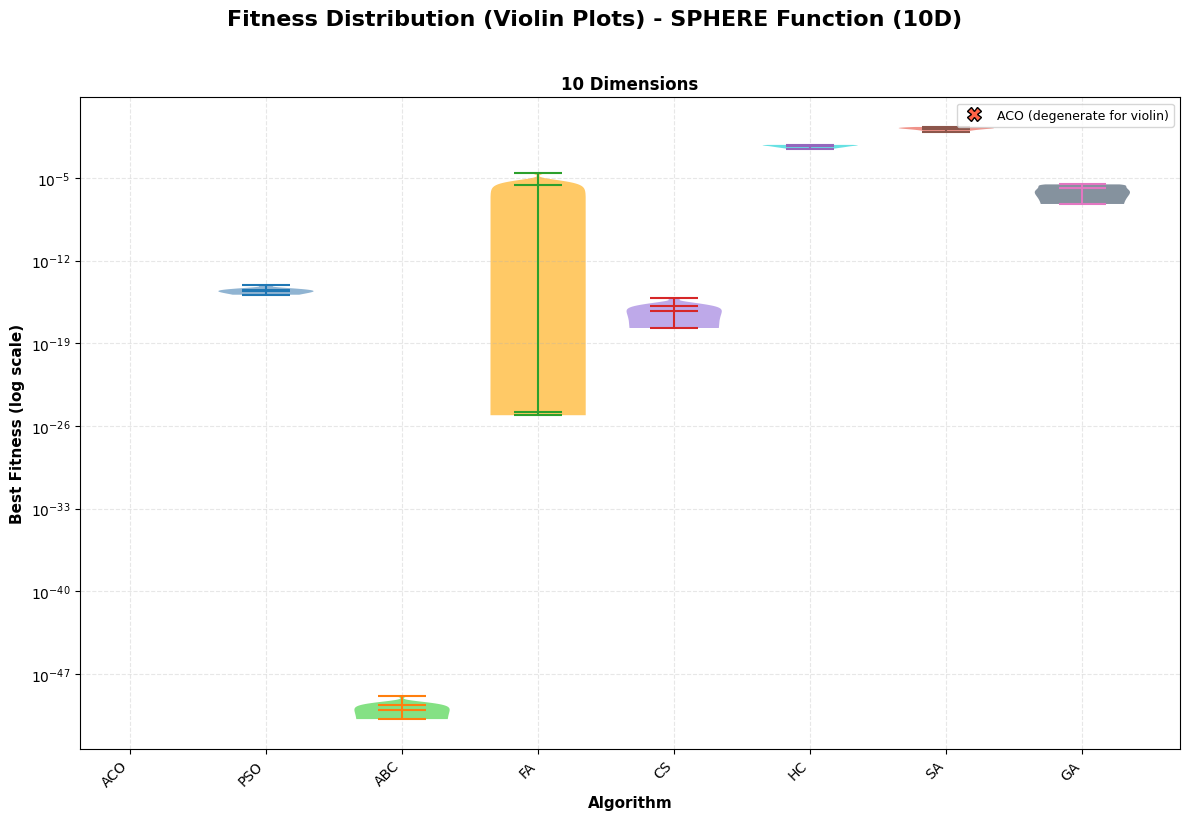

✓ Đã lưu: continuous_rastrigin_violin_10D.png


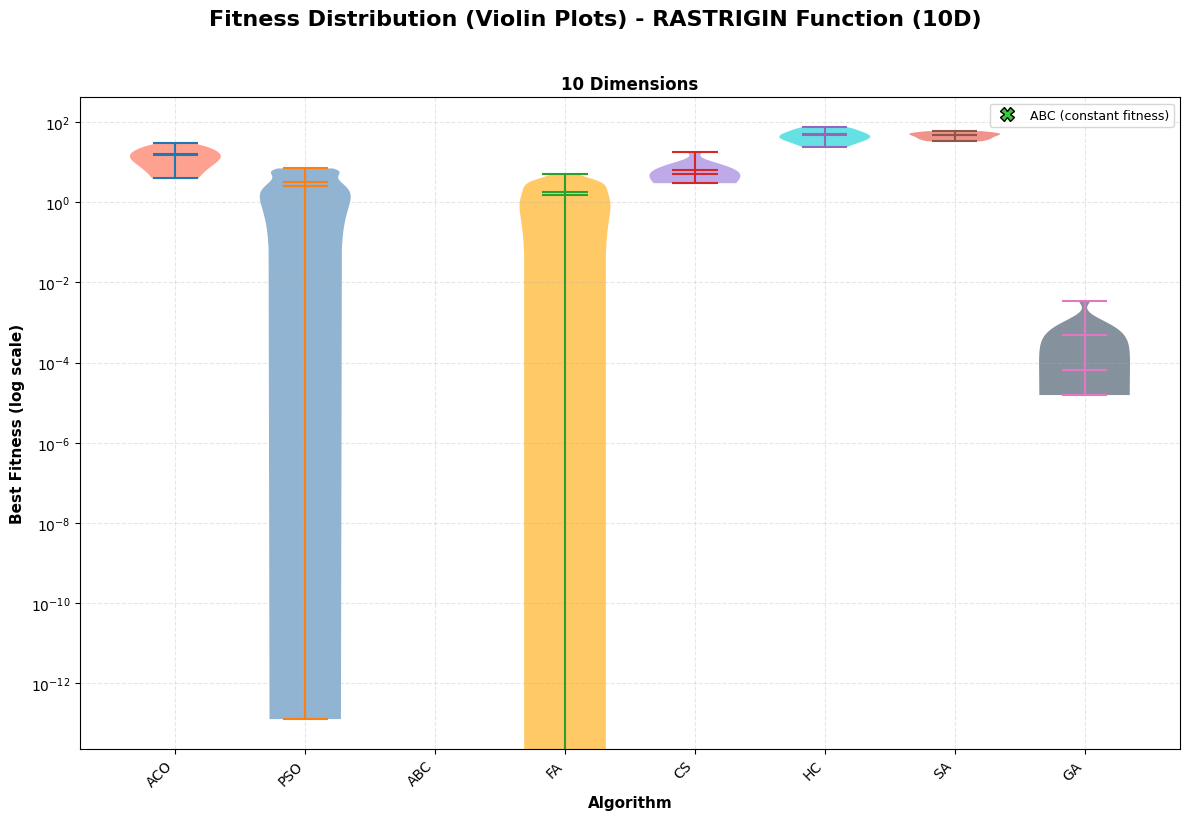

✓ Đã lưu: continuous_rosenbrock_violin_10D.png


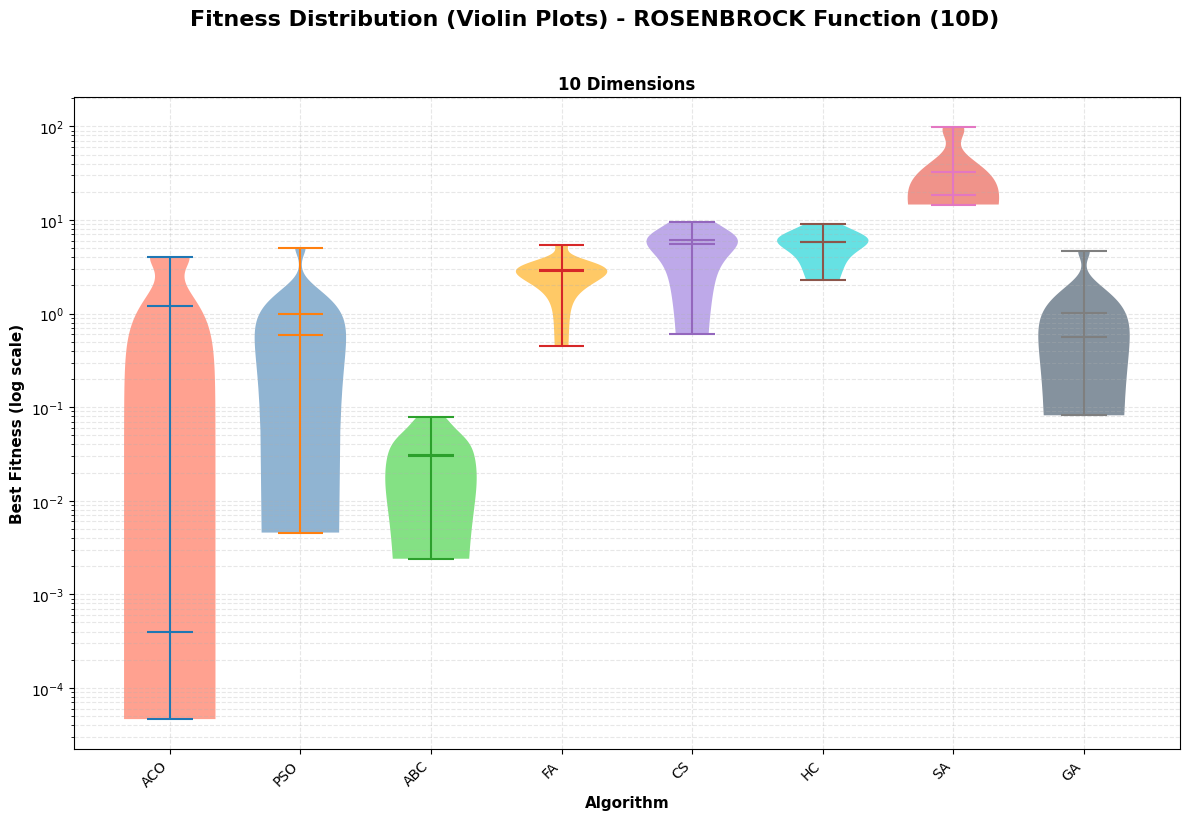

✓ Đã lưu: continuous_ackley_violin_10D.png


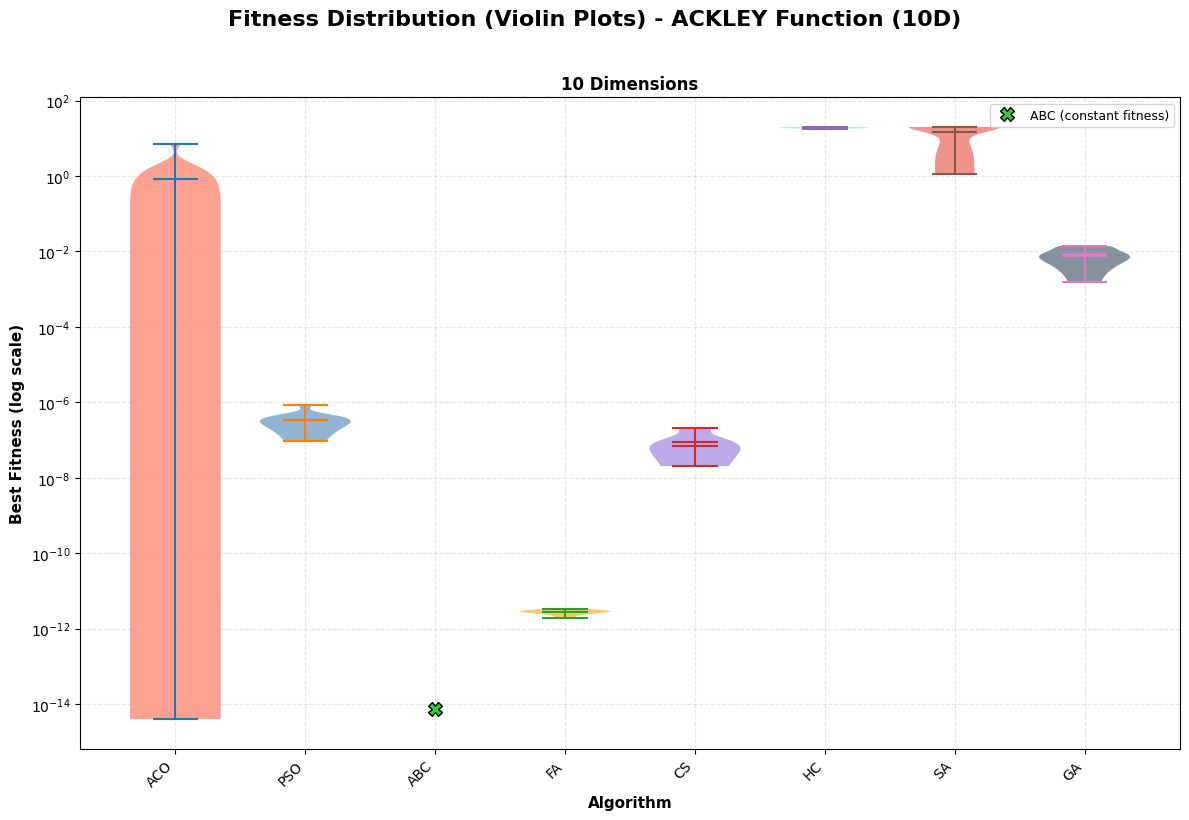

In [ ]:
# =============================================================================
# 6. VIOLIN PLOTS - DISTRIBUTION COMPARISON
# =============================================================================
for problem_name in CONTINUOUS_PROBLEMS:
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    fig.suptitle(f'Fitness Distribution (Violin Plots) - {problem_name.upper()} Function (10D)',
                 fontsize=16, fontweight='bold', y=1.02)

    single_point_data_for_plotting = []
    all_alg_data = []
    for i, algorithm_name in enumerate(CONTINUOUS_ALGORITHMS):
        results_list = continuous_results[problem_name][10].get(algorithm_name, [])
        if results_list:
            best_fitnesses = [r['best_fitness'] for r in results_list]
            all_alg_data.append({
                'data': best_fitnesses,
                'position': i,
                'color': colors_cont[algorithm_name],
                'name': algorithm_name
            })

    for alg_info in all_alg_data:
        # Đầu tiên, kiểm tra xem dữ liệu có phải là hằng số không . Ví dụ khi chạy một thuật toán n lần, và cả n lần nó đều trả về chính xác cùng một kết quả thì không thể plot được vì nó chỉ là một điểm
        # np.unique trả về các giá trị duy nhất. Nếu <= 1, tức là mọi lần chạy đều ra cùng 1 kết quả.
        if len(np.unique(alg_info['data'])) <= 1:
            mean_val = np.mean(alg_info['data'])
            single_point_data_for_plotting.append((alg_info['position'], mean_val, alg_info['color'],
                                                 f'{alg_info["name"]} (constant fitness)'))
        else:
            # Nếu nó thất bại do LinAlgError (phương sai quá thấp), ta cũng vẽ nó như một điểm duy nhất
            try:
                parts = ax.violinplot(alg_info['data'], positions=[alg_info['position']],
                                     showmeans=True, showmedians=True, widths=0.7)
                for pc in parts['bodies']:
                    pc.set_facecolor(alg_info['color'])
                    pc.set_alpha(0.6)
            except np.linalg.LinAlgError:
                # Nếu gặp lỗi (thường do phương sai gần bằng 0)
                mean_val = np.mean(alg_info['data'])
                single_point_data_for_plotting.append((alg_info['position'], mean_val, alg_info['color'],
                                                     f'{alg_info["name"]} (degenerate for violin)'))

    # Plot all single points collected (either initially constant or fallback from violin)
    added_to_legend = set()
    for pos, mean_val, color, label_text in single_point_data_for_plotting:
        if label_text not in added_to_legend:
            ax.plot(pos, mean_val, marker='X', markersize=10, linestyle='None',
                    color=color, markeredgecolor='black', label=label_text)
            added_to_legend.add(label_text)
        else:
            ax.plot(pos, mean_val, marker='X', markersize=10, linestyle='None',
                    color=color, markeredgecolor='black')



    ax.set_xticks(range(len(CONTINUOUS_ALGORITHMS)))
    ax.set_xticklabels(CONTINUOUS_ALGORITHMS, rotation=45, ha='right')

    ax.set_xlabel('Algorithm', fontsize=11, fontweight='bold')
    ax.set_ylabel('Best Fitness (log scale)', fontsize=11, fontweight='bold')
    ax.set_title('10 Dimensions', fontsize=12, fontweight='bold')
    ax.grid(True, which='both', alpha=0.3, linestyle='--')
    ax.set_yscale('log')


    if single_point_data_for_plotting:
        ax.legend(loc='upper right', fontsize=9)

    plt.tight_layout()
    plt.savefig(f'continuous_{problem_name}_violin_10D.png', dpi=300, bbox_inches='tight')
    print(f"✓ Đã lưu: continuous_{problem_name}_violin_10D.png")
    plt.show()


VẼ BIỂU ĐỒ 3D SURFACE (CẢI TIẾN)


Vẽ biểu đồ cho SPHERE...
Algorithm (seed=42) finished in 0.0212 seconds.
Best fitness: 2.831747091706929e-15
  ✓ PSO: Best = 2.8317e-15 at (0.000, -0.000)
Algorithm (seed=42) finished in 0.0952 seconds.
Best fitness: 1.079931976960398e-06
  ✓ GA: Best = 1.0799e-06 at (-0.001, -0.000)
Algorithm (seed=42) finished in 0.8922 seconds.
Best fitness: 0.0004285165226620094
  ✓ FA: Best = 4.2852e-04 at (-0.016, -0.013)
Algorithm (seed=42) finished in 0.0137 seconds.
Best fitness: 6.605094370147066e-06
  ✓ SA: Best = 6.6051e-06 at (-0.002, 0.002)
✓ Đã lưu: 3d_surface_sphere_improved.png



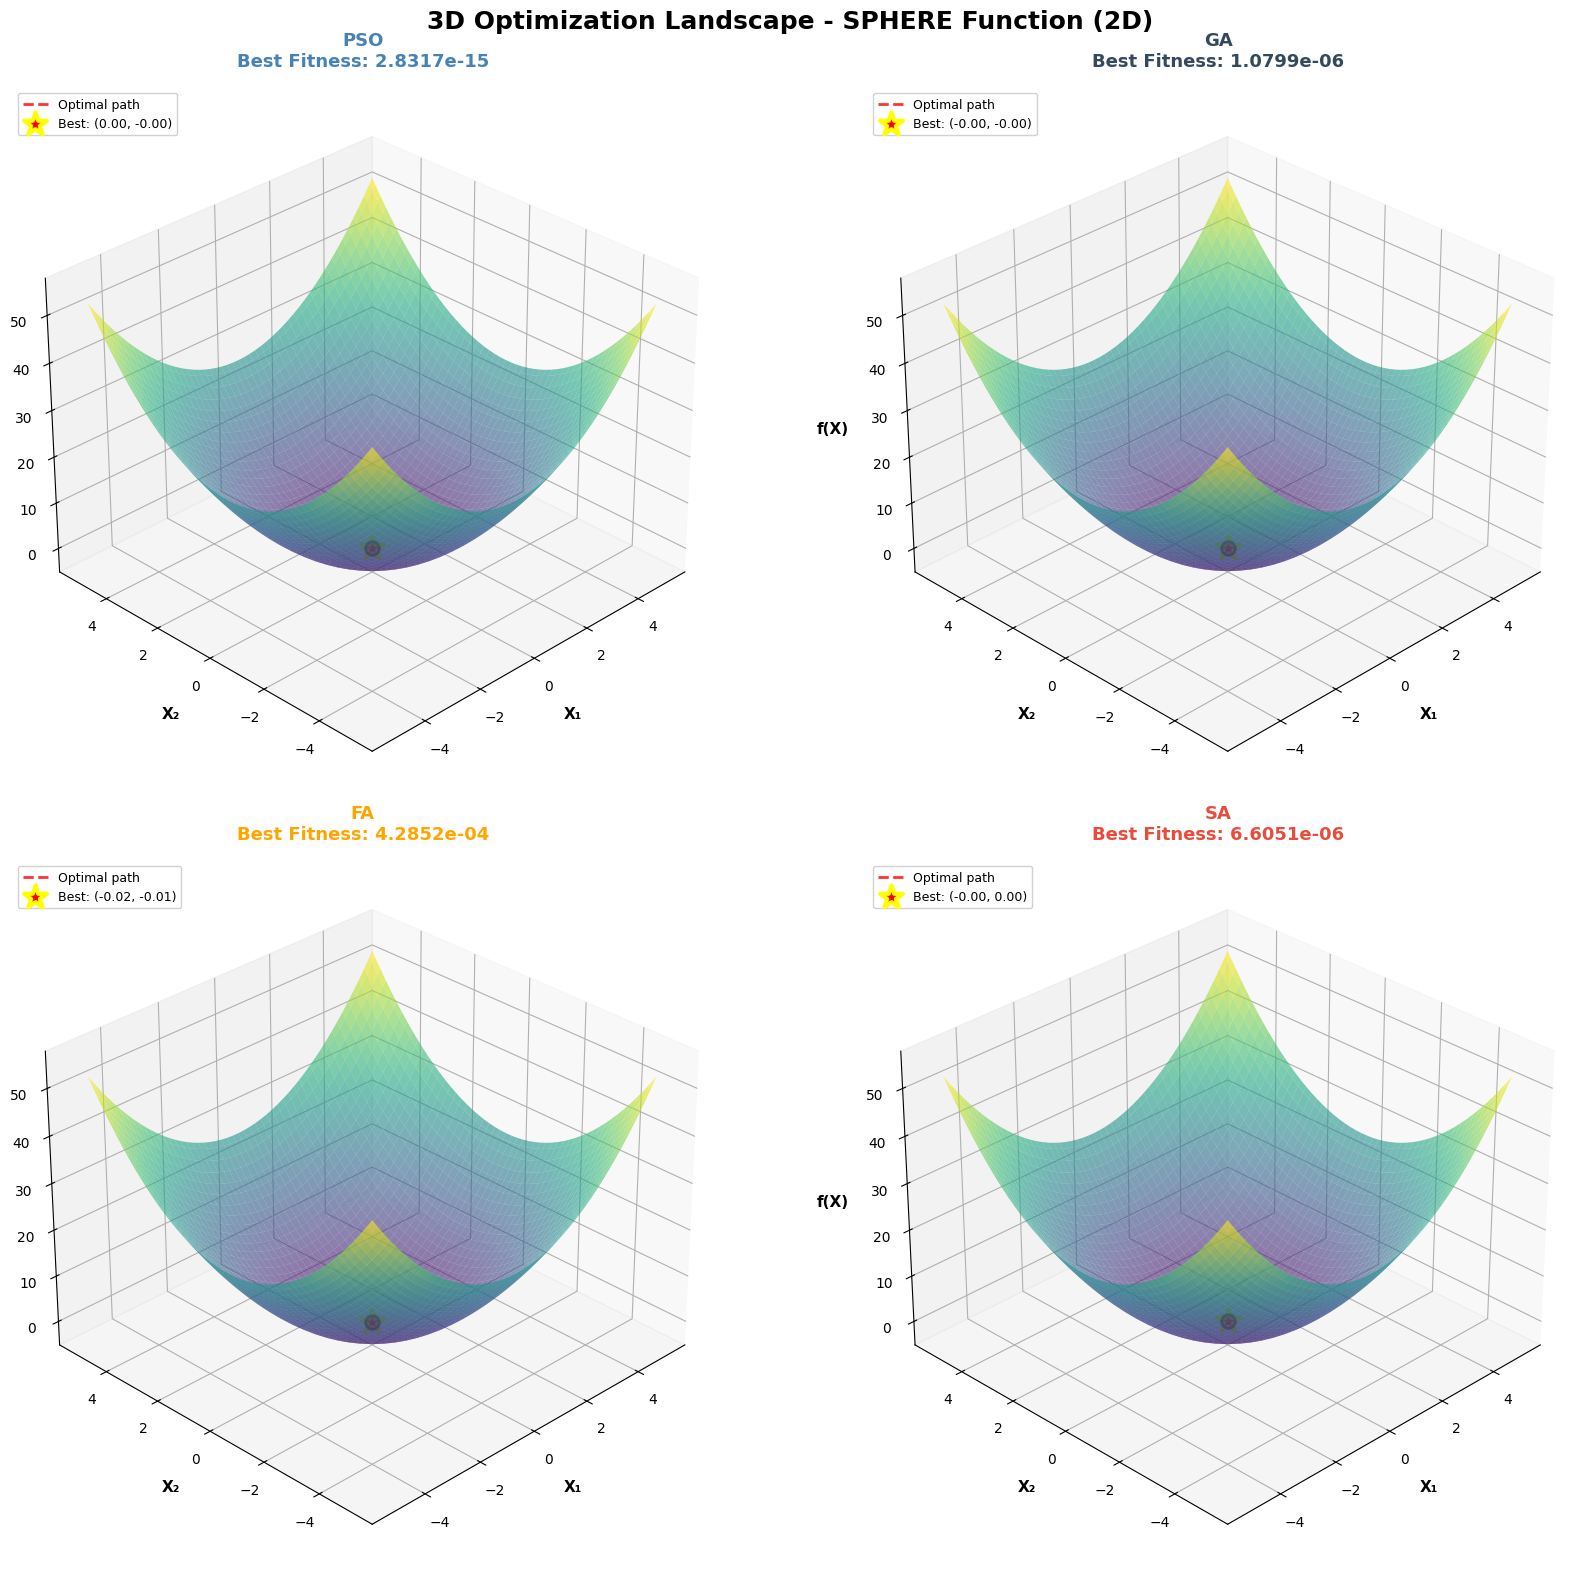


Vẽ biểu đồ cho RASTRIGIN...
Algorithm (seed=42) finished in 0.0427 seconds.
Best fitness: 4.479971948967432e-12
  ✓ PSO: Best = 4.4800e-12 at (-0.000, -0.000)
Algorithm (seed=42) finished in 0.1212 seconds.
Best fitness: 0.0008880108283761956
  ✓ GA: Best = 8.8801e-04 at (0.002, 0.000)
Algorithm (seed=42) finished in 1.2901 seconds.
Best fitness: 0.0028757284287408424
  ✓ FA: Best = 2.8757e-03 at (-0.003, -0.002)
Algorithm (seed=42) finished in 0.0188 seconds.
Best fitness: 9.954578775146055
  ✓ SA: Best = 9.9546e+00 at (2.981, -0.991)
✓ Đã lưu: 3d_surface_rastrigin_improved.png



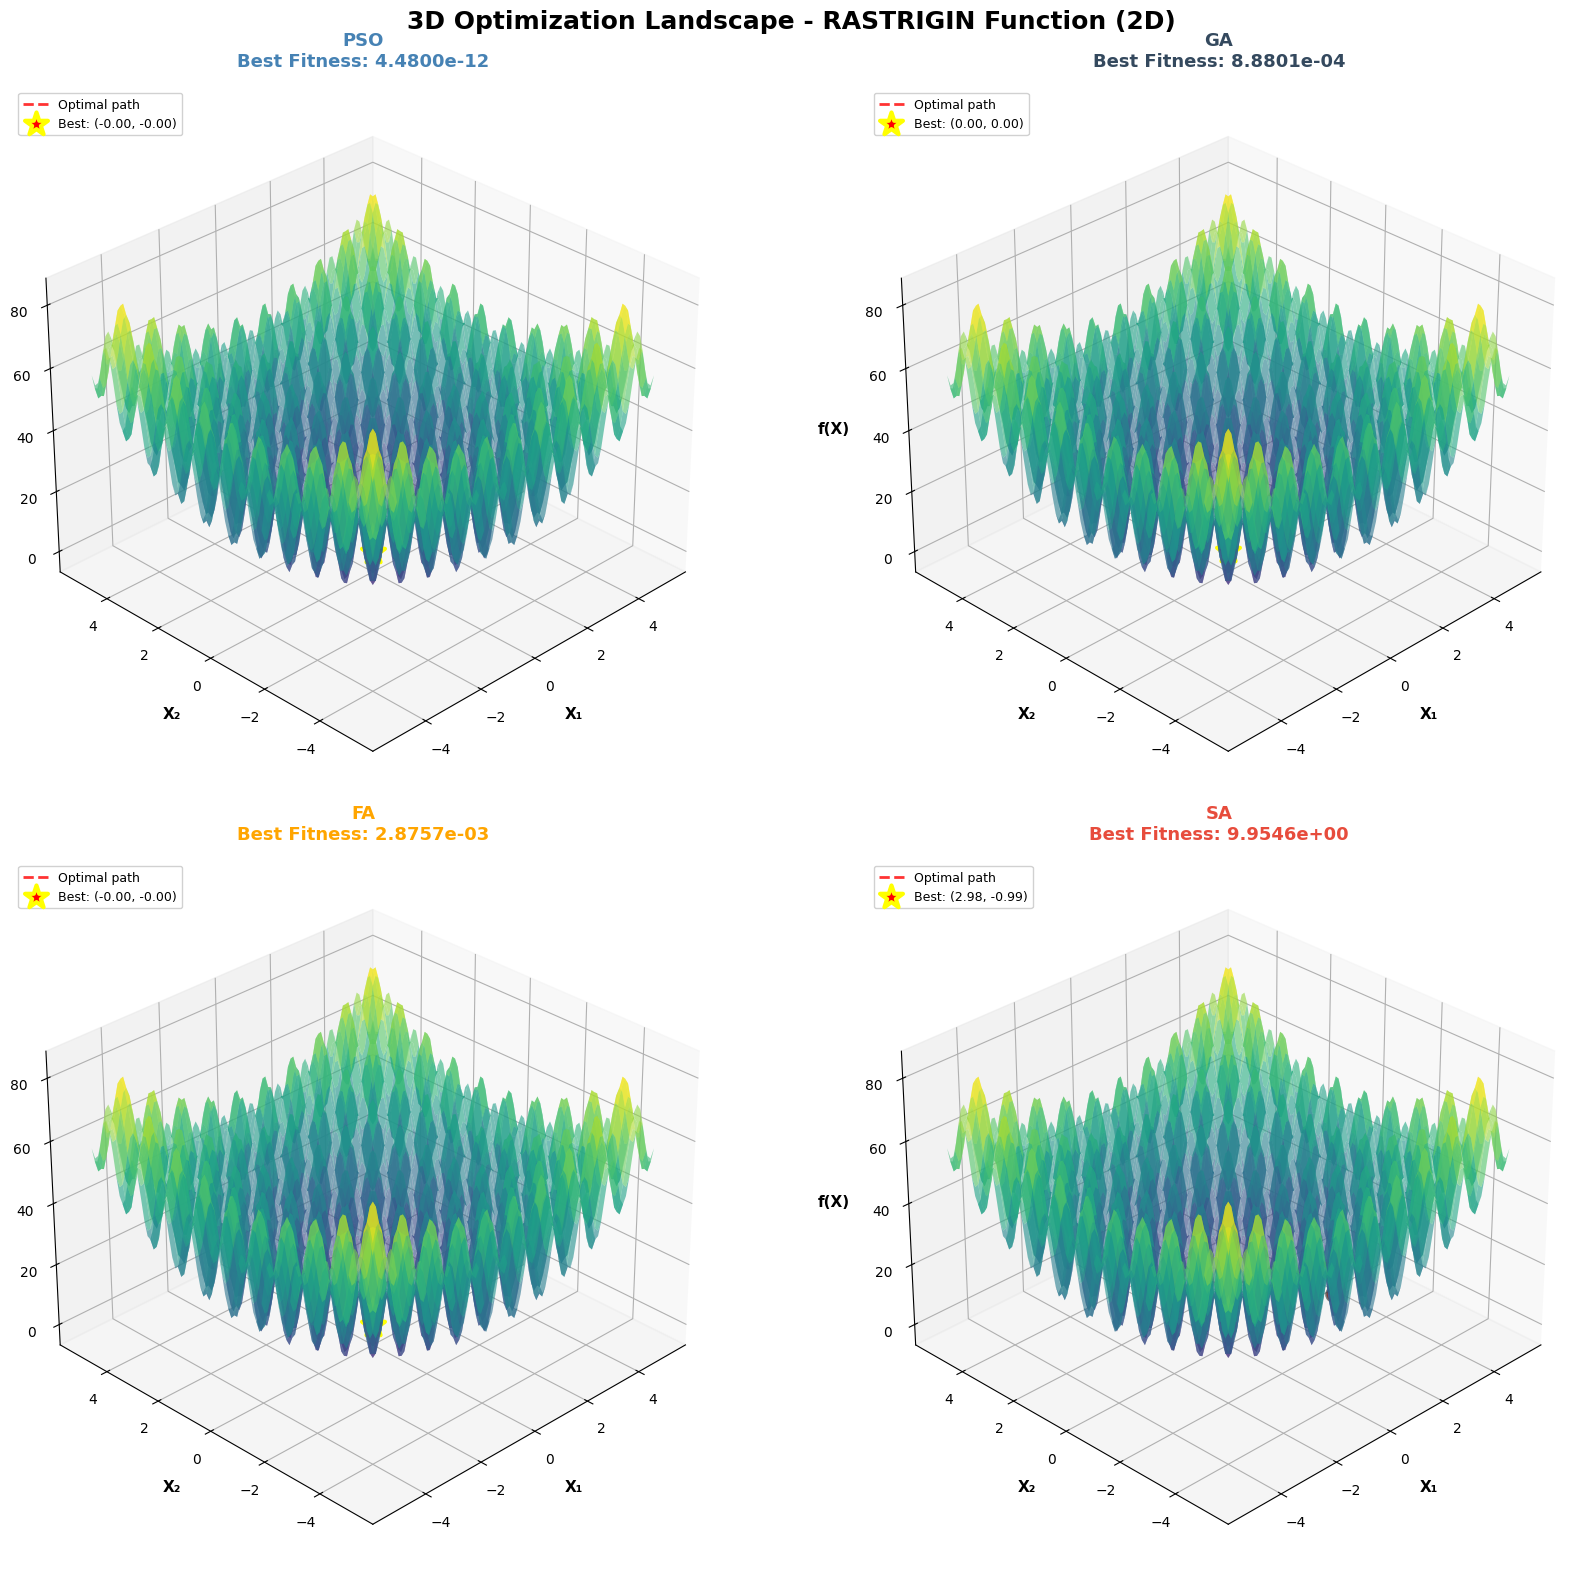


VẼ CONTOUR MAPS 2D VỚI TRAJECTORY


Vẽ contour map cho SPHERE...
Algorithm (seed=42) finished in 0.0198 seconds.
Best fitness: 2.831747091706929e-15
  ✓ PSO: Best = 2.8317e-15 at (0.000, -0.000)
Algorithm (seed=42) finished in 0.1286 seconds.
Best fitness: 1.079931976960398e-06
  ✓ GA: Best = 1.0799e-06 at (-0.001, -0.000)
Algorithm (seed=42) finished in 0.9236 seconds.
Best fitness: 0.0004285165226620094
  ✓ FA: Best = 4.2852e-04 at (-0.016, -0.013)
Algorithm (seed=42) finished in 0.0157 seconds.
Best fitness: 6.605094370147066e-06
  ✓ SA: Best = 6.6051e-06 at (-0.002, 0.002)
✓ Đã lưu: contour_map_sphere.png



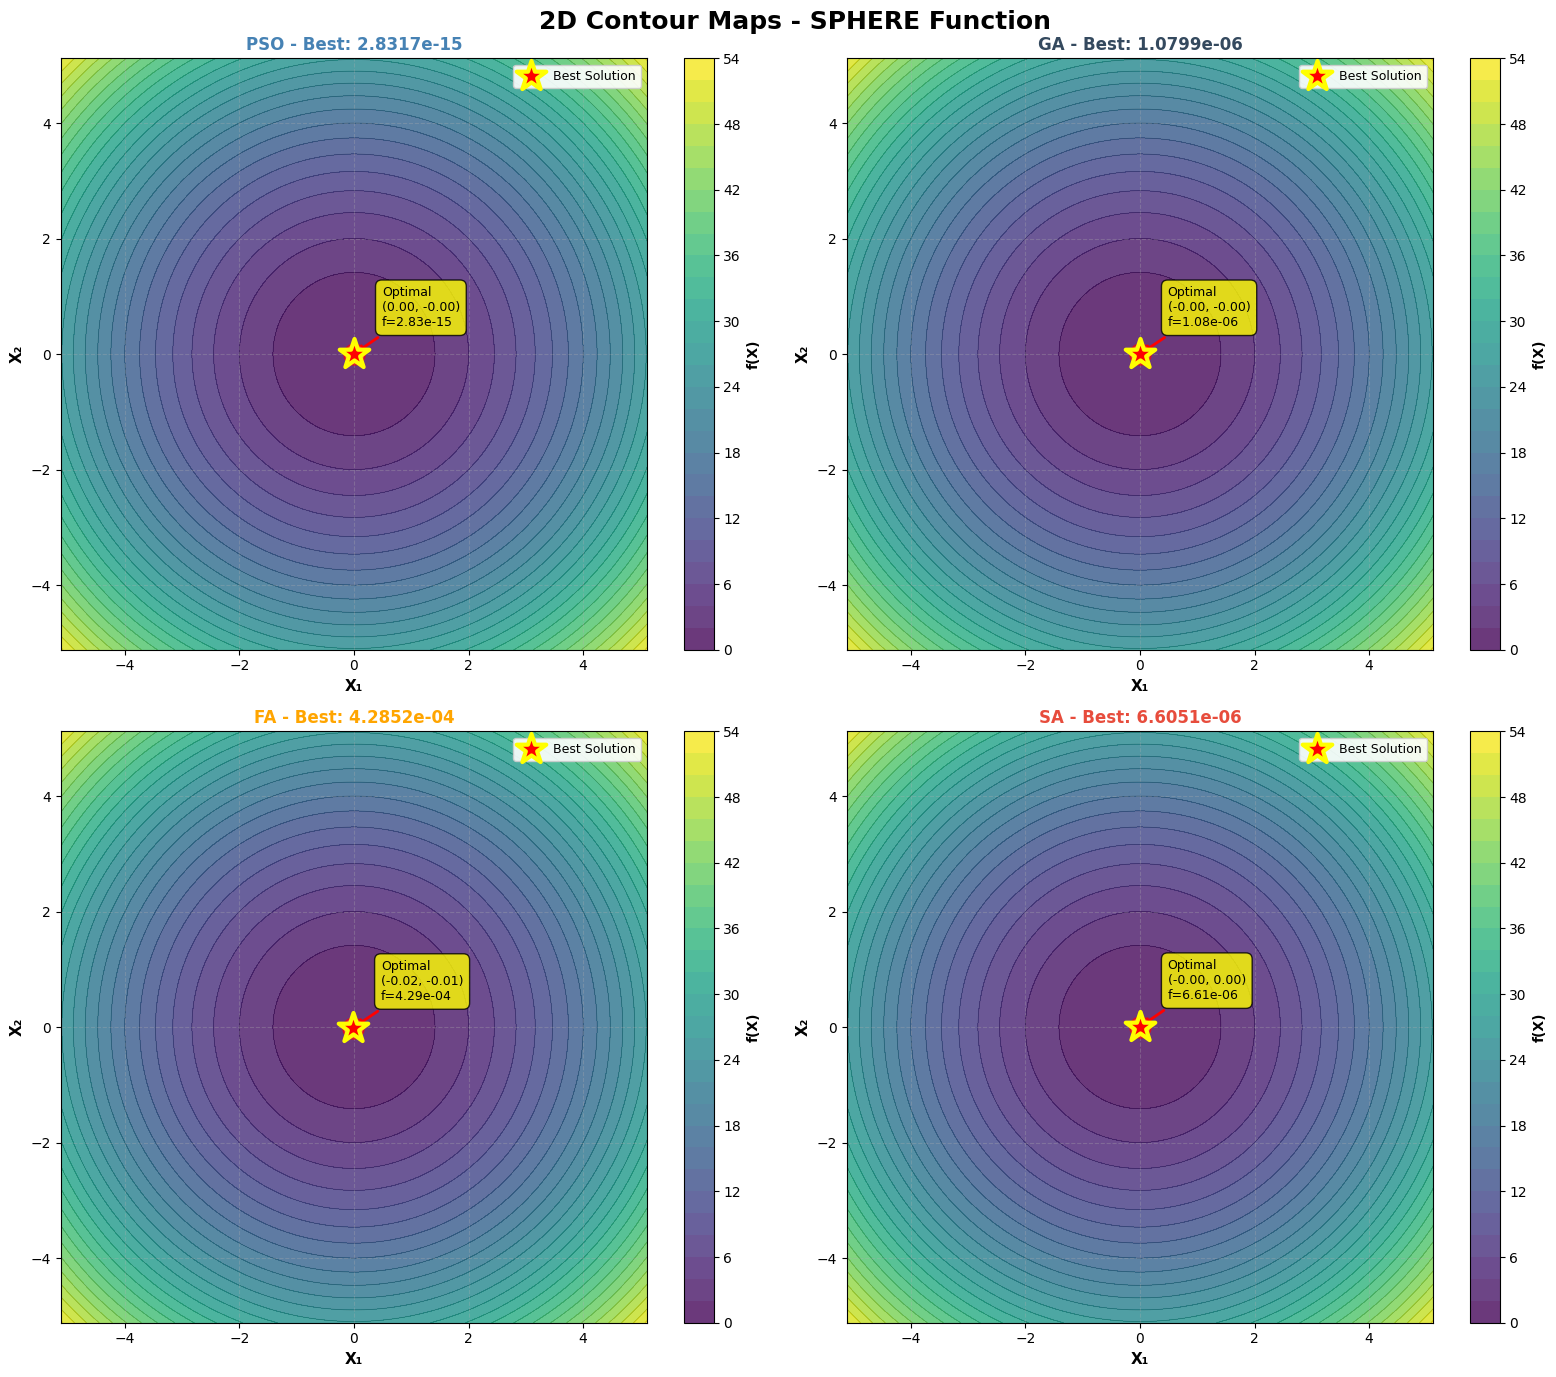


Vẽ contour map cho RASTRIGIN...
Algorithm (seed=42) finished in 0.0347 seconds.
Best fitness: 4.479971948967432e-12
  ✓ PSO: Best = 4.4800e-12 at (-0.000, -0.000)
Algorithm (seed=42) finished in 0.1439 seconds.
Best fitness: 0.0008880108283761956
  ✓ GA: Best = 8.8801e-04 at (0.002, 0.000)
Algorithm (seed=42) finished in 2.0782 seconds.
Best fitness: 0.0028757284287408424
  ✓ FA: Best = 2.8757e-03 at (-0.003, -0.002)
Algorithm (seed=42) finished in 0.0191 seconds.
Best fitness: 9.954578775146055
  ✓ SA: Best = 9.9546e+00 at (2.981, -0.991)
✓ Đã lưu: contour_map_rastrigin.png



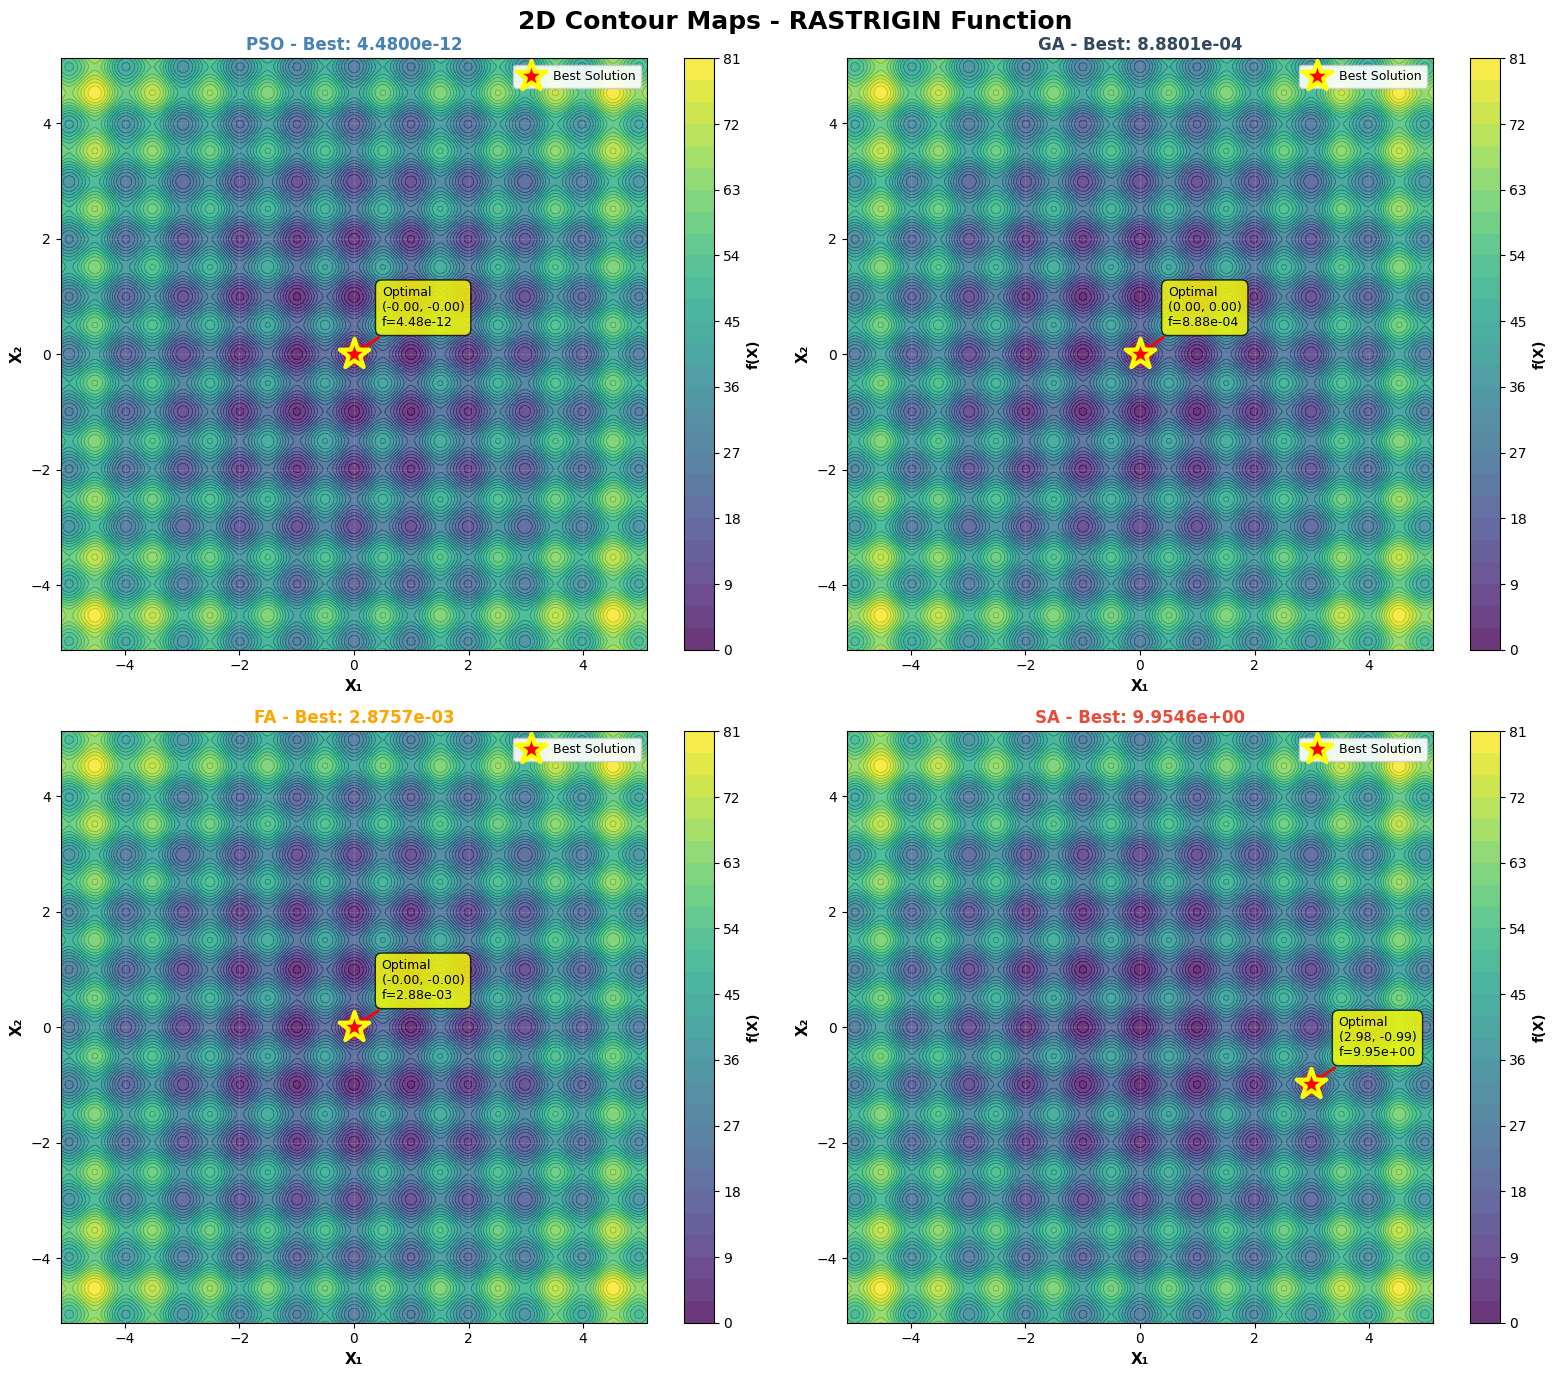


HOÀN THÀNH!



In [ ]:
# =============================================================================
# 7. 3D SURFACE PLOTS - IMPROVED VERSION WITH VISIBLE MARKERS
# =============================================================================

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

print("\n" + "="*80)
print("VẼ BIỂU ĐỒ 3D SURFACE (CẢI TIẾN)")
print("="*80 + "\n")

# Chọn bài toán và thuật toán
selected_problems = ['sphere', 'rastrigin']
selected_algorithms = ['PSO', 'GA', 'FA', 'SA']

for problem_name in selected_problems:
    print(f"\nVẽ biểu đồ cho {problem_name.upper()}...")

    fig, axes = plt.subplots(2, 2, figsize=(18, 16), subplot_kw={'projection': '3d'})
    fig.suptitle(f'3D Optimization Landscape - {problem_name.upper()} Function (2D)',
                 fontsize=18, fontweight='bold', y=0.98)
    axes = axes.flatten()

    for idx, algorithm_name in enumerate(selected_algorithms):
        ax = axes[idx]

        # Tạo bài toán 2D
        problem_2d = Problem(problem_name, n_dims=2, seed=SEED_BASE)

        # Lấy bounds
        bounds = np.array(problem_2d.search_space['bounds'])
        x_min, x_max = bounds[0, 0], bounds[0, 1]
        y_min, y_max = bounds[1, 0], bounds[1, 1]

        # Tạo mesh grid với độ phân giải cao hơn
        resolution = 100
        x = np.linspace(x_min, x_max, resolution)
        y = np.linspace(y_min, y_max, resolution)
        X, Y = np.meshgrid(x, y)

        # Tính giá trị hàm mục tiêu
        Z = np.zeros_like(X)
        for i in range(resolution):
            for j in range(resolution):
                Z[i, j] = problem_2d.objective_function(np.array([X[i, j], Y[i, j]]))

        # Chạy thuật toán
        if algorithm_name == 'PSO':
            optimizer = ParticleSwarmOptimizer(
                objective_function=problem_2d.objective_function,
                search_space=problem_2d.search_space,
                problem_type=problem_2d.problem_type,
                max_iterations=100,
                seed=SEED_BASE,
                population_size=30
            )
        elif algorithm_name == 'GA':
            optimizer = GeneticAlgorithmOptimizer(
                objective_function=problem_2d.objective_function,
                search_space=problem_2d.search_space,
                problem_type=problem_2d.problem_type,
                max_iterations=100,
                seed=SEED_BASE,
                population_size=30
            )
        elif algorithm_name == 'FA':
            optimizer = FireflyAlgorithmOptimizer(
                objective_function=problem_2d.objective_function,
                search_space=problem_2d.search_space,
                problem_type=problem_2d.problem_type,
                max_iterations=100,
                seed=SEED_BASE,
                population_size=30
            )
        elif algorithm_name == 'SA':
            optimizer = SimulatedAnnealingOptimizer(
                objective_function=problem_2d.objective_function,
                search_space=problem_2d.search_space,
                problem_type=problem_2d.problem_type,
                max_iterations=100,
                seed=SEED_BASE
            )

        results = optimizer.run()

        # Vẽ surface với transparency cao hơn
        surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.6,
                              linewidth=0, antialiased=True,
                              rstride=2, cstride=2)

        # Lấy thông tin best solution
        best_x, best_y = results['best_solution']
        best_z = results['best_fitness']

        # Vẽ đường thẳng từ đáy lên điểm optimal (để dễ nhìn)
        ax.plot([best_x, best_x], [best_y, best_y], [Z.min(), best_z],
                'r--', linewidth=2, alpha=0.8, label='Optimal path')

        # Đánh dấu điểm tối ưu với kích thước lớn hơn
        ax.scatter([best_x], [best_y], [best_z],
                  color='red', s=300, marker='*',
                  edgecolors='yellow', linewidths=3, zorder=10,
                  label=f'Best: ({best_x:.2f}, {best_y:.2f})')

        # Vẽ projection của điểm optimal lên mặt đáy
        ax.scatter([best_x], [best_y], [Z.min()],
                  color='red', s=100, marker='o',
                  edgecolors='black', linewidths=2, zorder=5, alpha=0.5)

        # Thiết lập labels với font lớn hơn
        ax.set_xlabel('X₁', fontsize=11, fontweight='bold', labelpad=10)
        ax.set_ylabel('X₂', fontsize=11, fontweight='bold', labelpad=10)
        ax.set_zlabel('f(X)', fontsize=11, fontweight='bold', labelpad=10)
        ax.set_title(f'{algorithm_name}\nBest Fitness: {best_z:.4e}',
                    fontsize=13, fontweight='bold', pad=15,
                    color=colors_cont[algorithm_name])

        # Thêm legend
        ax.legend(loc='upper left', fontsize=9, framealpha=0.9)

        # Điều chỉnh góc nhìn để thấy rõ hơn
        ax.view_init(elev=30, azim=225)

        # Thiết lập giới hạn trục z để thấy rõ điểm optimal
        z_range = Z.max() - Z.min()
        ax.set_zlim(Z.min() - 0.1*z_range, Z.max() + 0.1*z_range)

        print(f"  ✓ {algorithm_name}: Best = {best_z:.4e} at ({best_x:.3f}, {best_y:.3f})")

    plt.tight_layout()
    plt.savefig(f'3d_surface_{problem_name}_improved.png', dpi=300, bbox_inches='tight')
    print(f"✓ Đã lưu: 3d_surface_{problem_name}_improved.png\n")
    plt.show()

# =============================================================================
# THÊM: VẼ CONTOUR MAP 2D VỚI TRAJECTORY
# =============================================================================

print("\n" + "="*80)
print("VẼ CONTOUR MAPS 2D VỚI TRAJECTORY")
print("="*80 + "\n")

for problem_name in selected_problems:
    print(f"\nVẽ contour map cho {problem_name.upper()}...")

    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle(f'2D Contour Maps - {problem_name.upper()} Function',
                 fontsize=18, fontweight='bold', y=0.98)
    axes = axes.flatten()

    for idx, algorithm_name in enumerate(selected_algorithms):
        ax = axes[idx]

        # Tạo bài toán 2D
        problem_2d = Problem(problem_name, n_dims=2, seed=SEED_BASE)

        # Lấy bounds
        bounds = np.array(problem_2d.search_space['bounds'])
        x_min, x_max = bounds[0, 0], bounds[0, 1]
        y_min, y_max = bounds[1, 0], bounds[1, 1]

        # Tạo mesh grid
        resolution = 200
        x = np.linspace(x_min, x_max, resolution)
        y = np.linspace(y_min, y_max, resolution)
        X, Y = np.meshgrid(x, y)

        # Tính giá trị hàm mục tiêu
        Z = np.zeros_like(X)
        for i in range(resolution):
            for j in range(resolution):
                Z[i, j] = problem_2d.objective_function(np.array([X[i, j], Y[i, j]]))

        # Vẽ contour với nhiều levels
        levels = 30
        contour = ax.contourf(X, Y, Z, levels=levels, cmap='viridis', alpha=0.8)
        contour_lines = ax.contour(X, Y, Z, levels=levels, colors='black',
                                   alpha=0.2, linewidths=0.5)

        # Chạy thuật toán
        if algorithm_name == 'PSO':
            optimizer = ParticleSwarmOptimizer(
                objective_function=problem_2d.objective_function,
                search_space=problem_2d.search_space,
                problem_type=problem_2d.problem_type,
                max_iterations=100,
                seed=SEED_BASE,
                population_size=30
            )
        elif algorithm_name == 'GA':
            optimizer = GeneticAlgorithmOptimizer(
                objective_function=problem_2d.objective_function,
                search_space=problem_2d.search_space,
                problem_type=problem_2d.problem_type,
                max_iterations=100,
                seed=SEED_BASE,
                population_size=30
            )
        elif algorithm_name == 'FA':
            optimizer = FireflyAlgorithmOptimizer(
                objective_function=problem_2d.objective_function,
                search_space=problem_2d.search_space,
                problem_type=problem_2d.problem_type,
                max_iterations=100,
                seed=SEED_BASE,
                population_size=30
            )
        elif algorithm_name == 'SA':
            optimizer = SimulatedAnnealingOptimizer(
                objective_function=problem_2d.objective_function,
                search_space=problem_2d.search_space,
                problem_type=problem_2d.problem_type,
                max_iterations=100,
                seed=SEED_BASE
            )

        results = optimizer.run()

        # Đánh dấu best solution
        best_x, best_y = results['best_solution']
        best_z = results['best_fitness']

        # Vẽ điểm optimal với nhiều layer để nổi bật
        ax.scatter([best_x], [best_y], s=500, c='red', marker='*',
                  edgecolors='yellow', linewidths=3, zorder=10,
                  label=f'Best Solution')
        ax.scatter([best_x], [best_y], s=200, c='white', marker='o',
                  edgecolors='red', linewidths=2, zorder=9, alpha=0.7)

        # Thêm text annotation
        ax.annotate(f'Optimal\n({best_x:.2f}, {best_y:.2f})\nf={best_z:.2e}',
                   xy=(best_x, best_y), xytext=(20, 20),
                   textcoords='offset points', fontsize=9,
                   bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.8),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0',
                                 color='red', lw=2))

        # Thiết lập labels
        ax.set_xlabel('X₁', fontsize=11, fontweight='bold')
        ax.set_ylabel('X₂', fontsize=11, fontweight='bold')
        ax.set_title(f'{algorithm_name} - Best: {best_z:.4e}',
                    fontsize=12, fontweight='bold',
                    color=colors_cont[algorithm_name])

        # Thêm colorbar
        cbar = plt.colorbar(contour, ax=ax)
        cbar.set_label('f(X)', fontsize=10, fontweight='bold')

        ax.legend(loc='upper right', fontsize=9, framealpha=0.9)
        ax.grid(True, alpha=0.3, linestyle='--')

        print(f"  ✓ {algorithm_name}: Best = {best_z:.4e} at ({best_x:.3f}, {best_y:.3f})")

    plt.tight_layout()
    plt.savefig(f'contour_map_{problem_name}.png', dpi=300, bbox_inches='tight')
    print(f"✓ Đã lưu: contour_map_{problem_name}.png\n")
    plt.show()

print("\n" + "="*80)
print("HOÀN THÀNH!")
print("="*80 + "\n")

# Thử nghiệm với TSPLIB

In [ ]:
# =============================================================================
# CẤU HÌNH THỬ NGHIỆM
# =============================================================================

CITY_SIZES = [20, 30]
N_RUNS = 10
MAX_ITERATIONS = 1000
SEED_BASE = 42
ALL_ALGORITHMS = ['ACO', 'PSO', 'ABC', 'FA', 'CS', 'HC', 'SA', 'GA']
# Palette màu cho các thuật toán
colors = {
    'ACO': '#FF6347',  # Tomato
    'PSO': '#4682B4',  # SteelBlue
    'ABC': '#32CD32',  # LimeGreen
    'FA': '#FFA500',   # Orange
    'CS': '#9370DB',   # MediumPurple
    'HC': '#00CED1',   # DarkTurquoise
    'SA': '#DAA520',   # GoldenRod
    'GA': '#6A5ACD'    # SlateBlue
}

# =============================================================================
# HÀM CHẠY THỬ NGHIỆM
# =============================================================================

def run_experiment(problem, algorithm_name, seed):
    """Chạy một thử nghiệm với thuật toán và bài toán cụ thể."""

    if algorithm_name == 'ACO':
        optimizer = AntColonyOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            population_size=25,
            alpha=1.0,
            beta=2.0,
            rho=0.5,
            q=100,
            elitism_weight=1.0,
            local_rho=0.1,
            use_mmas=True
        )

    elif algorithm_name == 'PSO':
        optimizer = ParticleSwarmOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            population_size=50,
            w_max=0.9,
            w_min=0.4,
            c1_start=2.5,
            c1_end=0.5,
            c2_start=0.5,
            c2_end=2.5,
            v_clamp_factor=0.7,
            stagnation_threshold=1e-5,
            reinit_fraction=0.2
        )

    elif algorithm_name == 'ABC':
        optimizer = ArtificialBeeColonyOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            population_size=50,
            limit=200
        )

    elif algorithm_name == 'FA':
        optimizer = FireflyAlgorithmOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            population_size=50,
            alpha=0.5,
            beta_0=1.0,
            gamma=0.01,
            k_best=15,
            alpha_damp=0.99
        )

    elif algorithm_name == 'CS':
        optimizer = CuckooSearchOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            population_size=50,
            p_a=0.25,
            alpha=1.0,
            beta=1.5,
            step_size_min=1,
            step_size_max=4
        )

    elif algorithm_name == 'HC':
        optimizer = HillClimbingOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            n_neighbors=20,
            step_size=0.1,
            use_restarts=True,
            stagnation_limit=50
        )

    elif algorithm_name == 'SA':
        optimizer = SimulatedAnnealingOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            initial_temp=1000.0,
            cooling_rate=0.95,
            min_temp=1e-5,
            step_size=0.1,
            cooling_schedule='fast',
            use_reheating=True,
            stagnation_limit=100,
            reheat_fraction=0.2,
            n_neighbors=10,
            neighbor_selection='best'
        )

    elif algorithm_name == 'GA':
        optimizer = GeneticAlgorithmOptimizer(
            objective_function=problem.objective_function,
            search_space=problem.search_space,
            problem_type=problem.problem_type,
            max_iterations=MAX_ITERATIONS,
            seed=seed,
            population_size=50,
            crossover_rate=0.8,
            mutation_rate=0.1,
            tournament_size_ratio=0.1,
            elitism_size=2
        )

    else:
        raise ValueError(f"Unknown algorithm: {algorithm_name}")

    results = optimizer.run()
    return results

In [ ]:
# =============================================================================
# DỮ LIỆU THỬ NGHIỆM
# =============================================================================

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "tsp_instances_dataset.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ziya07/traveling-salesman-problem-tsplib-dataset",
  file_path,
)

df50 = df[df["Num_Cities"] < 50]
display(df50[["TSP_Instance", "Num_Cities", "Total_Distance"]])

Using Colab cache for faster access to the 'traveling-salesman-problem-tsplib-dataset' dataset.


TSP_Instance  Num_Cities  Total_Distance
2        att532          29    42912.230787
3        bays29          41    91110.868434
5      brd14051          32    53962.779275
18        dl655          27    38498.507251
22        11400          34    57212.624239
28       brg180          36    65457.610223
32         d493          41    86247.737812
35       fl1577          38    73315.723699
36      fn14461          37    70070.458085
39        gr202          40    86786.658208
43         gr96          23    29463.325451
47      kroD100          20    17782.529783
49       nm1379          34    59018.534053
57      kroB150          49   108911.967378
61         p654          27    36815.034984
63      pcb3038          33    51328.063537
64     pla33810          34    55020.720157
65       pr1002          23    24827.334908
67        pr226          20    20451.017091
68        pr264          49   119564.893926
69         pr76          20    19095.479611
70       rat575          26    35083.652392
73       r11889          29    44292.386806
77        pr299          23    23501.747234
83         st70          47   118176.908334
84      pcb1173          36    61345.818388
90        pr439          23    27350.585512
91       rat195          25    31742.333092
94       r11323          40    81108.392071
98        ts225          46   106390.730667

In [ ]:
instances = ["att532", "bays29"]
selected = df50[df50["TSP_Instance"].isin(instances)]
CITY_SIZES = [n_cities for n_cities in selected["Num_Cities"]]
display(selected)

TSP_Instance  Num_Cities  Total_Distance  Best_Route_Category   City_1_X  \
2       att532          29    42912.230787                    2  50.557900   
3       bays29          41    91110.868434                    1  40.696244   

    City_1_Y  City_2_X   City_2_Y   City_3_X   City_3_Y  ...  City_145_X  \
2  36.820223  4.461329  88.336531  48.414394  67.342078  ...         NaN   
3  20.967084  0.115264  44.528743  82.114850  81.130896  ...         NaN   

   City_145_Y  City_146_X  City_146_Y  City_147_X  City_147_Y  City_148_X  \
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   

   City_148_Y  City_149_X  City_149_Y  
2         NaN         NaN         NaN  
3         NaN         NaN         NaN  

[2 rows x 302 columns]

In [ ]:
print("=" * 80)
print("BẮT ĐẦU THỬ NGHIỆM CÁC THUẬT TOÁN VỚI BÀI TOÁN TSP")
print("=" * 80)

seed=42
all_results = {}

for instance in instances:
    selected = df50[df50["TSP_Instance"] == instance]
    cities_coords = np.zeros((int(selected["Num_Cities"]), 2))
    for i in range(len(instance)):
        for j in range(int(selected["Num_Cities"])):
            cities_coords[j, 0] = selected[f"City_{j + 1}_X"]
            cities_coords[j, 1] = selected[f"City_{j + 1}_Y"]

    n_cities = len(cities_coords)
    print(f"\n{'='*80}")
    print(f"CITIES: {n_cities}")
    print(f"{'='*80}")

    algorithms_to_run = ALL_ALGORITHMS
    print(f"Chạy TẤT CẢ {len(algorithms_to_run)} thuật toán")

    all_results[n_cities] = {}
    problem = ProblemDS('tsp', n_dims=n_cities, seed=seed, dataset=cities_coords)

    for algorithm_name in algorithms_to_run:
        print(f"\n{'-'*80}")
        print(f"Thuật toán: {algorithm_name}")
        print(f"{'-'*80}")

        algorithm_results = []

        # Corrected N_RUNS to 10 for proper statistical analysis
        for run_idx in range(10):
            current_seed = SEED_BASE + run_idx
            print(f"  Run {run_idx + 1}/10 (seed={current_seed})...", end=" ")

            try:
                results = run_experiment(problem, algorithm_name, current_seed)
                algorithm_results.append(results)
                print(f"✓ Best: {results['best_fitness']:.2f}, Time: {results['execution_time']:.3f}s")
            except Exception as e:
                print(f"✗ Error: {str(e)}")
                continue

        all_results[n_cities][algorithm_name] = algorithm_results

        # Thống kê tóm tắt
        if algorithm_results:
            best_fitnesses = [r['best_fitness'] for r in algorithm_results]
            exec_times = [r['execution_time'] for r in algorithm_results]
            print(f"\n  Tóm tắt {algorithm_name}:")
            print(f"    Best fitness - Min: {np.min(best_fitnesses):.2f}, "
                    f"Mean: {np.mean(best_fitnesses):.2f}, "
                    f"Max: {np.max(best_fitnesses):.2f}, "
                    f"Std: {np.std(best_fitnesses):.2f}")
            print(f"    Execution time - Mean: {np.mean(exec_times):.3f}s, "
                    f"Std: {np.std(exec_times):.3f}s")

print(f"\n{'='*80}")
print("HOÀN THÀNH TẤT CẢ CÁC THỬ NGHIỆM!")
print(f"{'='*80}\n")

BẮT ĐẦU THỬ NGHIỆM CÁC THUẬT TOÁN VỚI BÀI TOÁN TSP

CITIES: 29
Chạy TẤT CẢ 8 thuật toán

--------------------------------------------------------------------------------
Thuật toán: ACO
--------------------------------------------------------------------------------
  Run 1/10 (seed=42)... Algorithm (seed=42) finished in 35.7192 seconds.
Best fitness: 501.055653880996
✓ Best: 501.06, Time: 35.719s
  Run 2/10 (seed=43)... Algorithm (seed=43) finished in 35.6568 seconds.
Best fitness: 503.2922374192057
✓ Best: 503.29, Time: 35.657s
  Run 3/10 (seed=44)... Algorithm (seed=44) finished in 35.4270 seconds.
Best fitness: 482.47443797368004
✓ Best: 482.47, Time: 35.427s
  Run 4/10 (seed=45)... Algorithm (seed=45) finished in 35.2673 seconds.
Best fitness: 482.47443797368004
✓ Best: 482.47, Time: 35.267s
  Run 5/10 (seed=46)... Algorithm (seed=46) finished in 35.3658 seconds.
Best fitness: 482.47443797368004
✓ Best: 482.47, Time: 35.366s
  Run 6/10 (seed=47)... Algorithm (seed=47) finished in 

In [ ]:
all_results.keys()

dict_keys([29, 41])

✓ Đã lưu: tsp_convergence_curves_detailed.png


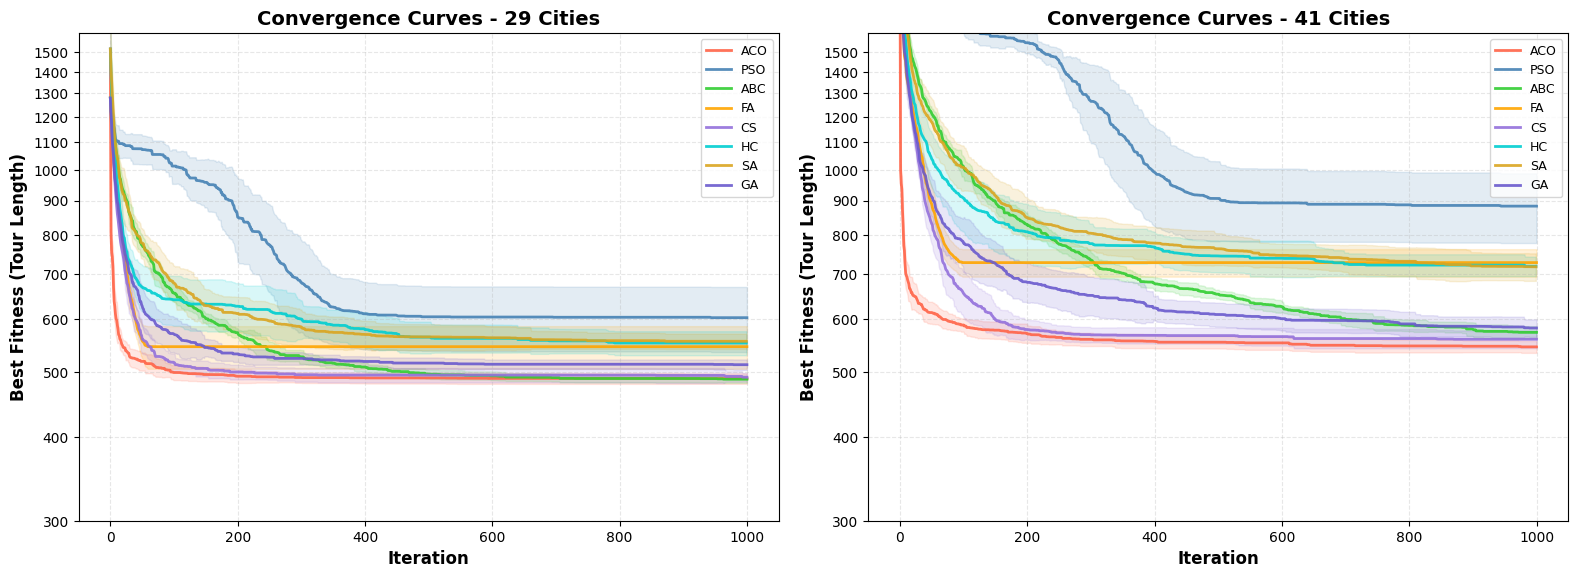

In [ ]:
#======================================================================
# 1. BIỂU ĐỒ CONVERGENCE CURVES (Đường hội tụ)
#======================================================================

cities_to_plot = sorted(list(all_results.keys()))
num_plots = len(cities_to_plot)

fig, axes = plt.subplots(1, num_plots, figsize=(8 * num_plots, 6))

# Ensure axes is an array even for a single plot
if num_plots == 1:
    axes = [axes]

for idx, n_cities in enumerate(cities_to_plot):
    ax = axes[idx]

    # Tìm y_min và y_max thực tế để đặt giới hạn trục
    min_val_overall = float('inf')
    max_val_overall = float('-inf')

    for algorithm_name, results_list in all_results[n_cities].items():
        if results_list:
            histories = [r['convergence_history'] for r in results_list]
            if not histories: continue

            mean_history = np.mean(histories, axis=0)
            std_history = np.std(histories, axis=0)

            # Cập nhật min/max
            min_val_overall = min(min_val_overall, np.min(mean_history - std_history))
            max_val_overall = max(max_val_overall, np.max(mean_history + std_history))

            iterations = np.arange(len(mean_history))

            ax.plot(iterations, mean_history,
                   label=algorithm_name,
                   color=colors[algorithm_name],
                   linewidth=2, alpha=0.9)

            ax.fill_between(iterations,
                           mean_history - std_history,
                           mean_history + std_history,
                           color=colors[algorithm_name],
                           alpha=0.15)

    ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax.set_ylabel('Best Fitness (Tour Length)', fontsize=12, fontweight='bold')
    ax.set_title(f'Convergence Curves - {n_cities} Cities',
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, which='both', alpha=0.3, linestyle='--')
    ax.set_yscale('log')

    y_ticks = [300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
    ax.set_yticks(y_ticks)

    # 2. Sử dụng lại ScalarFormatter để đảm bảo các số được hiển thị bình thường
    formatter = mticker.ScalarFormatter()
    formatter.set_scientific(False)
    ax.yaxis.set_major_formatter(formatter)

    # 3. (Tùy chọn) Đặt giới hạn cho trục Y để zoom vào vùng dữ liệu chính
    ax.set_ylim(bottom=300, top=max(y_ticks) + 100)
    # =================================================================

plt.tight_layout(pad=1.5)
plt.savefig('tsp_convergence_curves_detailed.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu: tsp_convergence_curves_detailed.png")
plt.show()

✓ Đã lưu: tsp_boxplots.png


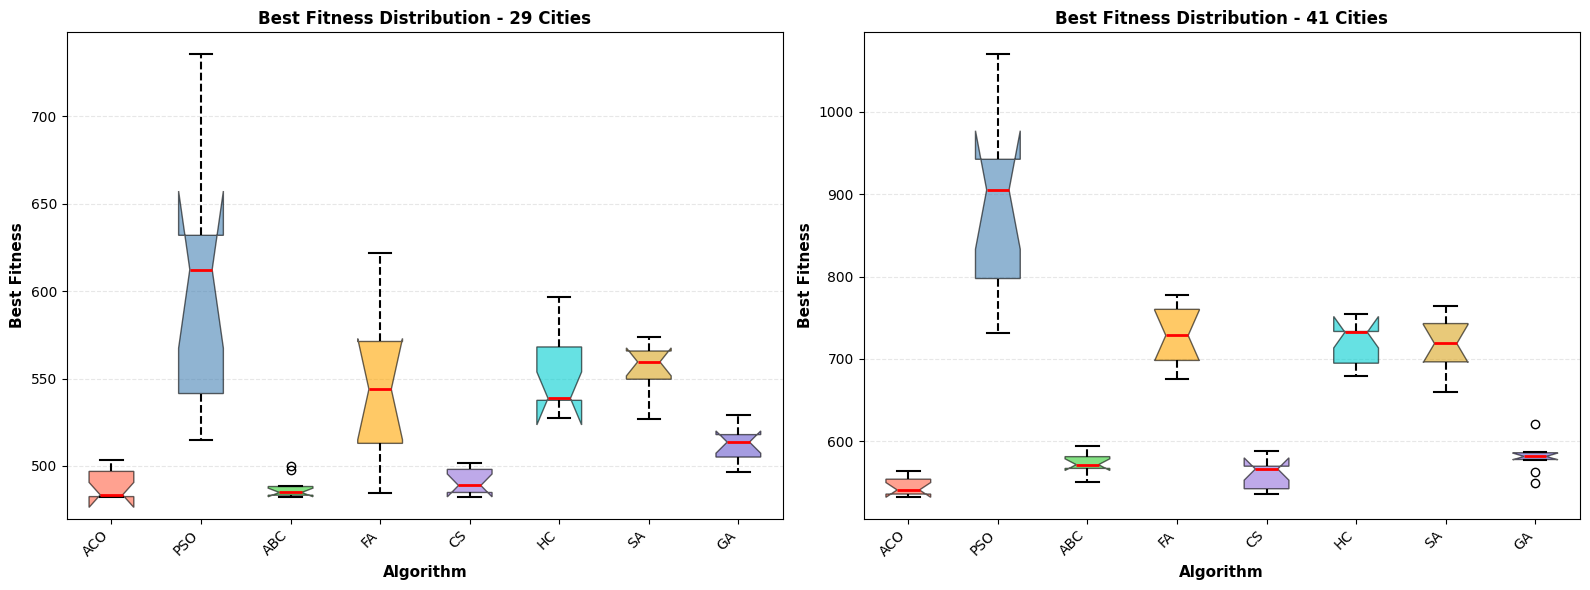

In [ ]:
# =============================================================================
# 2. BOX PLOTS - Phân bố Best Fitness
# =============================================================================

cities_to_plot = sorted(list(all_results.keys()))
num_plots = len(cities_to_plot)

fig, axes = plt.subplots(1, num_plots, figsize=(8 * num_plots, 6))

# Ensure axes is an array even for a single plot
if num_plots == 1:
    axes = [axes]

for idx, n_cities in enumerate(cities_to_plot):
    ax = axes[idx]

    data_to_plot = []
    labels = []
    colors_list = []

    for algorithm_name in ALL_ALGORITHMS:
        if algorithm_name in all_results[n_cities]:
            results_list = all_results[n_cities][algorithm_name]
            if results_list:
                best_fitnesses = [r['best_fitness'] for r in results_list]
                data_to_plot.append(best_fitnesses)
                labels.append(algorithm_name)
                colors_list.append(colors[algorithm_name])

    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True,
                    notch=True, showfliers=True)

    # Tô màu cho các box
    for patch, color in zip(bp['boxes'], colors_list):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    # Tùy chỉnh whiskers và caps
    for whisker in bp['whiskers']:
        whisker.set(linewidth=1.5, linestyle='--')
    for cap in bp['caps']:
        cap.set(linewidth=1.5)
    for median in bp['medians']:
        median.set(color='red', linewidth=2)

    ax.set_xlabel('Algorithm', fontsize=11, fontweight='bold')
    ax.set_ylabel('Best Fitness', fontsize=11, fontweight='bold')
    ax.set_title(f'Best Fitness Distribution - {n_cities} Cities',
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('tsp_boxplots.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu: tsp_boxplots.png")
plt.show()

✓ Đã lưu: tsp_mean_comparison.png


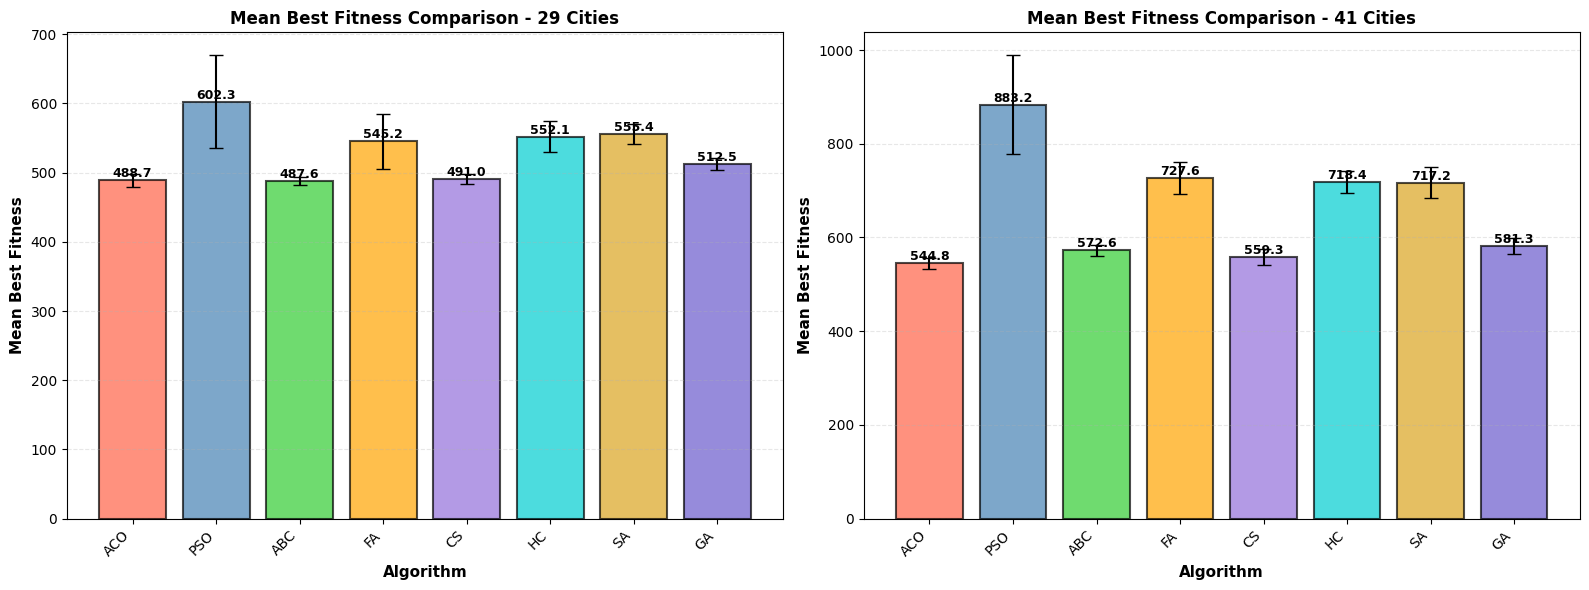

In [ ]:
# =============================================================================
# 3. BAR CHARTS - So sánh Mean Best Fitness
# =============================================================================

cities_to_plot = sorted(list(all_results.keys()))
num_plots = len(cities_to_plot)

fig, axes = plt.subplots(1, num_plots, figsize=(8 * num_plots, 6))

# Ensure axes is an array even for a single plot
if num_plots == 1:
    axes = [axes]

for idx, n_cities in enumerate(cities_to_plot):
    ax = axes[idx]

    algorithms = []
    means = []
    stds = []
    colors_list = []

    for algorithm_name in ALL_ALGORITHMS:
        if algorithm_name in all_results[n_cities]:
            results_list = all_results[n_cities][algorithm_name]
            if results_list:
                best_fitnesses = [r['best_fitness'] for r in results_list]
                algorithms.append(algorithm_name)
                means.append(np.mean(best_fitnesses))
                stds.append(np.std(best_fitnesses))
                colors_list.append(colors[algorithm_name])

    bars = ax.bar(algorithms, means, yerr=stds, capsize=5,
                  color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

    # Thêm giá trị trên các cột
    for bar, mean_val in zip(bars, means):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{mean_val:.1f}',
               ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xlabel('Algorithm', fontsize=11, fontweight='bold')
    ax.set_ylabel('Mean Best Fitness', fontsize=11, fontweight='bold')
    ax.set_title(f'Mean Best Fitness Comparison - {n_cities} Cities',
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('tsp_mean_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu: tsp_mean_comparison.png")
plt.show()

✓ Đã lưu: tsp_execution_time.png


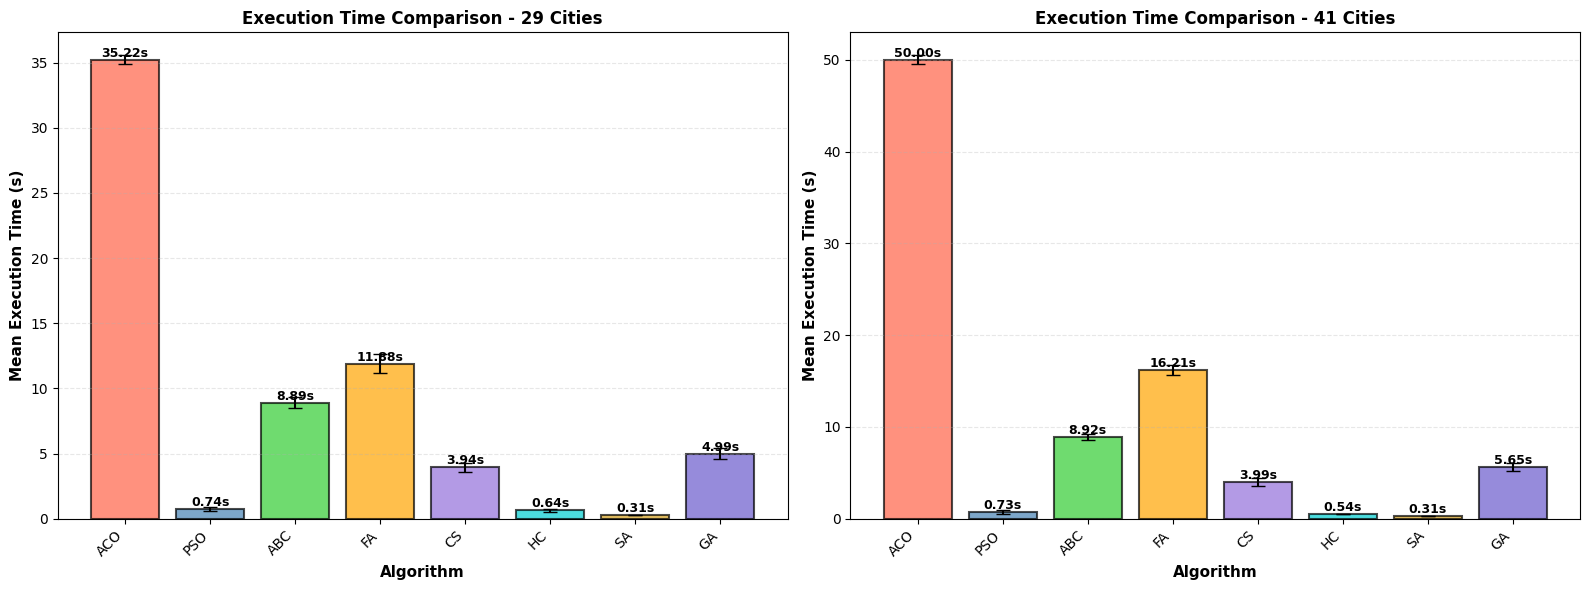

In [ ]:
# =============================================================================
# 4. EXECUTION TIME COMPARISON
# =============================================================================

cities_to_plot = sorted(list(all_results.keys()))
num_plots = len(cities_to_plot)

fig, axes = plt.subplots(1, num_plots, figsize=(8 * num_plots, 6))

# Ensure axes is an array even for a single plot
if num_plots == 1:
    axes = [axes]

for idx, n_cities in enumerate(cities_to_plot):
    ax = axes[idx]

    algorithms = []
    mean_times = []
    std_times = []
    colors_list = []

    for algorithm_name in ALL_ALGORITHMS:
        if algorithm_name in all_results[n_cities]:
            results_list = all_results[n_cities][algorithm_name]
            if results_list:
                exec_times = [r['execution_time'] for r in results_list]
                algorithms.append(algorithm_name)
                mean_times.append(np.mean(exec_times))
                std_times.append(np.std(exec_times))
                colors_list.append(colors[algorithm_name])

    bars = ax.bar(algorithms, mean_times, yerr=std_times, capsize=5,
                  color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

    # Thêm giá trị
    for bar, time_val in zip(bars, mean_times):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{time_val:.2f}s',
               ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xlabel('Algorithm', fontsize=11, fontweight='bold')
    ax.set_ylabel('Mean Execution Time (s)', fontsize=11, fontweight='bold')
    ax.set_title(f'Execution Time Comparison - {n_cities} Cities',
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('tsp_execution_time.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu: tsp_execution_time.png")
plt.show()

✓ Đã lưu: tsp_scalability.png


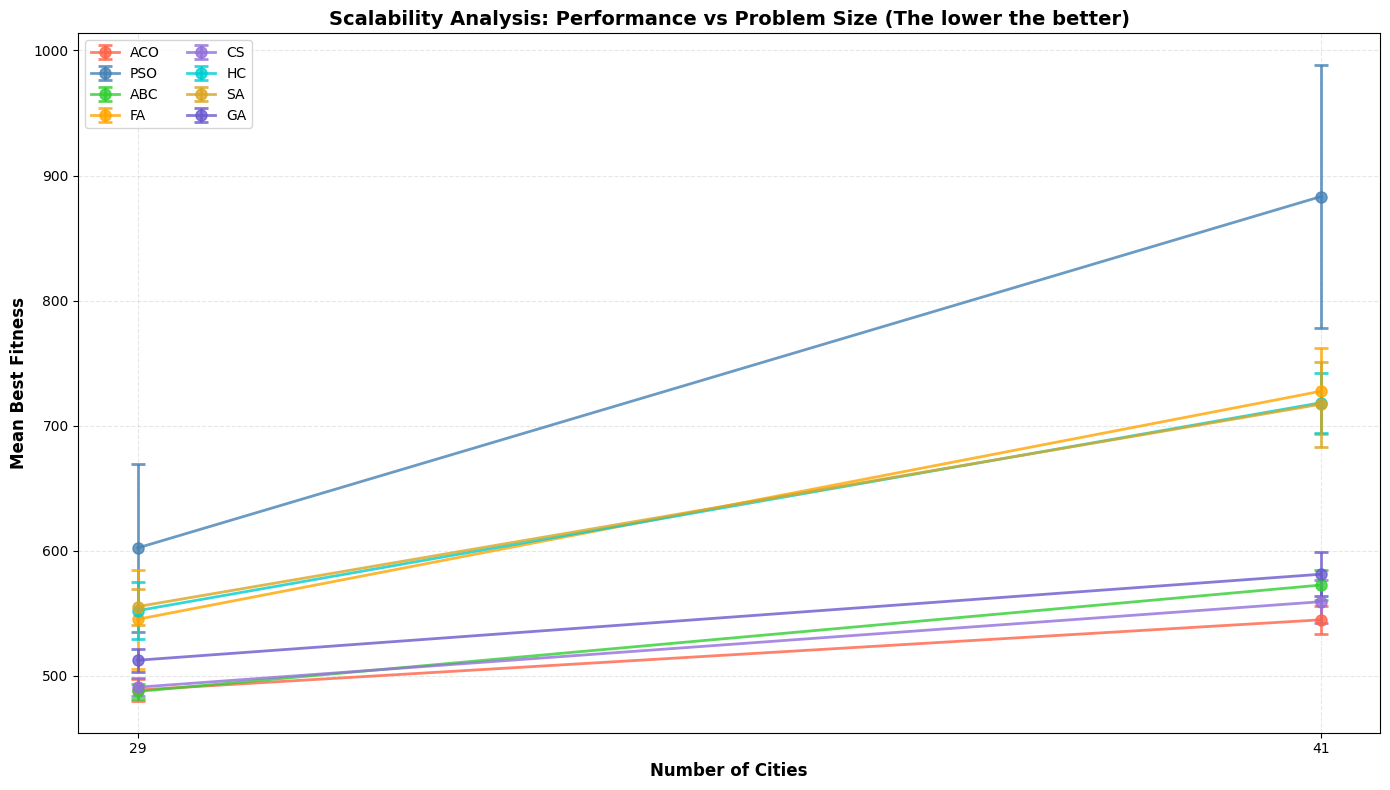

In [ ]:
# =============================================================================
# 5. COMBINED PLOT - Best Fitness vs Cities Size
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

for algorithm_name in ALL_ALGORITHMS:
    mean_fitnesses = []
    std_fitnesses = []
    cities_with_data = []

    for n_cities in CITY_SIZES:
        if algorithm_name in all_results[n_cities]:
            results_list = all_results[n_cities][algorithm_name]
            if results_list:
                best_fitnesses = [r['best_fitness'] for r in results_list]
                mean_fitnesses.append(np.mean(best_fitnesses))
                std_fitnesses.append(np.std(best_fitnesses))
                cities_with_data.append(n_cities)

    if mean_fitnesses:
        ax.errorbar(cities_with_data, mean_fitnesses, yerr=std_fitnesses,
                   label=algorithm_name, marker='o', markersize=8,
                   linewidth=2, capsize=5, capthick=2,
                   color=colors[algorithm_name], alpha=0.8)

ax.set_xlabel('Number of Cities', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Best Fitness', fontsize=12, fontweight='bold')
ax.set_title('Scalability Analysis: Performance vs Problem Size (The lower the better)',
            fontsize=14, fontweight='bold')
# ax.text(3, 8, "The lower the better", style="italic")
ax.legend(loc='upper left', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xticks(CITY_SIZES)

plt.tight_layout()
plt.savefig('tsp_scalability.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu: tsp_scalability.png")
plt.show()